In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

import sys
sys.path.append('../Utilities/src')

from DA_tools.DA_colors import *

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


from numpy.random import normal,standard_t
from scipy.special import expit,logit


In [2]:
def mc_ecdf(x):
    N=len(x)
    srt_x = np.sort(x)
    values, counts = np.unique(srt_x, return_counts=True)
    probs = np.cumsum(counts/N)
    mc_se = np.sqrt(probs*np.abs(1-probs)/N)
    return values, probs, mc_se

def mc_hist(sample,bins='auto'):
    N=len(sample)
    hist,new_bins = np.histogram(sample,bins=bins)
    probs = hist/N
    mc_se = np.sqrt(probs*np.abs(1-probs)/N)
    return new_bins,probs,mc_se


def pad_hist_for_plot(bins,counts):
    if len(counts.shape)==1:
        ax=0
    else: ax=1
        
    xs = (np.repeat(bins,repeats=2))[1:-1]
    pad_counts = np.repeat(counts,repeats=2,axis=ax)
    return xs, pad_counts


def mc_ecdf_plot(values, probs, mc_se,ax=None):
    if ax is None:
        ax = plt.gca()
    ax.fill_between(values,probs-mc_se,probs+mc_se,color=LIGHT_HIGHLIGHT)
    ax.plot(values,probs,color=DARK)
    ax.set_ylabel('ECDF (Estimated Probabilities)')
    ax.set_xlabel('X')
    ax.set_xlim((min(values),max(values)))
    ax.set_xticks([min(values),np.median(values),max(values)])
    ax.set_yticks([0,0.25,0.5,0.75,1])
    return ax

def rolling_stats(sample):
    sample_series = pd.Series(sample)
    N=len(sample)
    sqrtNs = np.sqrt([*range(1,N+1)])
    rolling_mean = sample_series.expanding().mean().values
    rolling_mcse = sample_series.expanding().std().fillna(0).values/sqrtNs
    return rolling_mean, rolling_mcse

def mc_plot(rolling_mean, rolling_mcse,ax=None):
    if ax is None:
        ax = plt.gca()
    N=len(rolling_mean)
    ns = [*range(1,N+1)]
    colortab = [LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT]
    for i in range(3):
        ax.fill_between(ns,
                        rolling_mean-(3-i)*rolling_mcse,
                        rolling_mean+(3-i)*rolling_mcse,
                        color=colortab[i])
    ax.plot(ns,rolling_mean,color=DARK)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('Monte Carlo Estimator')
    ax.set_xlim((0,N+1))
    return ax
    
def mc_hist_plot(new_bins, probs,mc_se,ax=None,scale=False):
    if ax is None:
        ax = plt.gca()
    if scale:
        bin_width = np.diff(new_bins)[-1]
        probs = probs/bin_width
        mc_se = mc_se/bin_width
    xs,pad_hist =  pad_hist_for_plot(new_bins,probs)
    _,up_bar =  pad_hist_for_plot(new_bins,probs+mc_se)
    _,low_bar =  pad_hist_for_plot(new_bins,probs-mc_se)
    ax.fill_between(xs,low_bar,up_bar,color=LIGHT_HIGHLIGHT)
    ax.plot(xs,pad_hist,color=DARK,linewidth = 1.5)
    ax.set_ylabel('Estimated Bin Probabilities')
    if scale:
        ax.set_ylabel('Estimated Bin Probabilities\n divided by bin width')
    ax.set_xlabel('X')
    return ax

# Advanced Statistical Modelling and Data Analysis


## Monte Carlo methods

### dr hab. inż. Jerzy Baranowski, Prof. AGH

## Random number generation

In order to get random samples we need to find a way of obtaining 'randomness'

- Hardware random number generators
- Pseudo-random number generators

## Pseudo-random number generators

- a formula for generating a sequence of numbers that preferably
    - has low autocorrelation
    - has a long period
    - uniformly distributes quantiles of generated numbers
- simplest way is a linear congruent recurrence:

$$ 
X_{n+1}=(a X_n + c)\ \mathrm{mod}\ m 
$$

- currently widely adapted is the *Meresene twister* algorithm



## Preliminaries
For probability distrubution $\pi$ defined over one-dimensional space $X$, and point $x\in X$ we can define an interval

$$
I(x_{min},x)\subset X
$$ 
which has a probablity $\mathbb{P}_\pi[I(x_{min},x)]$.

The cumulative distribution function (CDF) maps each point to this corresponding
probability

$$
\begin{aligned}
\Pi :\; &X& &\rightarrow& \; &[0, 1] \subset \mathbb{R}&
\\
&x& &\mapsto& &\mathbb{P}_{\pi}[I(x_{\text{min}}, x )]&
\end{aligned}
$$

Quantile function, for all intents and purposes is the inverse of CDF
$$
q_\pi(p)=\Pi^{-1}(x)
$$


## Getting from uniform to arbitrary

- In one dimension it is relatively easy.
- PRNG generates a sequence of uniformly distributed numbers $\{p_1,\ldots,p_N\}$ in $[0,1]$ interval
- The sequence $\{q_\pi(p_1),\ldots,q_\pi(p_N)\}$ is a sample from $\pi$ distribution   

## Monte Carlo estimators



Assuming that we have a sequence of samples from the distribution $\pi$:
$$
\{q_1,\ \ldots,\ q_N\}
$$
for any real valued, integrable function $f$, there exists a Monte Carlo estimator

$$
\hat{f}^{MC}_N = \frac{1}{N} \sum_{n=1}^{N}f(q_n)
$$
is asymptotically consistent, i.e.

$$
\lim_{N\rightarrow\infty}\hat{f}^{MC}_N = \mathbb{E}_\pi[f]
$$

## $\hat{f}^{MC}_N$ is approximately normaly distributed

$$
\hat{f}^{MC}_N \sim \mathrm{normal}\left(y\left|\mathbb{E}_\pi[f], \sqrt{\frac{\mathbb{V}_\pi[f]}{N}}\right.\right)+{O}\left(N^{-\frac{3}{2}}\right)
$$

Higher order terms can usually be considered negligible for $N>10$, and then we can approximate $\mathbb{E}_\pi[f]$ with the probabilistic standard error

$$
\mathrm{MC\text{-}SE}[f]=\sqrt{\frac{\mathbb{V}_\pi[f]}{N}}
$$



## Absolute and relative error

$\text{MC-SE}[f]$ is a measure of absolute error, and can be estimated from the sample as:

$$
\widehat{\text{MC-SE}}[f] = \sqrt{\frac{1}{N} \hat{V}[f]}= \sqrt{\frac{1}{N}\frac{1}{N-1}\sum_{n=1}^N \left(f(x_n)-\hat{\mu}[f]\right)^2}
$$

However for small values of expectation, we can often use relative error
$$
\frac{\widehat{\text{MC-SE}}[f]}{\hat{\mu}[f]}
$$

$\hat{\mu}[f]$ and $\hat{V}[f]$ are sample mean and variance.


## Ensuring relative precission

If our goal is to have desired relative error, we have:

$$
\alpha\geq\frac{\widehat{\text{MC-SE}}[f]}{\hat{\mu}[f]}\quad \quad \alpha\geq\sqrt{\frac{\hat{V}[f]}{N\cdot \hat{\mu}[f]^2}}
$$
$$
\alpha^2\geq {\frac{\hat{V}[f]}{N\cdot \hat{\mu}[f]^2}}
$$
$$
N\geq {\frac{\hat{V}[f]}{\alpha^2\cdot \hat{\mu}[f]^2}}
$$



## Sumarizing samples

- Moments and cumulants
- Event probabilities
- Histograms
- ECDFs
- Quantiles

## Moments and cumulants

 - For the purpose of distriution summary multiple functions can be used.
 - The most known are the moments, like mean, variance, skewness, kurtosis
 - Also known are cummulants, which partially overlap moments

## Probabilities

- One of the more usefull quantities of interest is the probability if function value lies in the interval of interest. 
- This is done by computing expectations of indicator functions $\mathbb{I}_{\Delta f}$
$$
\mathbb{I}_{\Delta f}(f(x)) = \begin{cases} 1&\text{for }f(x)\in\Delta f\\
 0&\text{for }f(x)\not\in\Delta f
\end{cases}
$$
- Expectation is estimated as usual, so 
$$
\mathbb{P}_{\pi}[\Delta f] = \mathbb{E}_{\pi}[\mathbb{I}_{\Delta f}]  \approx \frac{1}{N}\sum_{i=0}^N \mathbb{I}_{\Delta f}(f(x_n))=\frac{N[\Delta f]}{N} = p
$$
which is the proportion of samples laying in the interval

## Probability uncertainity
MC-SE of indicator function is relatively easy to determine, as square of indicator is given by  

$$
\mathbb{I}_{\Delta f}^{2} = \mathbb{I}_{\Delta f}
$$

Then the variance of an indictor function can be computed directly from the
corresponding probability,



## Absolute and relative errors
MC-SE as always gives us absolute error
$$
\text{MC-SE}[ \mathbb{I}_{\Delta f} ] = \sqrt{ \frac{p \cdot (1 - p) }{N} }.
$$
relative error however

$$
\begin{aligned}
\frac{ \hat{\sigma}[\mathbb{I}_{\Delta f}]  }{ \hat{\mu}[\mathbb{I}_{\Delta f}]  }
&=
\frac{ \sqrt{ \frac{p \cdot (1 - p) }{N} } }{ p }
\\
&=
\sqrt{ \frac{1 - p}{N \cdot p} }
\end{aligned}
$$
increases with decreasing estimated probability.

## Small relative error requires lot of samples

For example if $p = 0.01$ and we want a relative error of 5% then we need a
sample size of
$$
N \gt \frac{ 0.99 }{ (0.05)^{2} \cdot 0.01 } = 39600
$$

## Histograms

- Histogram is the task of probability estimation done for the entire space split into intervals. 
- All the above analysis also works here
- Types of normalization:
    - No normalization - just counts
    - Counts divided by number of samples - probability estimates $\approx$ probability mass function
    - Integral equal to 1 

## Empirical Cumulative Distribution Function

In a way companion to a histogram

```python
def ecdf(x):
    N=len(x)
    srt_x = np.sort(x)
    values, counts = np.unique(srt_x, return_counts=True)
    probs = np.cumsum(counts/N)
    return values, probs
```

Uncertainity comes from probability estimate MC-SE for the intervals $I(y_{min}, f(x_n))$

## Quantiles

In a way inverse problem to determining probability of interval. A $p$-quantile is defined
implicitly as the point $y_{p} \in Y$ satisfying

$$
p = \mathbb{P}_{\pi} [ I(y_{\text{min}}, y_{p}) ].
$$

Simple if we have a point, for which $p(f(x_n))=p$, then $y_p = f(x_n)$ otherwise it has to be interpolated between $f(x_n)$ and $f(x_{n+1}$), such that

$$
p(f(x_{n})) \lt p \lt p(f(x_{n + 1}))
$$

Low probability quantiles still require lot of samples to obtain low relative errors.

## Example 1 - normal distribution

We get 1000 samples from $N(1,1.25)$ distribution

```python 
from numpy.random import normal
sample_normal = normal(loc=1,scale=1.25,size=1000)
```



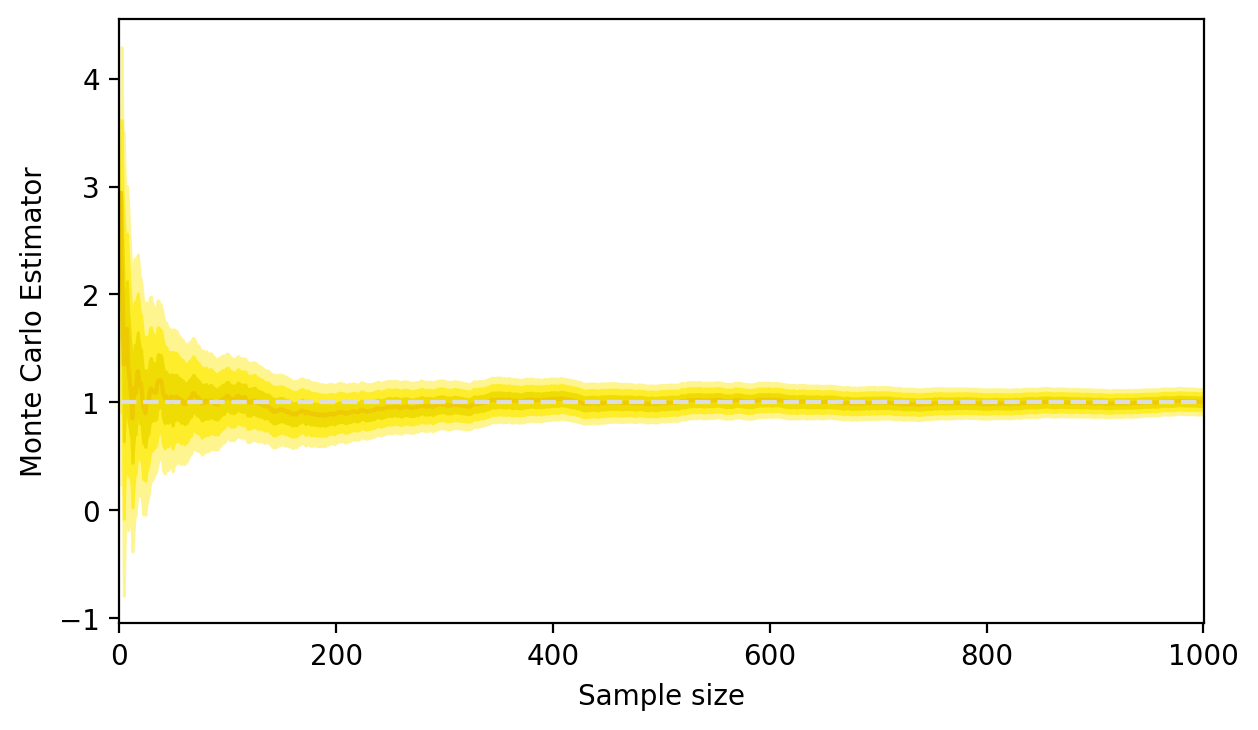

In [3]:
sample_normal = normal(loc=1,scale=1.25,size=1000)
rolling_mean, rolling_mcse = rolling_stats(sample_normal)
fig_rolling_normal,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
ax.plot([1,1000],[1,1],color=LIGHT_GREY,linestyle='--')
plt.show()

## Estimate uncertainity reduces with increasing sample size

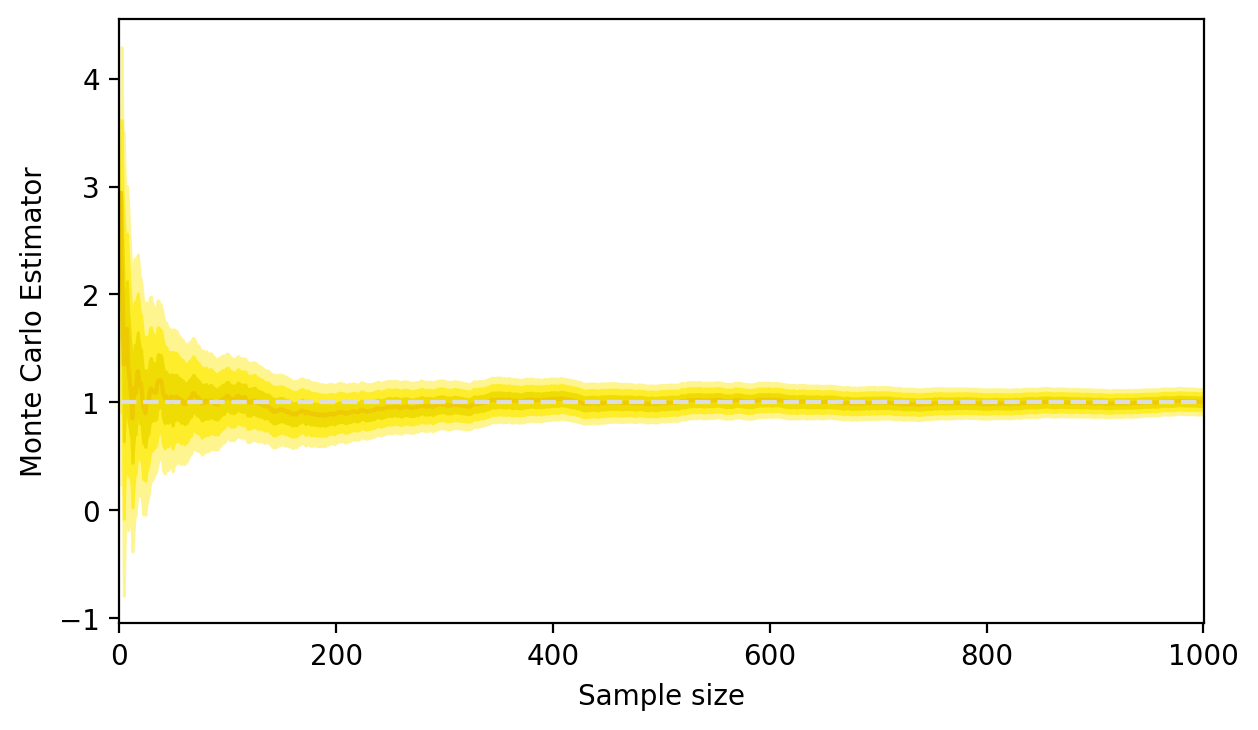

In [4]:
fig_rolling_normal

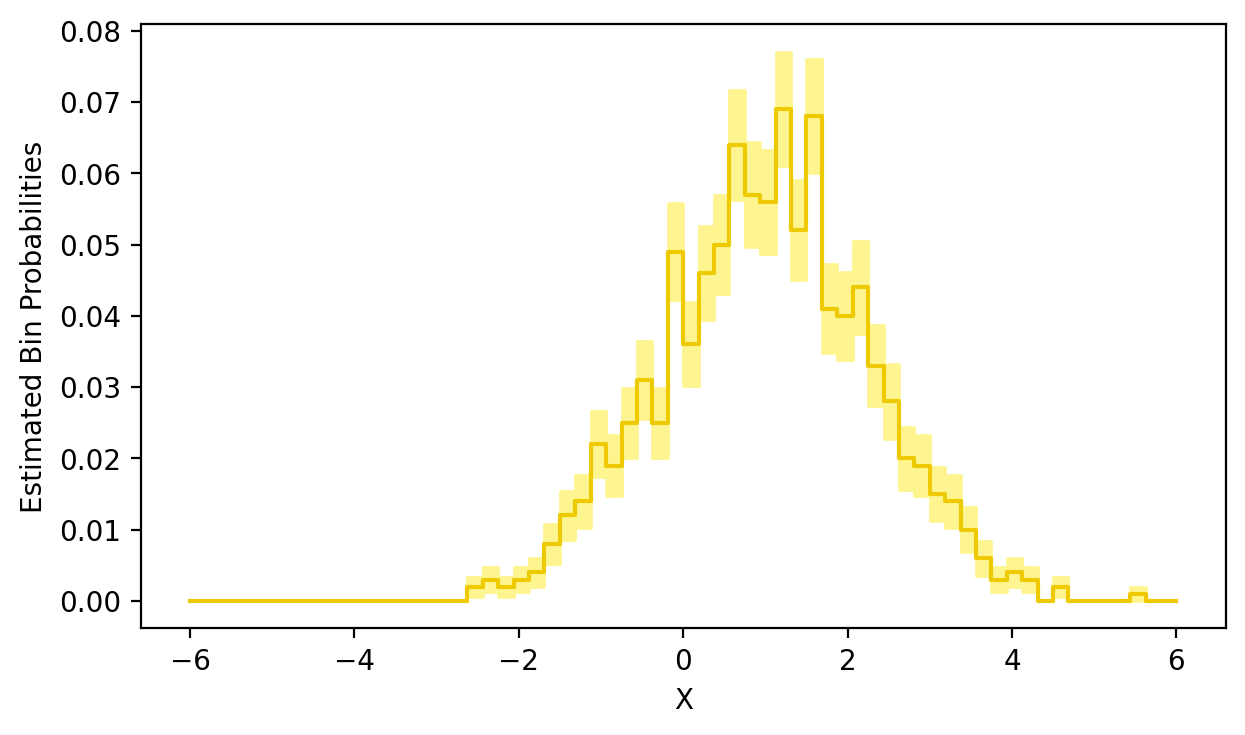

In [5]:
N=len(sample_normal)
bins = np.linspace(-6,6,13*5)
fig_normal_histogram,ax = plt.subplots(1,1,figsize = (7,4))

new_bins, probs,mc_se = mc_hist(sample_normal,bins)
xs = np.linspace(-6,6,200)
ax=mc_hist_plot(new_bins, probs,mc_se,ax)


## Histogram of the sample 

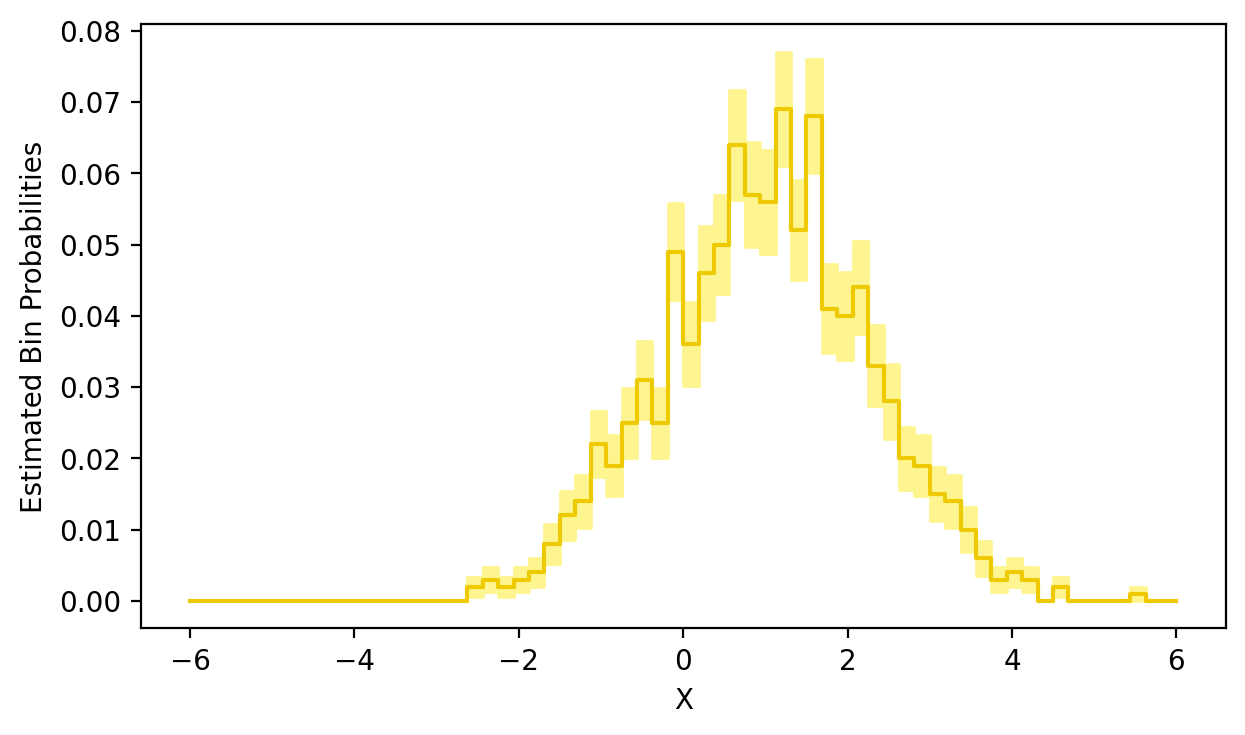

In [6]:
fig_normal_histogram

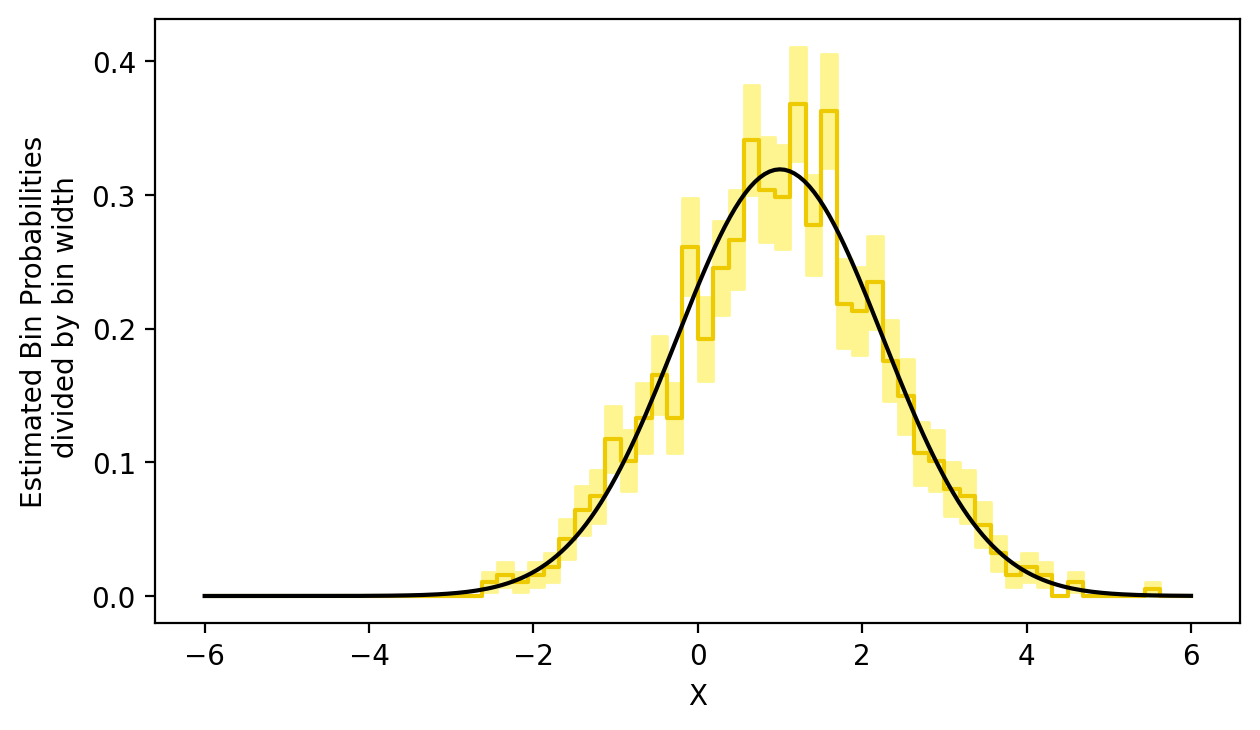

In [7]:
N=len(sample_normal)
bins = np.linspace(-6,6,13*5)
fig_normal_analytical,ax = plt.subplots(1,1,figsize = (7,4))

new_bins, probs,mc_se = mc_hist(sample_normal,bins)
xs = np.linspace(-6,6,200)
ax=mc_hist_plot(new_bins, probs,mc_se,ax,scale=True)
ax.plot(xs,stats.norm.pdf(xs,1,1.25),color='black')

## Comparison with analytical result

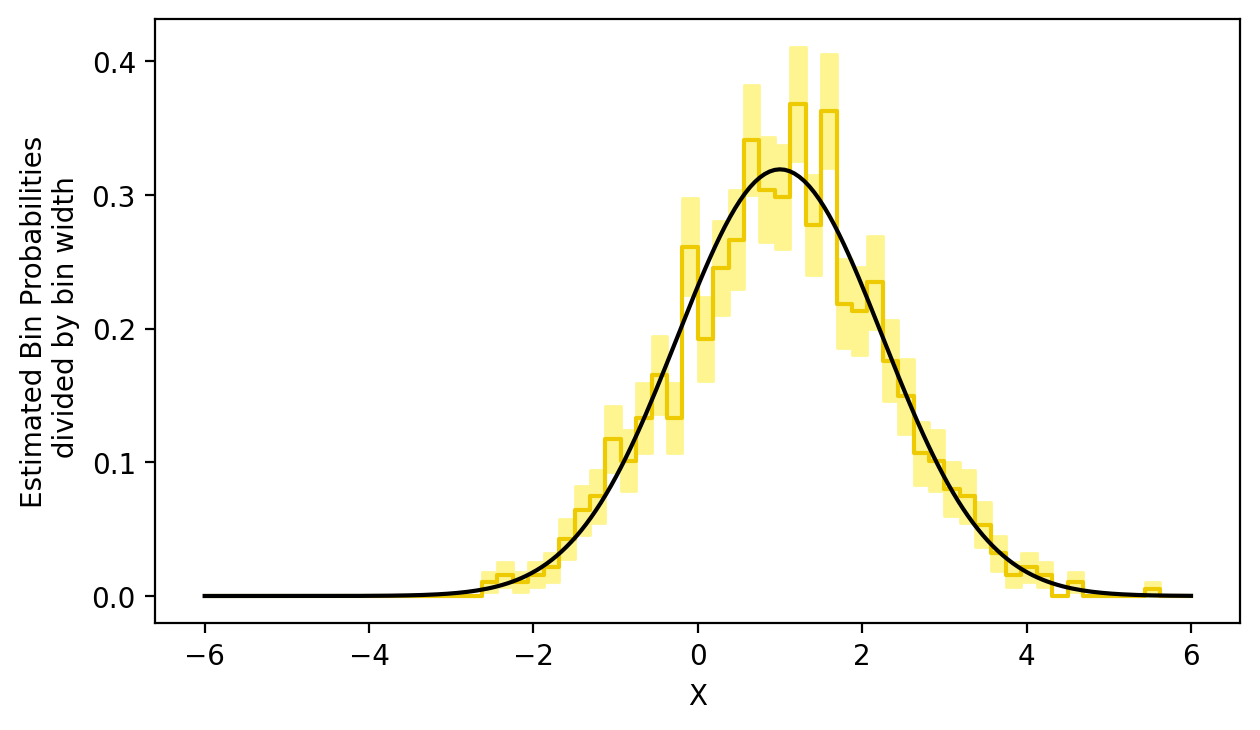

In [8]:
fig_normal_analytical

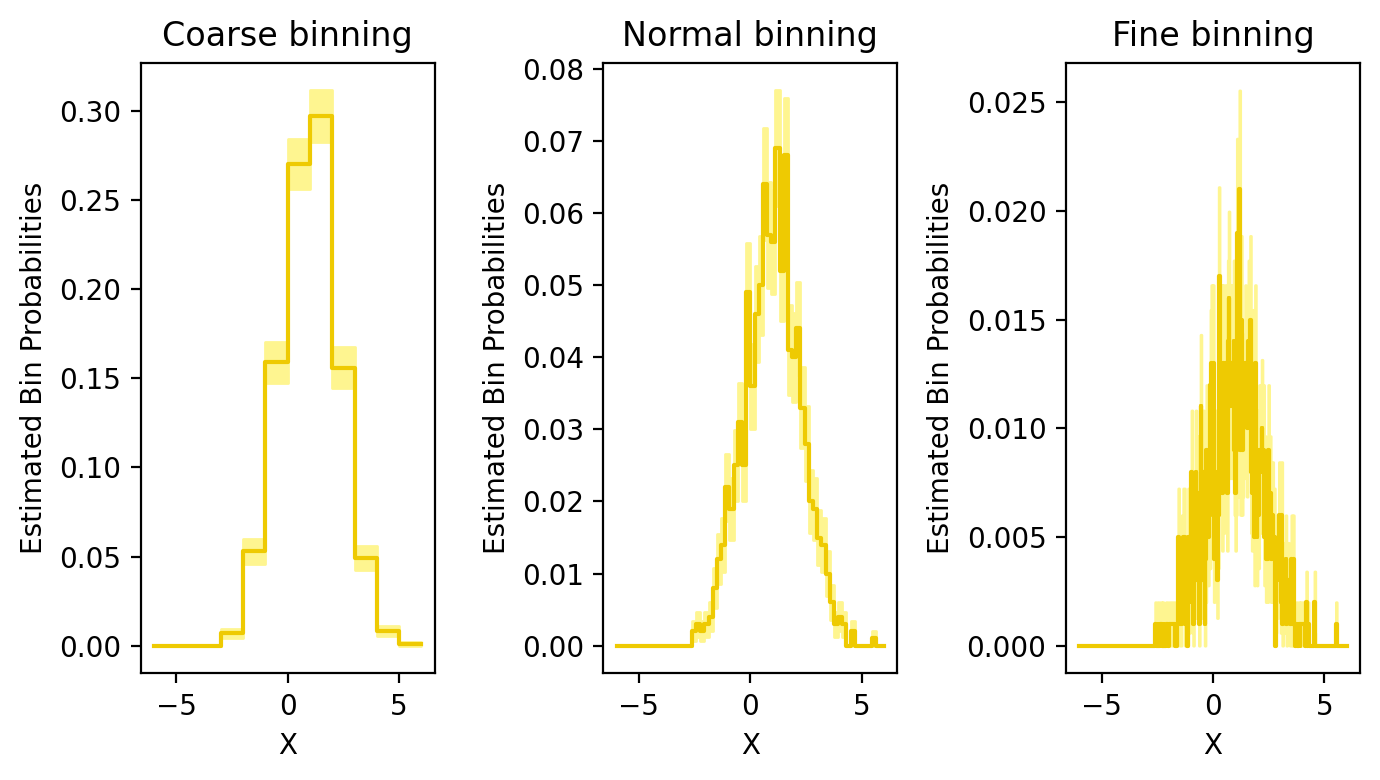

In [9]:
fig_binning,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (7,4),)

new_bins, probs,mc_se = mc_hist(sample_normal,np.linspace(-6,6,13))
ax1=mc_hist_plot(new_bins, probs,mc_se,ax1)
ax1.set_title('Coarse binning')
new_bins, probs,mc_se = mc_hist(sample_normal,np.linspace(-6,6,13*5))
ax2=mc_hist_plot(new_bins, probs,mc_se,ax2)
ax2.set_title('Normal binning')

new_bins, probs,mc_se = mc_hist(sample_normal,np.linspace(-6,6,13*25))
ax3=mc_hist_plot(new_bins, probs,mc_se,ax3)
ax3.set_title('Fine binning')

plt.tight_layout()

## Binning makes a difference 

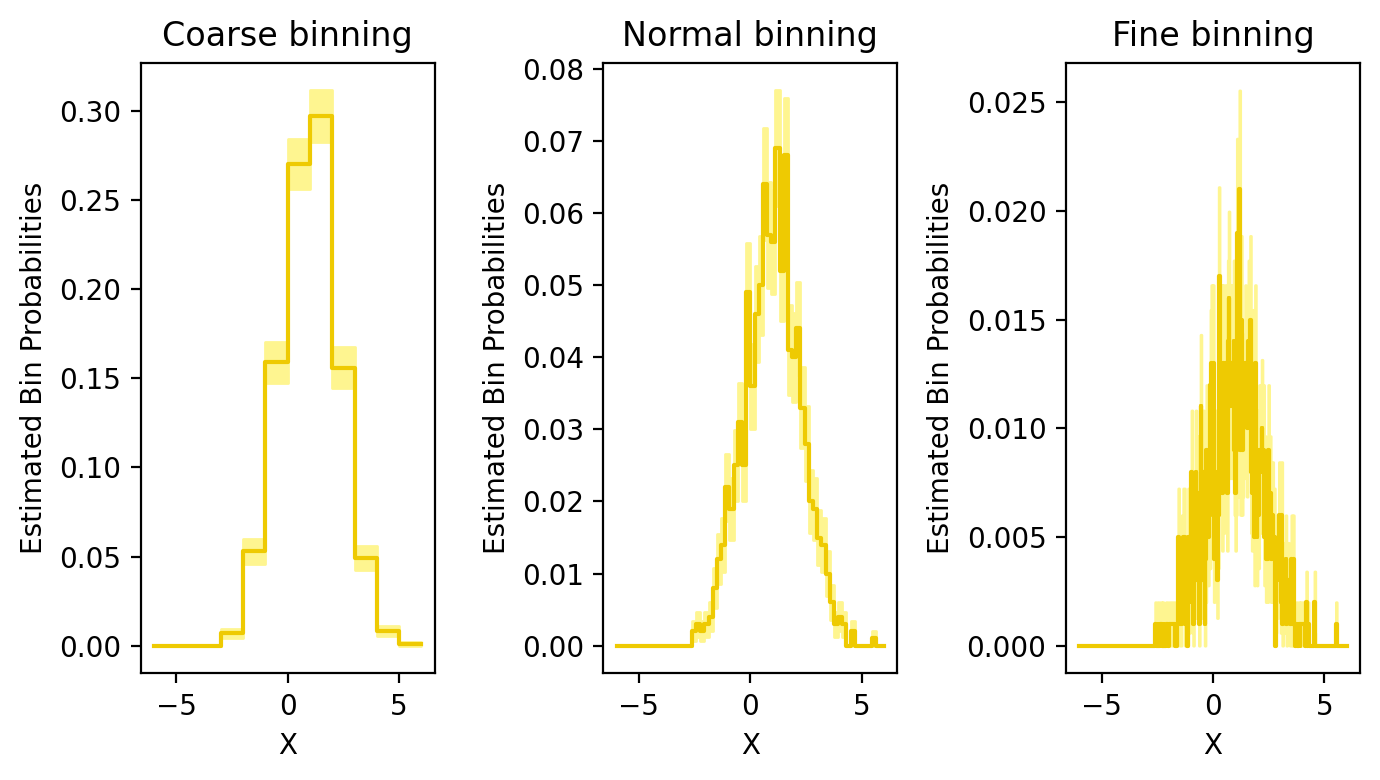

In [10]:
fig_binning

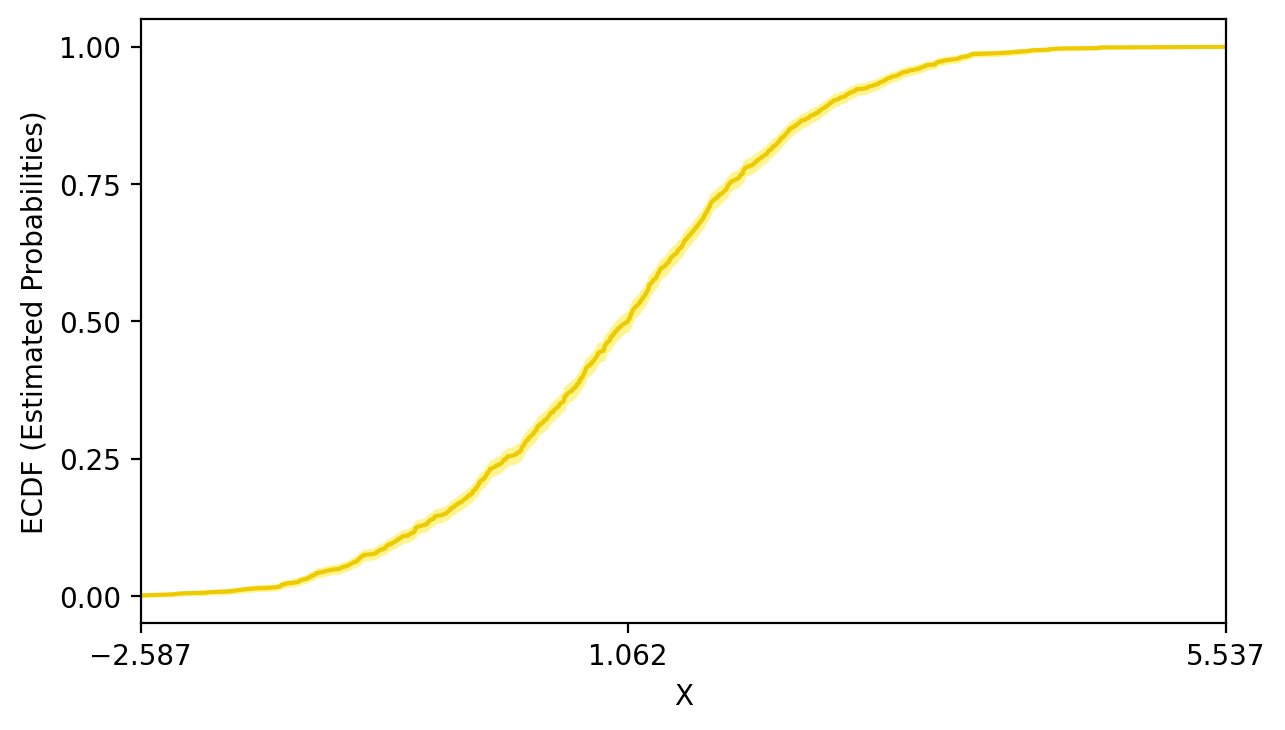

In [11]:
values, probs, mc_se = mc_ecdf(sample_normal)
fig_normal_ecdf,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_ecdf_plot(values, probs, mc_se,ax)


## ECDF

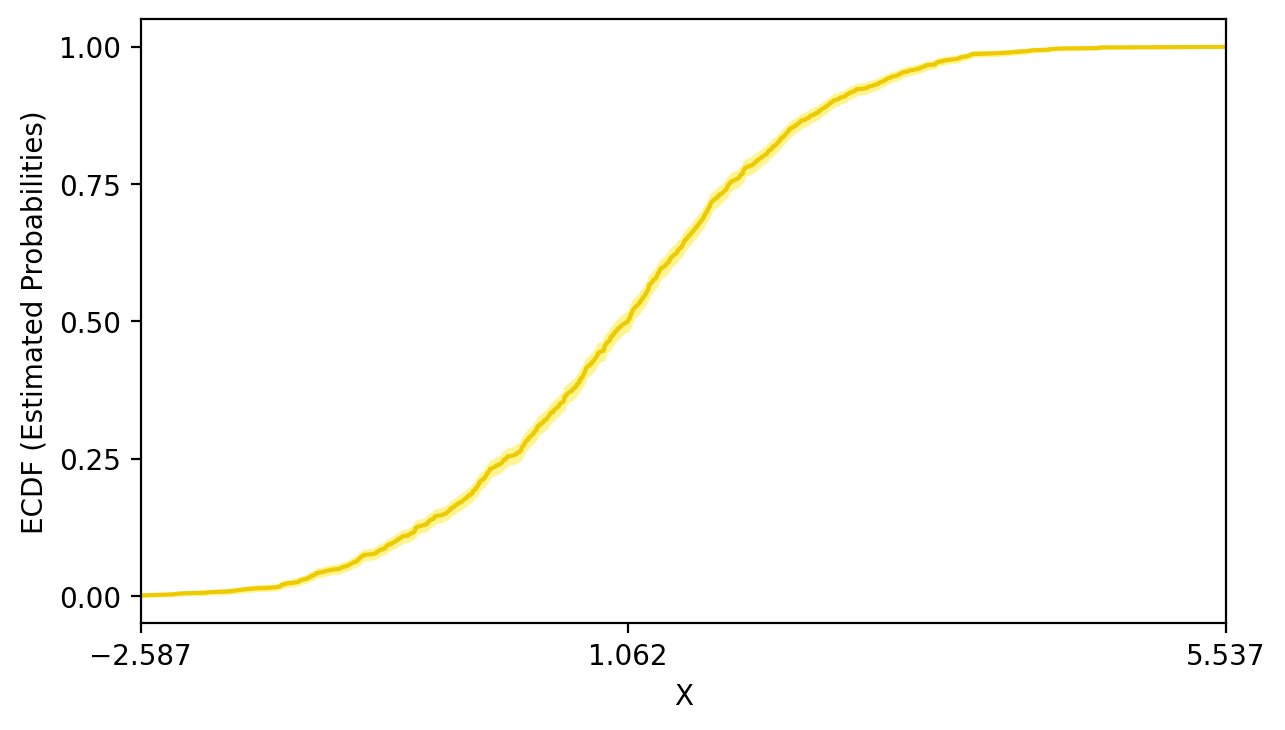

In [12]:
fig_normal_ecdf

## Example 2 - Normal samples pushed through inverse logistic function

Inverse logit (or expit) function 

$$
\begin{aligned}
\text{logit}^{-1} :\; &X = \mathbb{R} & &\rightarrow& \; &[0, 1] \subset \mathbb{R}&
\\
&x& &\mapsto& &\frac{1}{1 + \exp(-x)}&.
\end{aligned}
$$

In python it is readilly available

```python
from scipy.special import expit,logit

```


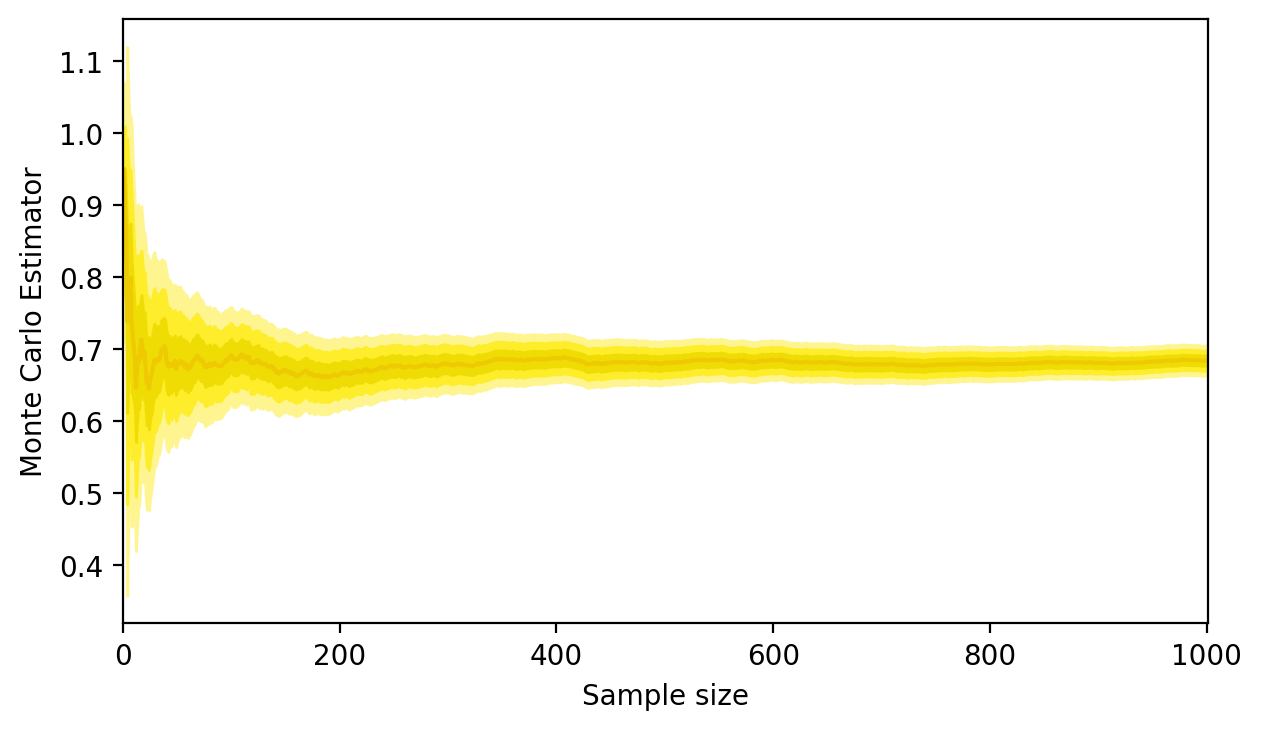

In [13]:
sample_pushforward = expit(sample_normal)
rolling_mean, rolling_mcse = rolling_stats(sample_pushforward)

fig_rolling_logit,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

## Samples are constrained, but expecation converges

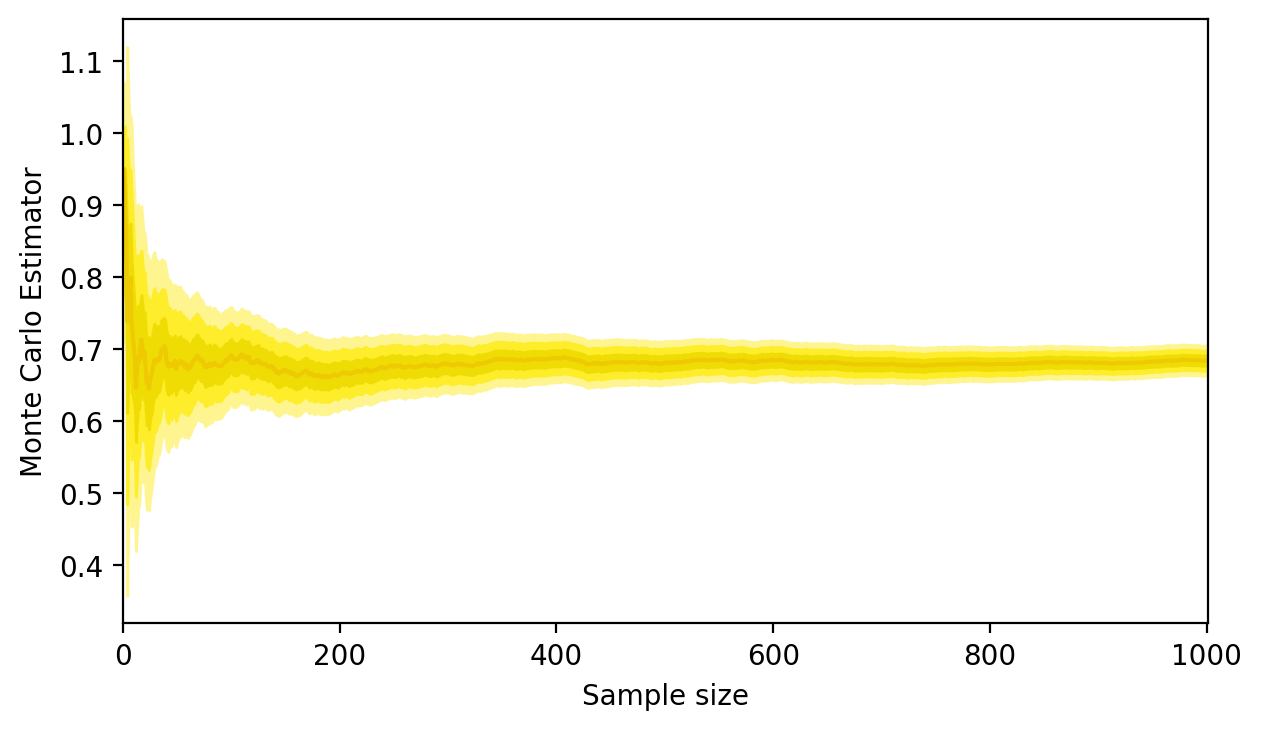

In [14]:
fig_rolling_logit

## Histogram allows observation of concentration around expected value

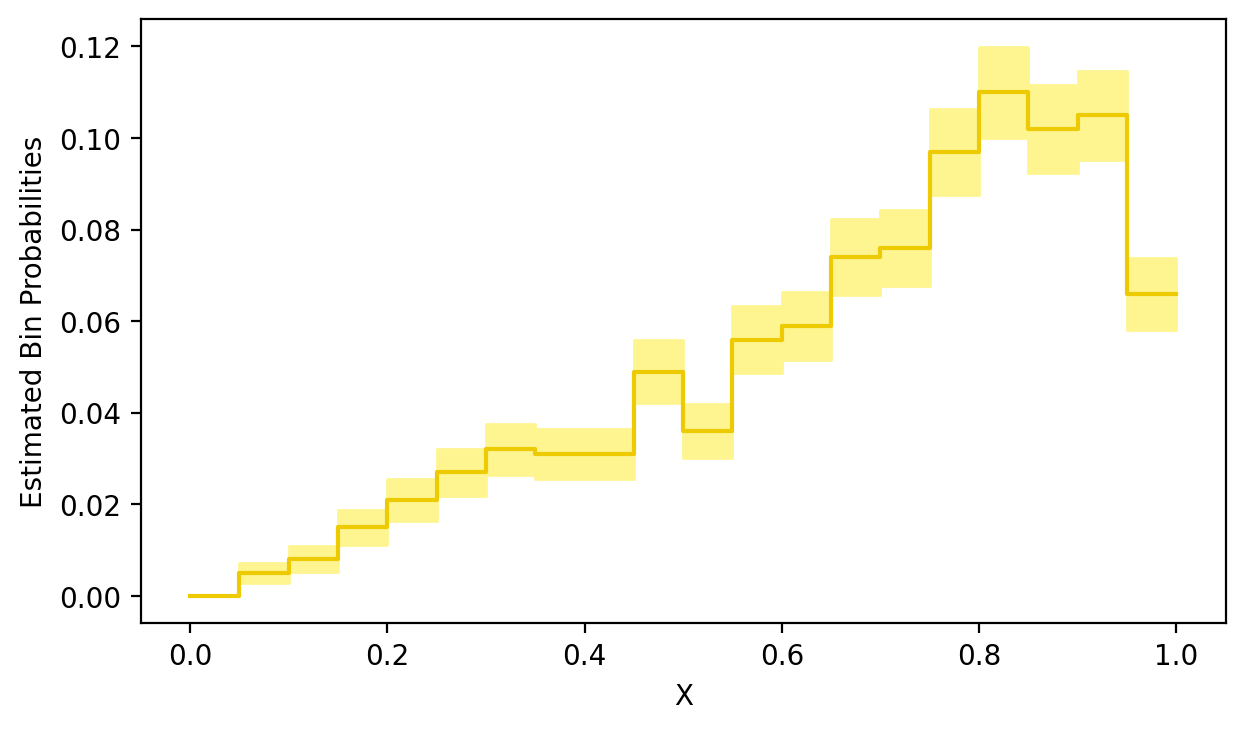

In [15]:
bins = np.linspace(0,1,21)
new_bins, probs,mc_se = mc_hist(sample_pushforward,bins)
fig_logit_hist,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_hist_plot(new_bins, probs,mc_se,ax,scale=False)



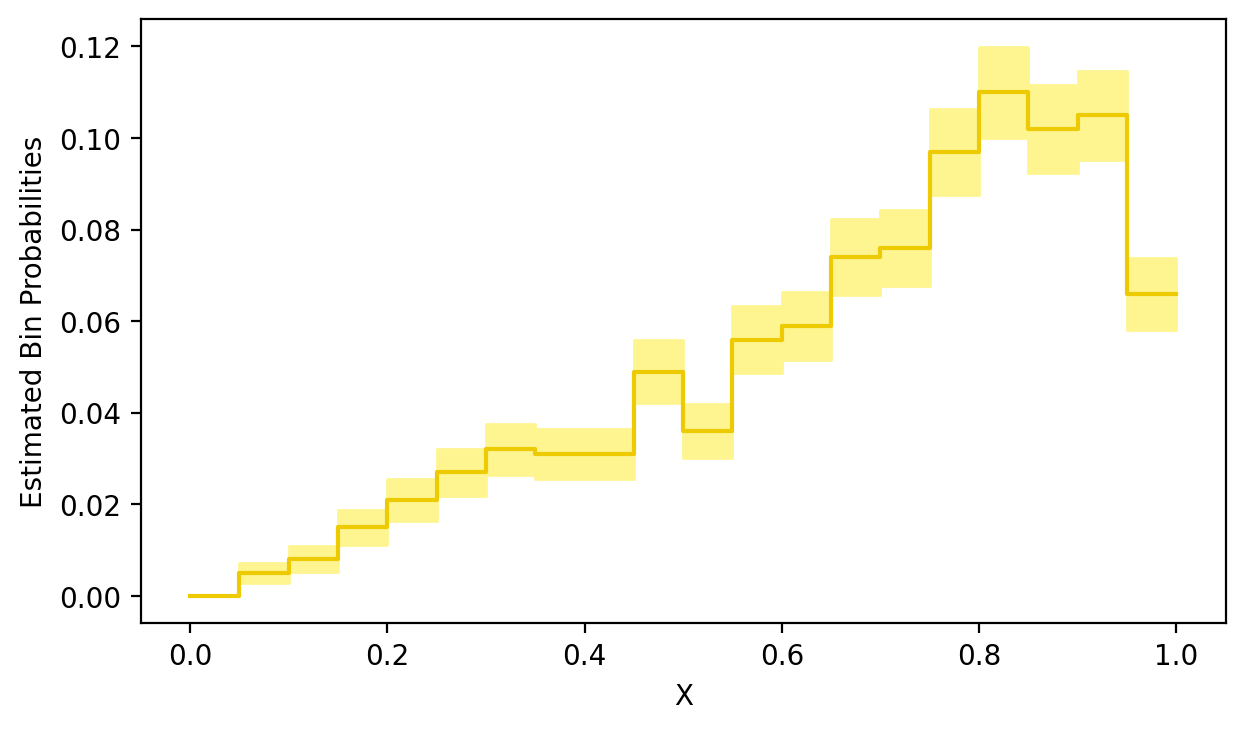

In [16]:
fig_logit_hist

## Changing scale we can compare it with analytical pushforward

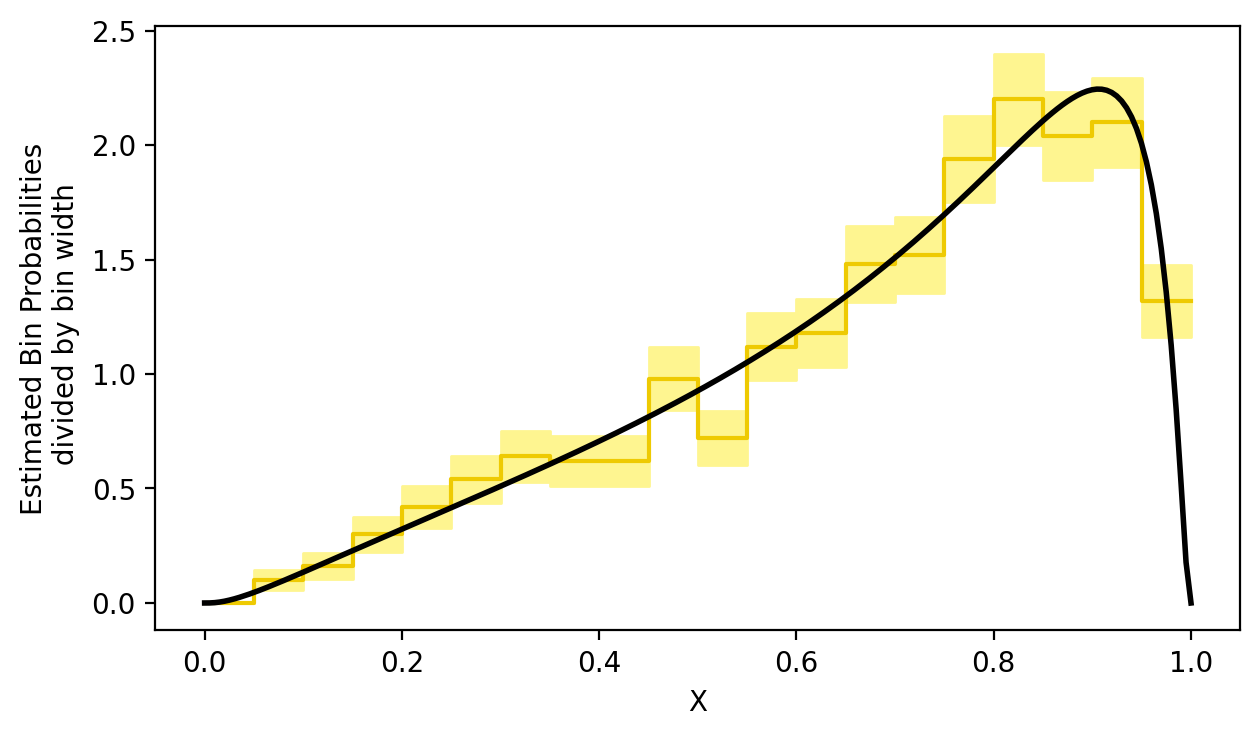

In [17]:
bins = np.linspace(0,1,21)
new_bins, probs,mc_se = mc_hist(sample_pushforward,bins)
fig_logit_analytical,ax = plt.subplots(1,1,figsize = (7,4))

xs = np.linspace(1e-6,1-1e-6,200)
analytical = stats.norm.pdf(logit(xs),1,1.25)/(xs*(1-xs))
ax = mc_hist_plot(new_bins, probs,mc_se,ax,scale=True)
ax.plot(xs,analytical,color='black',linewidth=2)



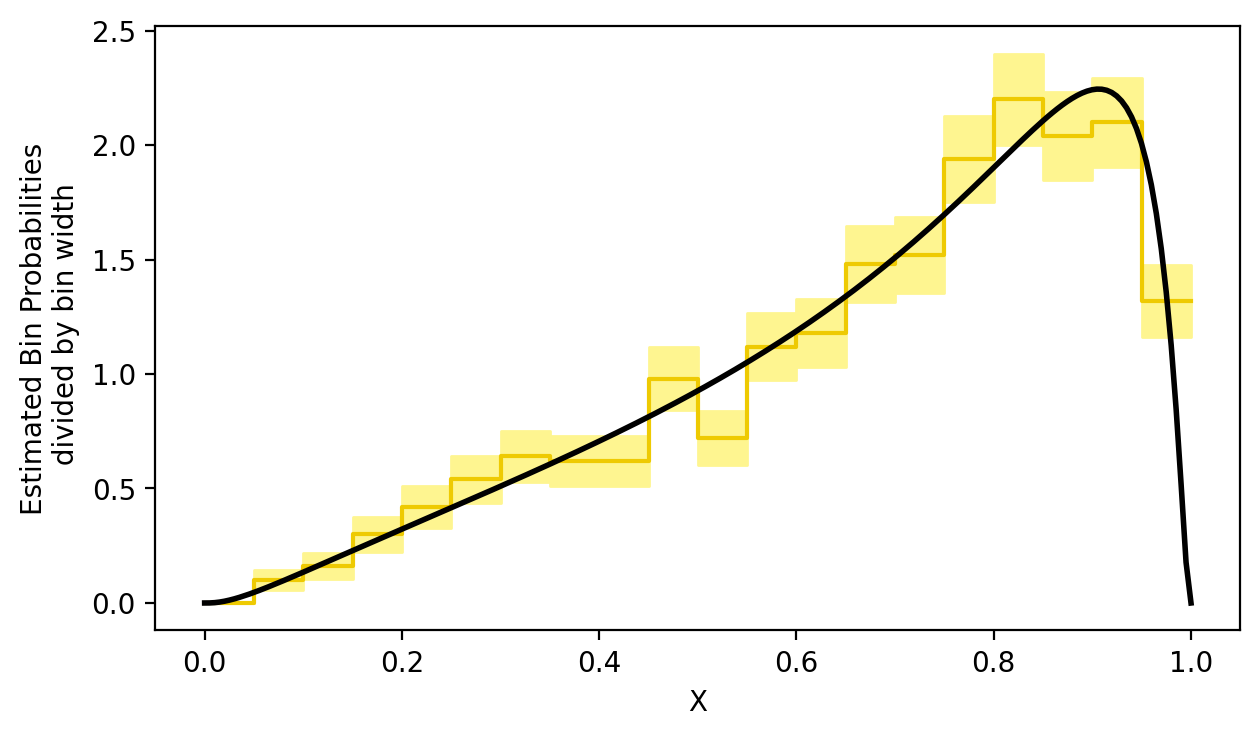

In [18]:
fig_logit_analytical

## ECDF for completness

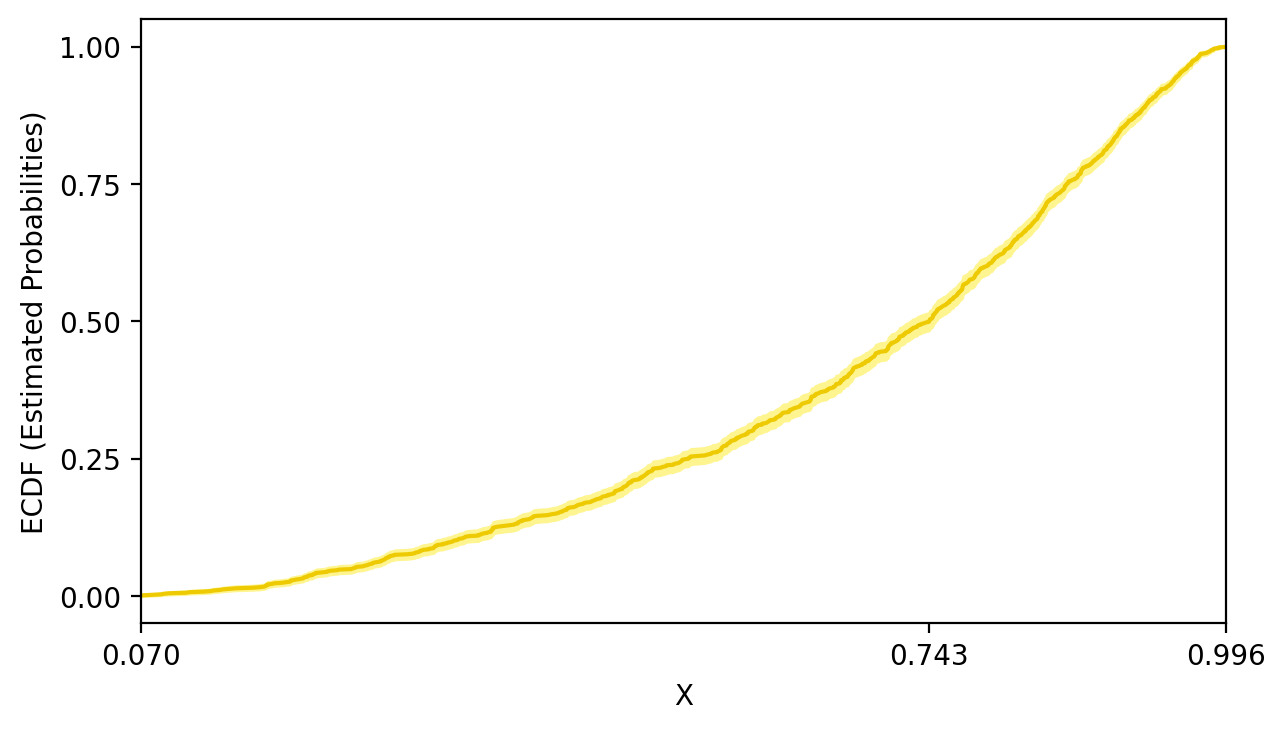

In [19]:
values, probs, mc_se = mc_ecdf(sample_pushforward)

fig_logit_ecdf,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_ecdf_plot(values, probs, mc_se,ax)
plt.show()

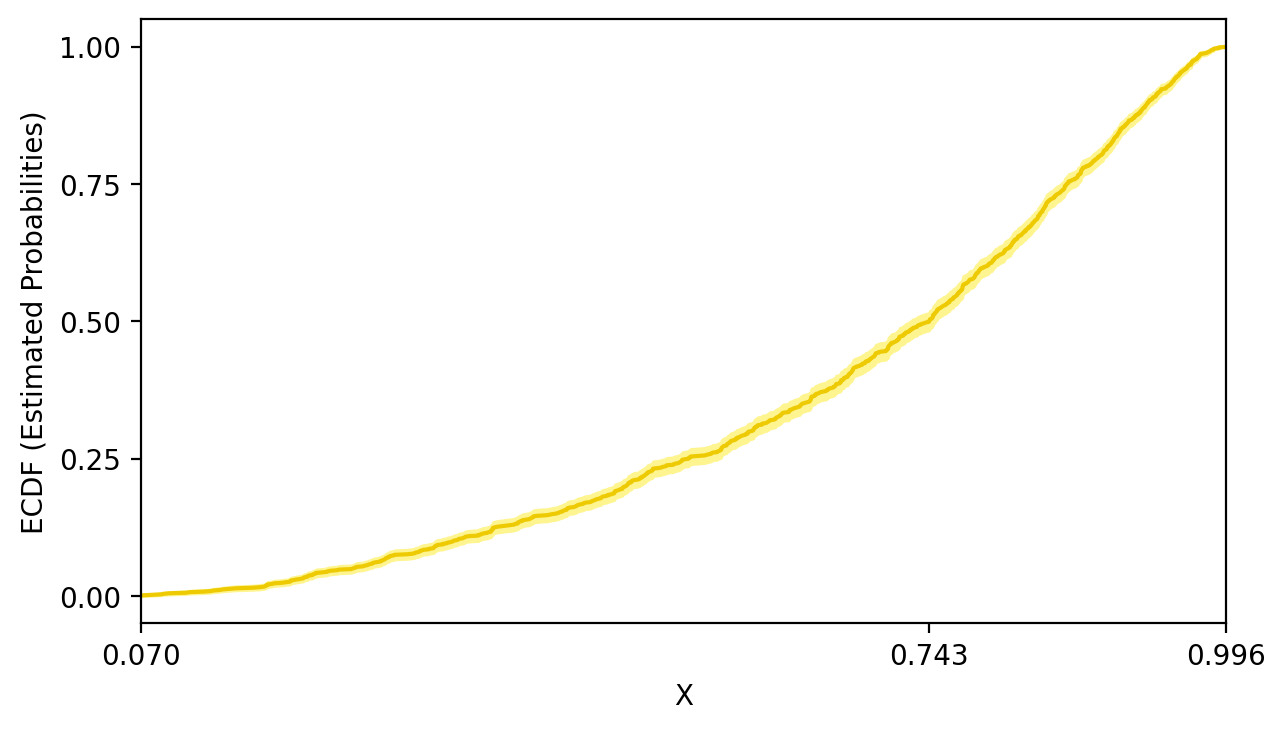

In [20]:
fig_logit_ecdf

## Example 3 - heavy tailed distribution with undefined mean and variance

In the next series of examples we will be considerning Student's t probability density function,

$$
\pi(x ; \nu) =
\frac{1}{ \sqrt{\pi \, \nu } }
\frac{\Gamma(\frac{\nu + 1}{2})}
{ \Gamma(\frac{\nu}{2}) }
\left(1 + \frac{x^2}{\nu} 
\right)^{- \cfrac{\nu + 1}{2}}.
$$

Its expectation and variance are:

$$
\mathbb{E}_\pi[x] = \begin{cases}
    0& \text{for}\ \nu > 1\\
    \text{undefined}& \text{otherwise}                
\end{cases}
$$

$$
\mathbb{V}_\pi[x] = \begin{cases}
    \frac{\nu}{\nu-2}& \text{for}\ \nu > 2\\
    \infty& \text{for}\ \nu (1,2]\\
    \text{undefined}& \text{otherwise}                
\end{cases}
$$


Special case for $\nu=1$ is called the Cauchy distribution
```python
from numpy.random import standard_t
sample_student_inf_variance = standard_t(df = 1.5,size = 1000)
```


## How to sample

```python
from numpy.random import standard_t
sample_cauchy = standard_t(df = 1,size = 1000)
```

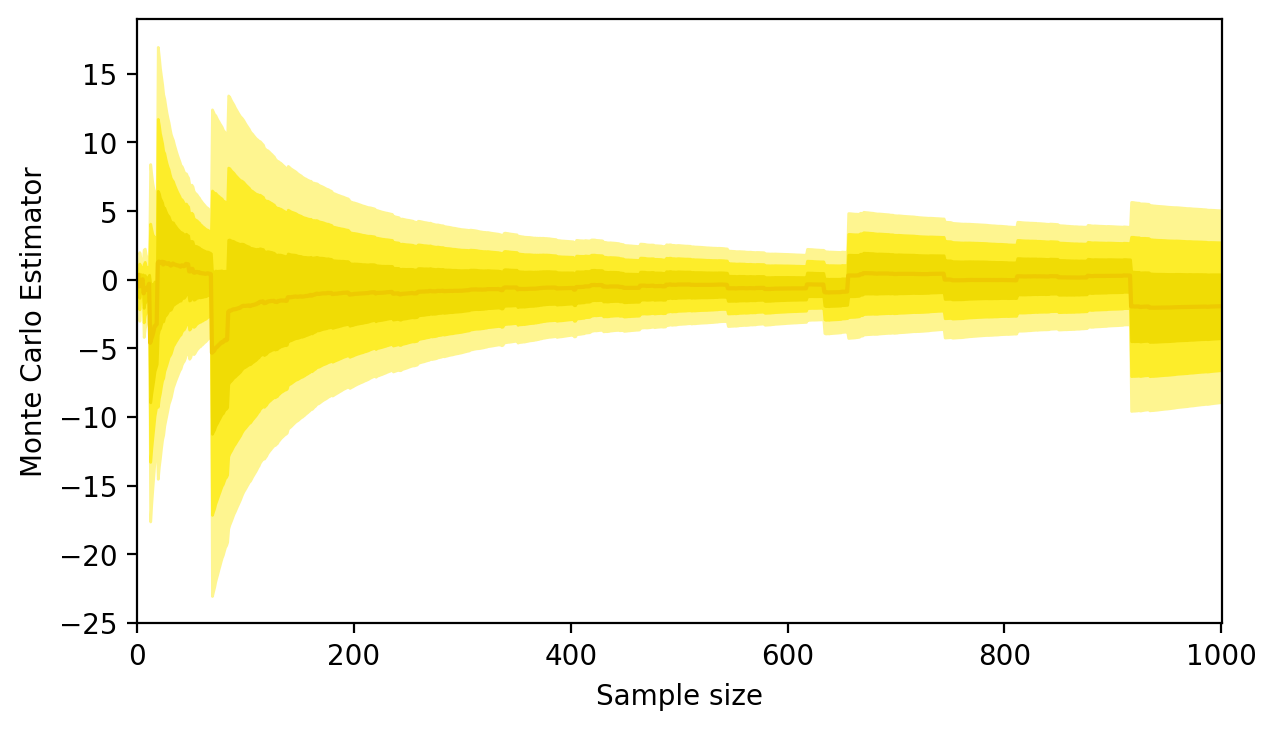

In [21]:
np.random.seed(10052021)
sample_cauchy = standard_t(df = 1,size = 1000)


rolling_mean, rolling_mcse = rolling_stats(sample_cauchy)

fig_rolling_cauchy,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

## Expectation of Cauchy samples behaves weirdly

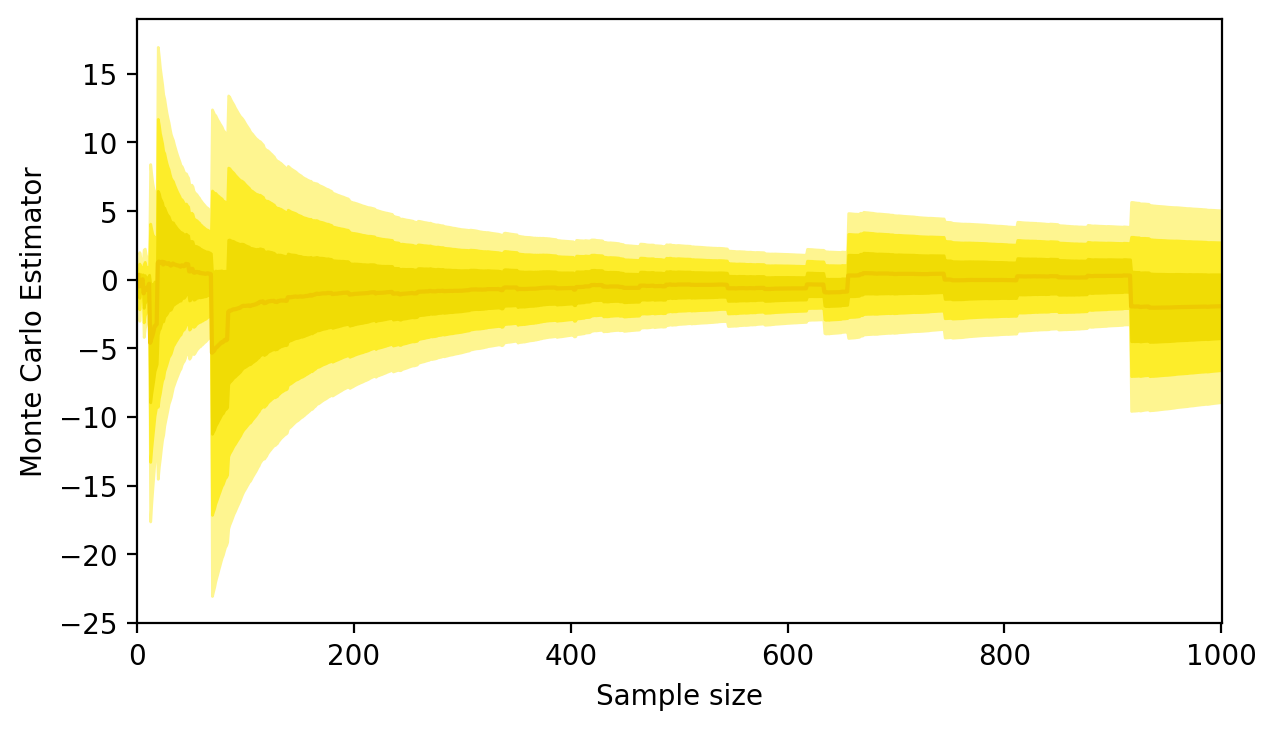

In [22]:
fig_rolling_cauchy

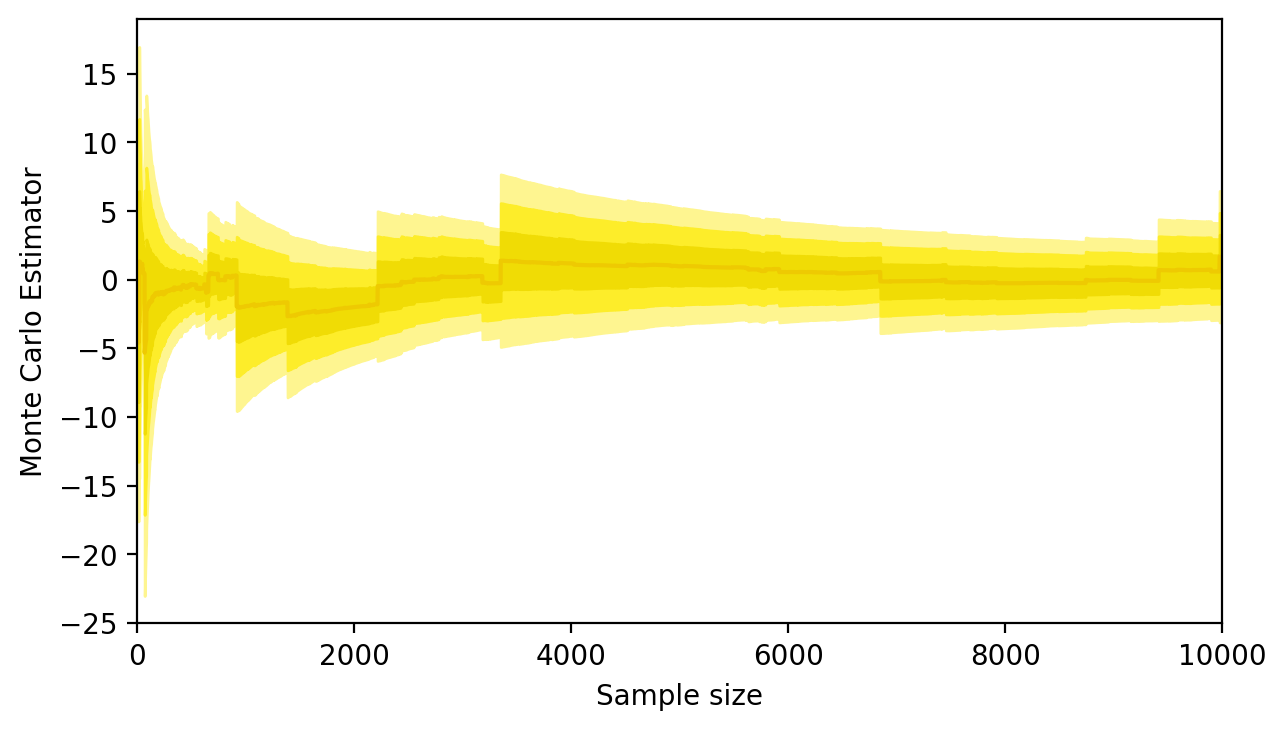

In [23]:
sample_cauchy_long = np.hstack((sample_cauchy,standard_t(df = 1,size = 9000)))


rolling_mean, rolling_mcse = rolling_stats(sample_cauchy_long)

fig_rolling_cauchy_long,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

## Increase of number of samples does not improve situation

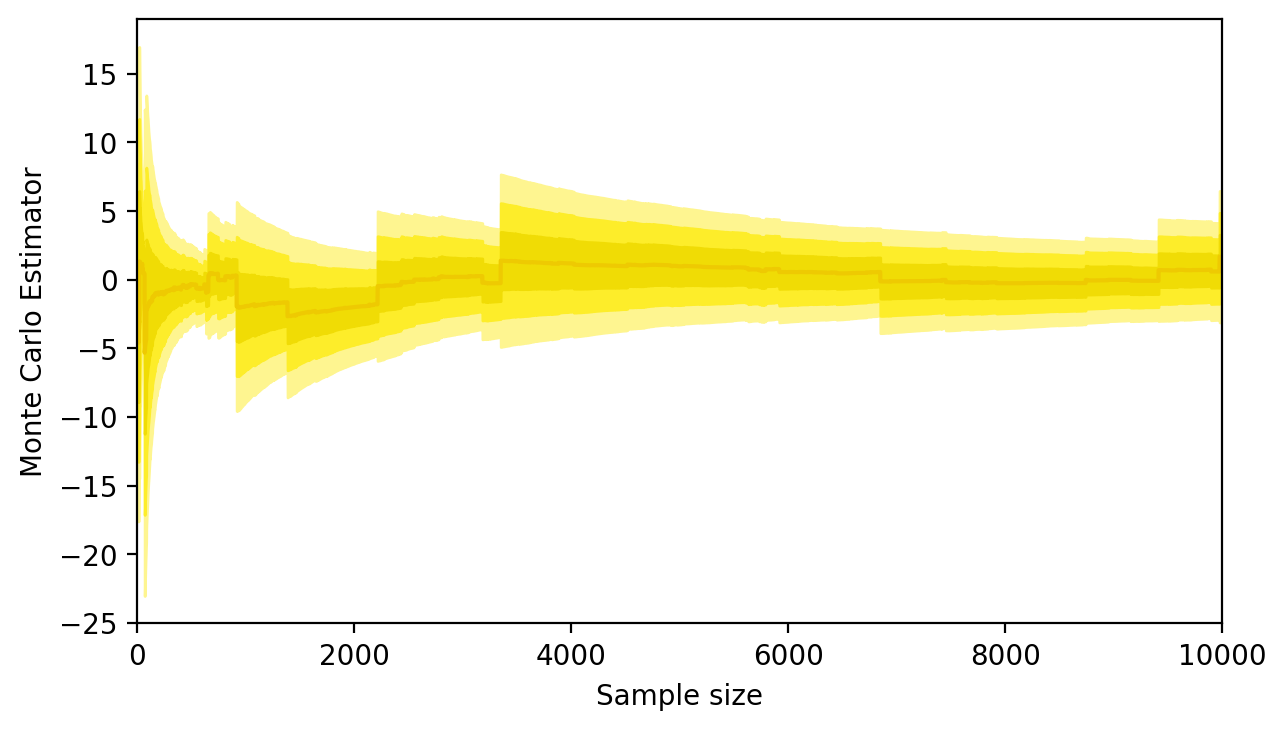

In [24]:
fig_rolling_cauchy_long

In [25]:
N = 1000
R = 10000

mc_delta = np.zeros(R)

for r in range(R):
    sample = standard_t(df = 1,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))


## Does central limit theorem even hold?

Monte Carlo computation is generally based on Central Limit Theorem. If it holds, then the estimator standarized by the Monte Carlo standard error should be normally distributed around true expectation

$$
\frac{ \hat{f}_{N}^{\text{MC}} - \mathbb{E}_{\pi}[f] }
{\text{MC-SE}_{N}[f] } 
\sim \mathcal{N}(0, 1),
$$
So we can analyze multiple samples and analyze histogram of the estimator

```python
for r in range(R):
    sample = standard_t(df = 1,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))
```



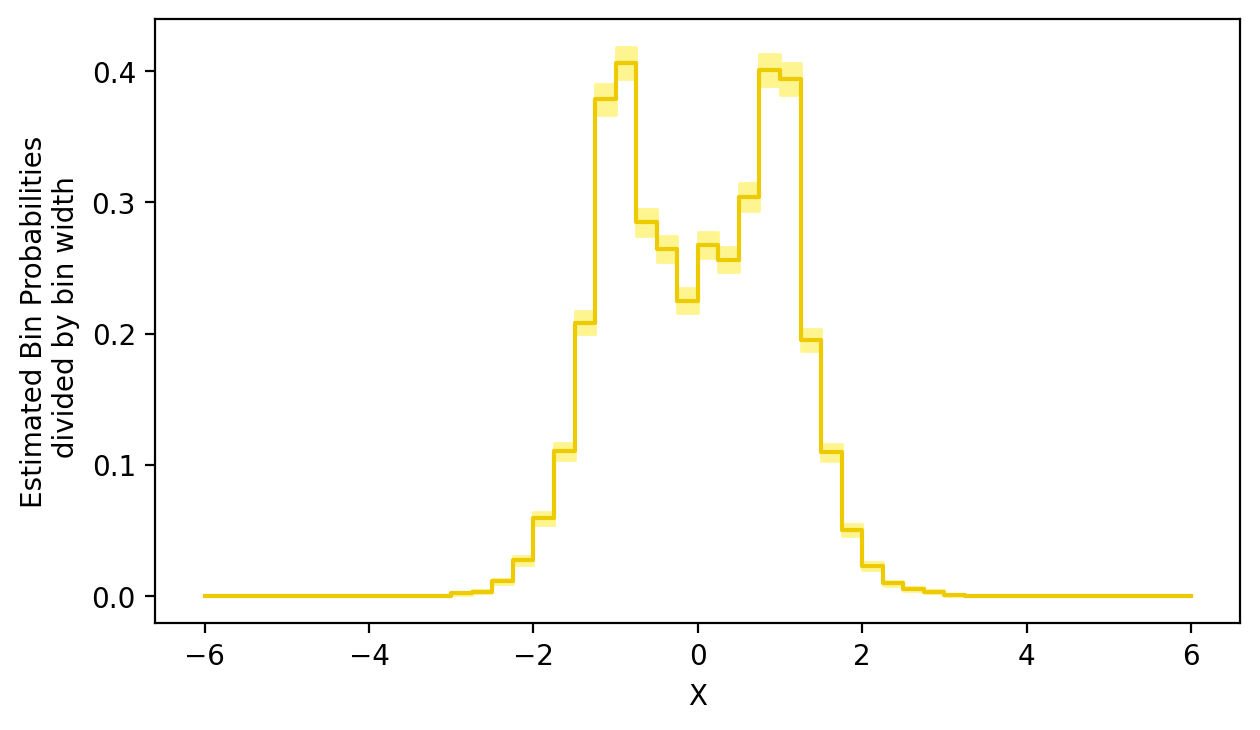

In [26]:
fig_cauchy_estimator,ax = plt.subplots(1,1,figsize = (7,4))

new_bins, probs,mc_se = mc_hist(mc_delta,np.linspace(-6,6,49))
ax = mc_hist_plot(new_bins, probs,mc_se,scale=True,ax=ax)

## That's not normal!

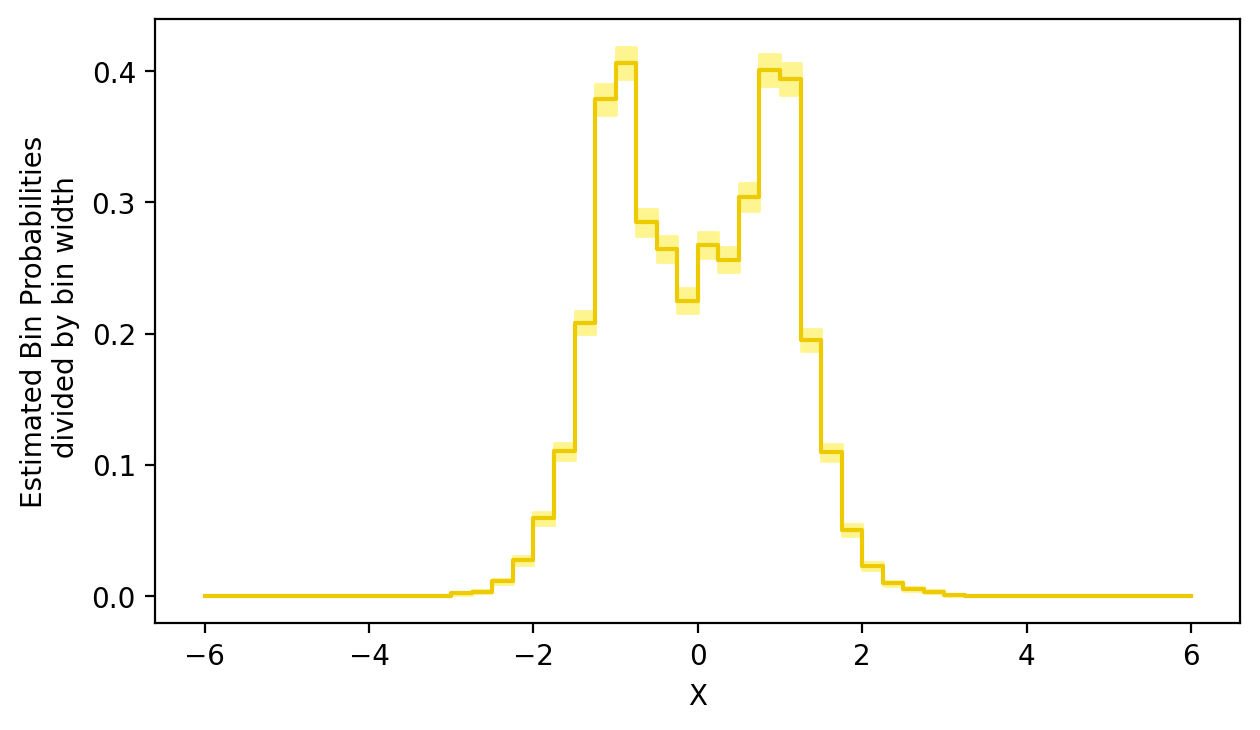

In [27]:
fig_cauchy_estimator

## Are such distributions useless?

Probabilities are still well defined. Let us consider a pushforward for an indicator function of $(-1,0)$ interval.

```python
indicator = lambda x: 1 if (x>-1 and x<0) else 0
sample_pushforward = np.vectorize(indicator)(sample_cauchy)
```


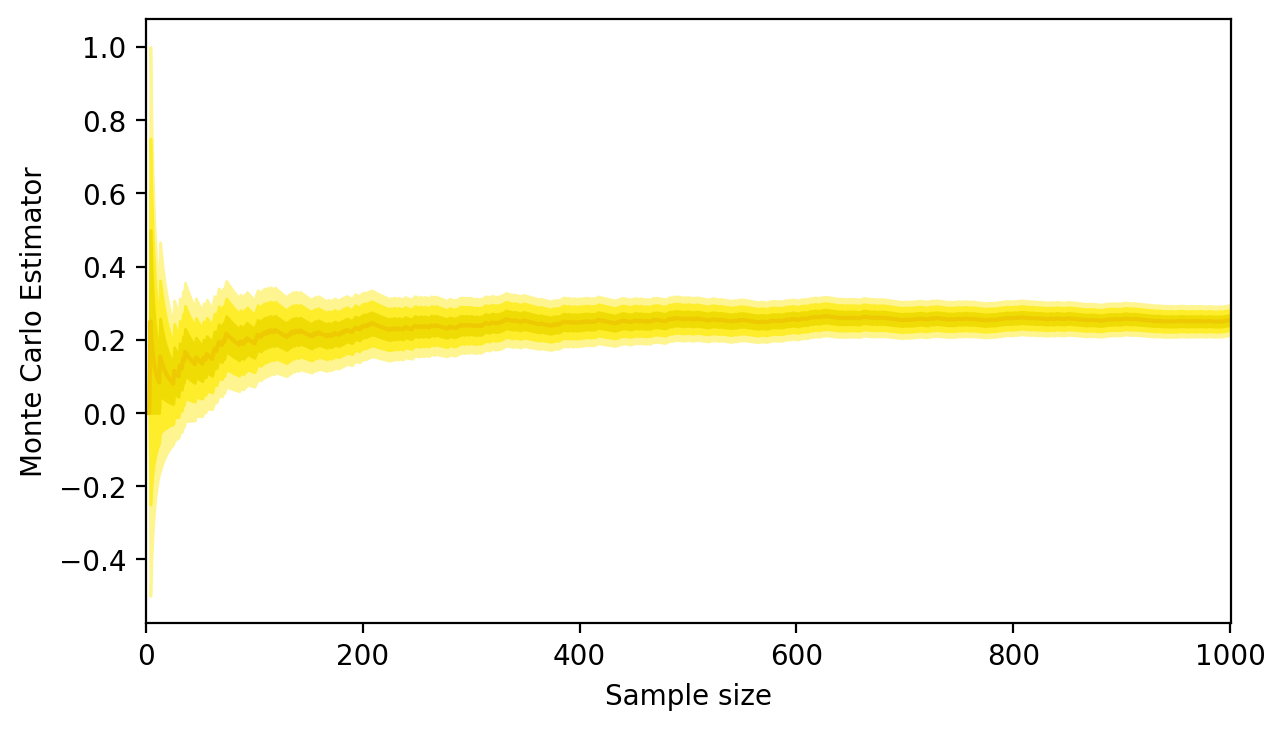

In [28]:
indicator = lambda x: 1 if (x>-1 and x<0) else 0
sample_pushforward = np.vectorize(indicator)(sample_cauchy)

rolling_mean, rolling_mcse = rolling_stats(sample_pushforward)

fig_rolling_prob,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()


## Probability is well behaved

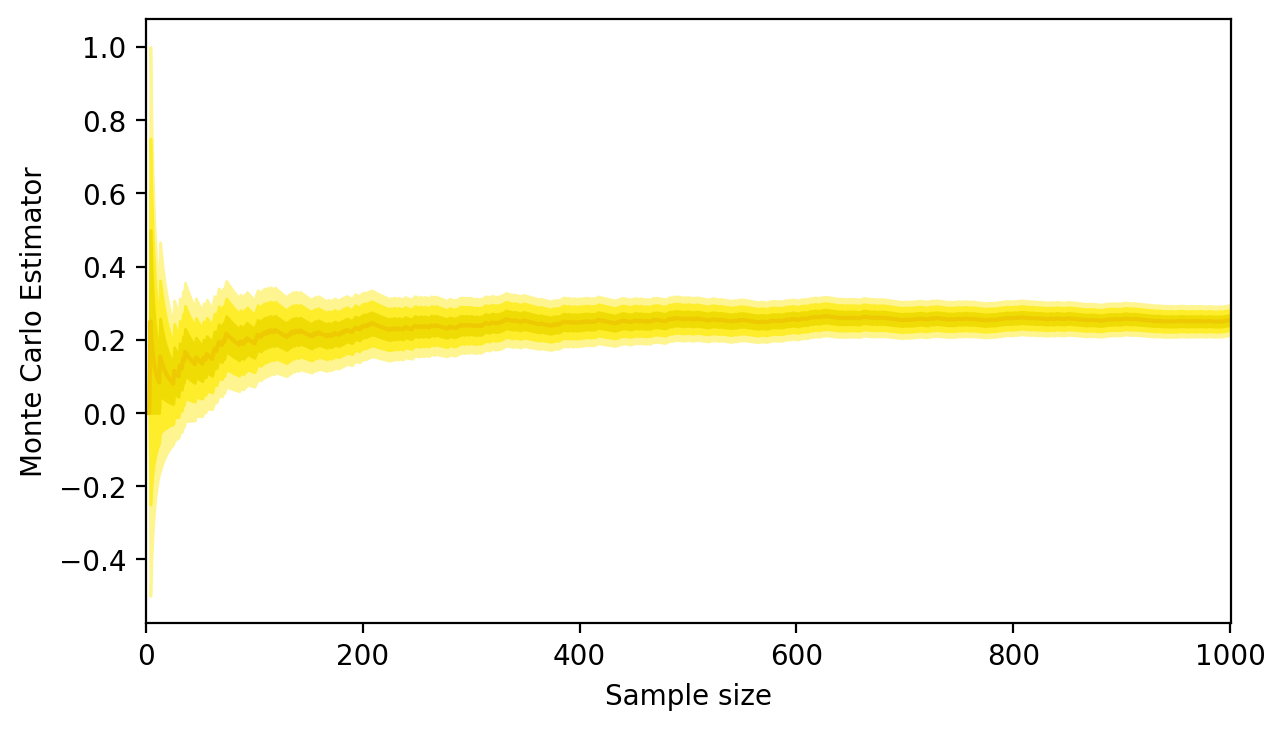

In [29]:
fig_rolling_prob

In [30]:
prob_stats = pd.DataFrame({'MC_Est':rolling_mean[-1],'MCSE':rolling_mcse[-1]},index=['Indicator'])


## Errors are also well quantified

In [31]:
prob_stats

MC_Est      MCSE
Indicator   0.253  0.013754

## Example 4 - infinite variance

We continue with Student-t distribution, but this time with well defined mean
```python
sample_student_inf_variance = standard_t(df = 1.5,size = 1000)
```

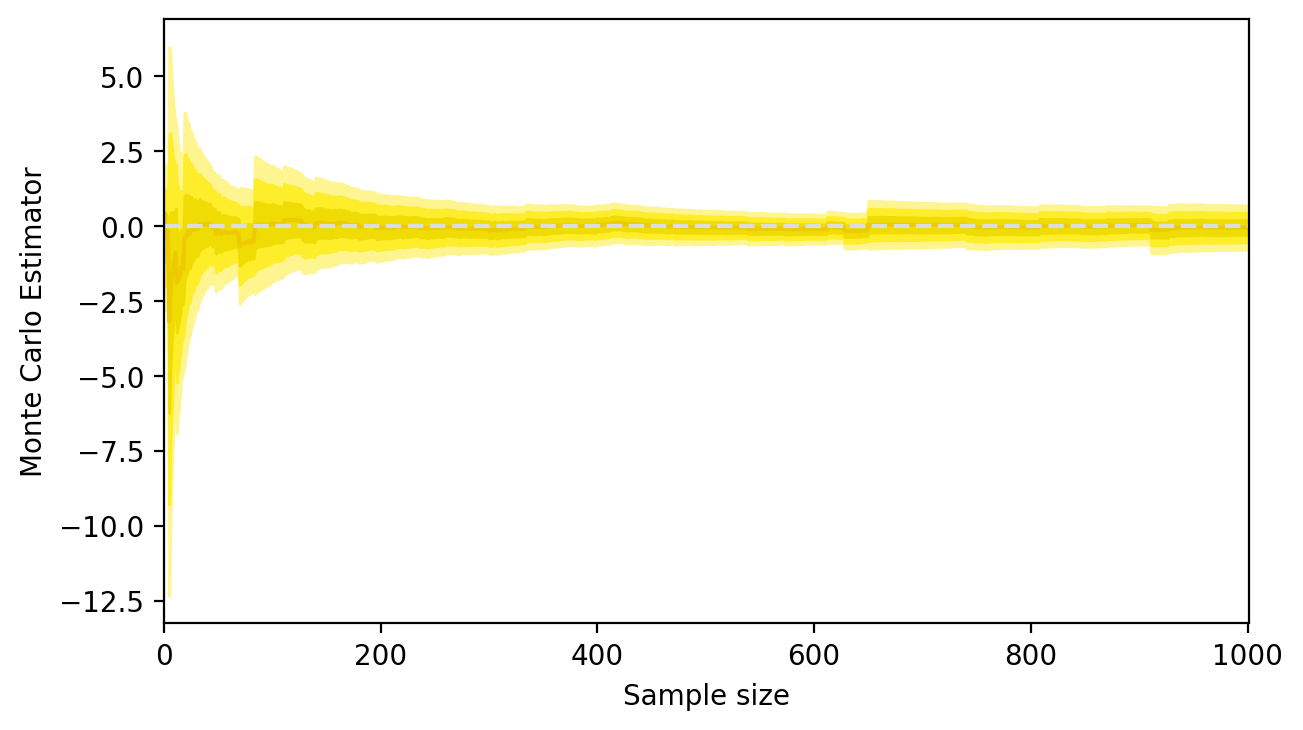

In [32]:
np.random.seed(10052021)


sample_student_inf_variance = standard_t(df = 1.5,size = 1000)


rolling_mean, rolling_mcse = rolling_stats(sample_student_inf_variance)

fig_rolling_inf_variance,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
ax.plot([1,1000],[0,0],color=LIGHT_GREY,linestyle='--')
plt.show()

## Infinite variance of distribution causes jumps in the uncertianity

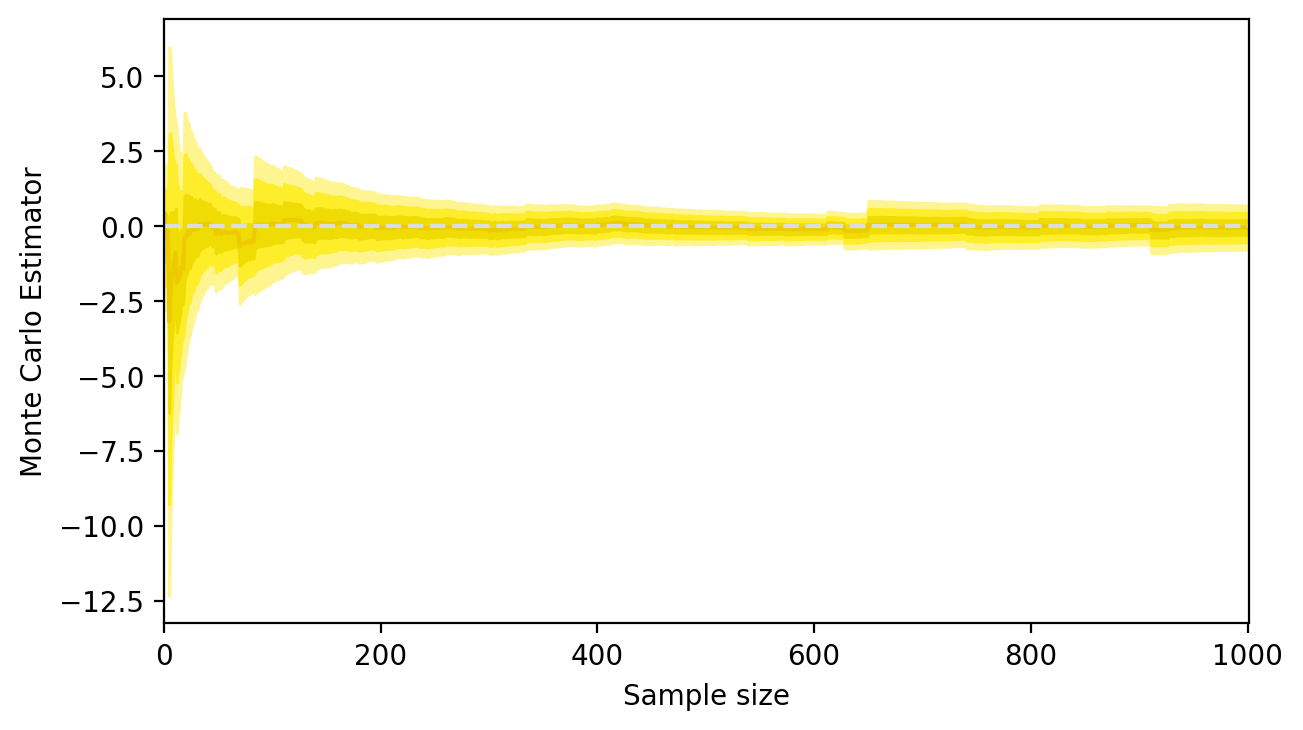

In [33]:
fig_rolling_inf_variance

In [34]:
N = 1000
R = 10000

mc_delta = np.zeros(R)

for r in range(R):
    sample = standard_t(df = 1.5,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))

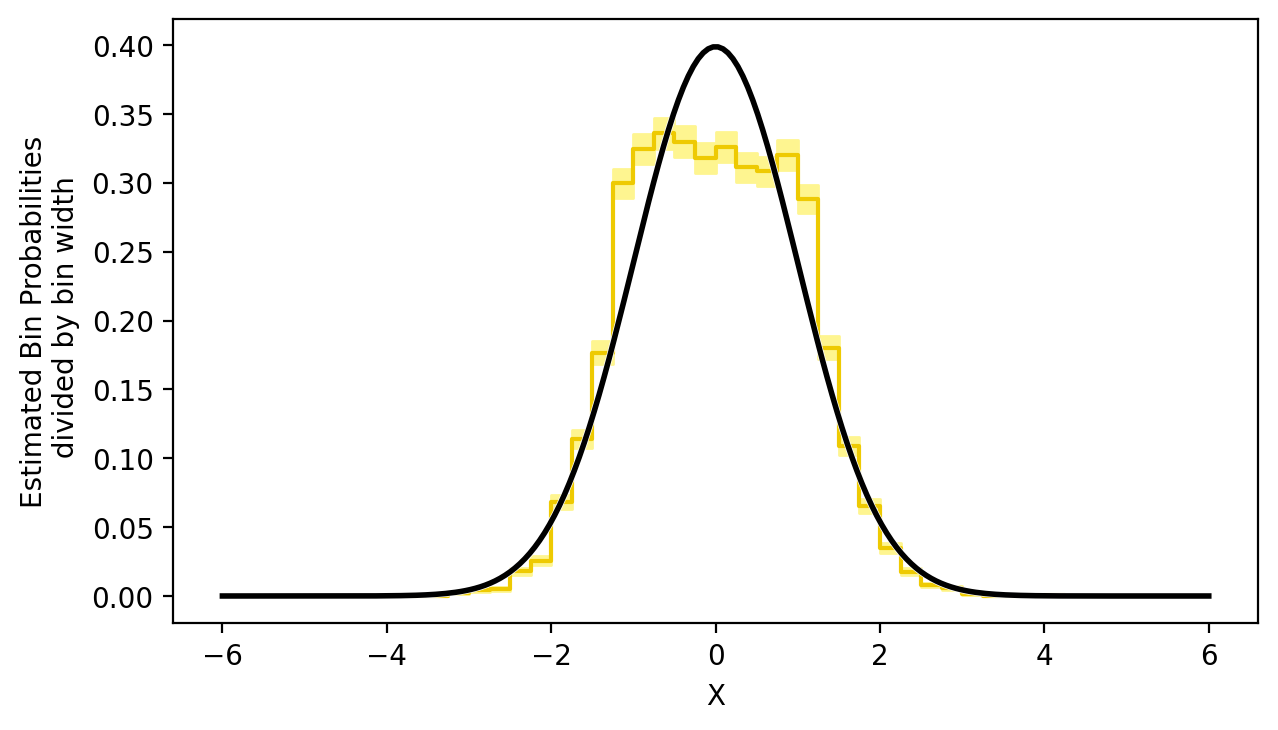

In [35]:
new_bins, probs,mc_se = mc_hist(mc_delta,np.linspace(-6,6,49))
fig_estimator_inf_variance,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_hist_plot(new_bins, probs,mc_se,scale=True,ax=ax)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='white',linewidth=2.5)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='black',linewidth=2)

## Not normal - Error quantification is unreliable

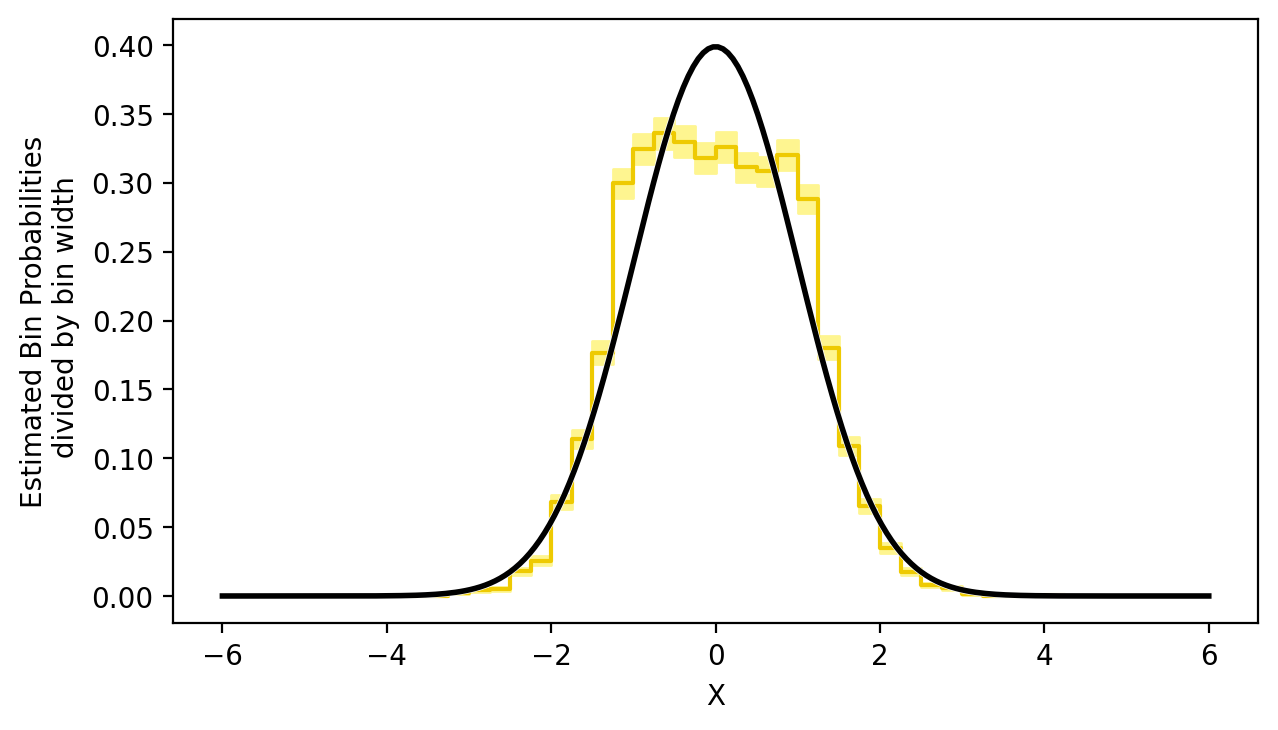

In [36]:
fig_estimator_inf_variance

## Example 5 - well behaved mean and variance

We conclude with Student-t distribution with 3 degrees of freedom
```python
sample_student = standard_t(df = 3,size = 1000)
```

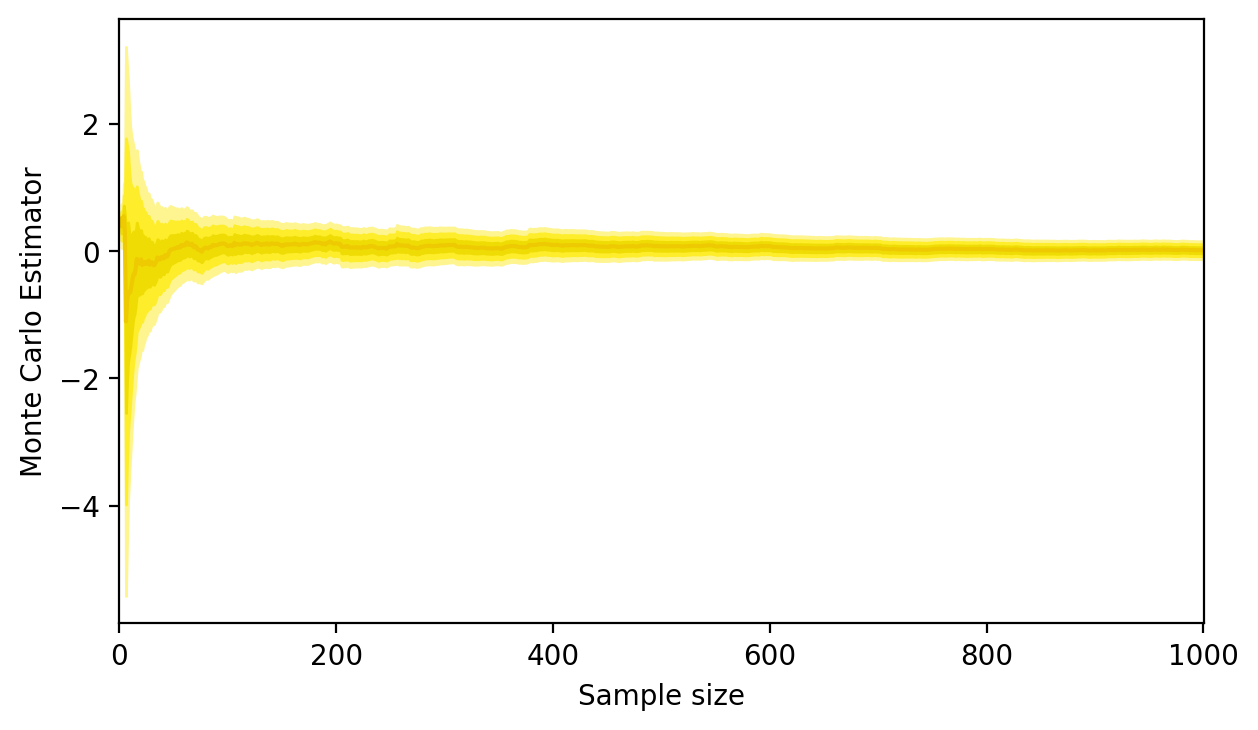

In [37]:
sample_student = standard_t(df = 3,size = 1000)


rolling_mean, rolling_mcse = rolling_stats(sample_student)

fig_rolling_student,ax = plt.subplots(1,1,figsize = (7,4))
ax = mc_plot(rolling_mean, rolling_mcse,ax)
plt.show()

## Estimator behaves reasonably

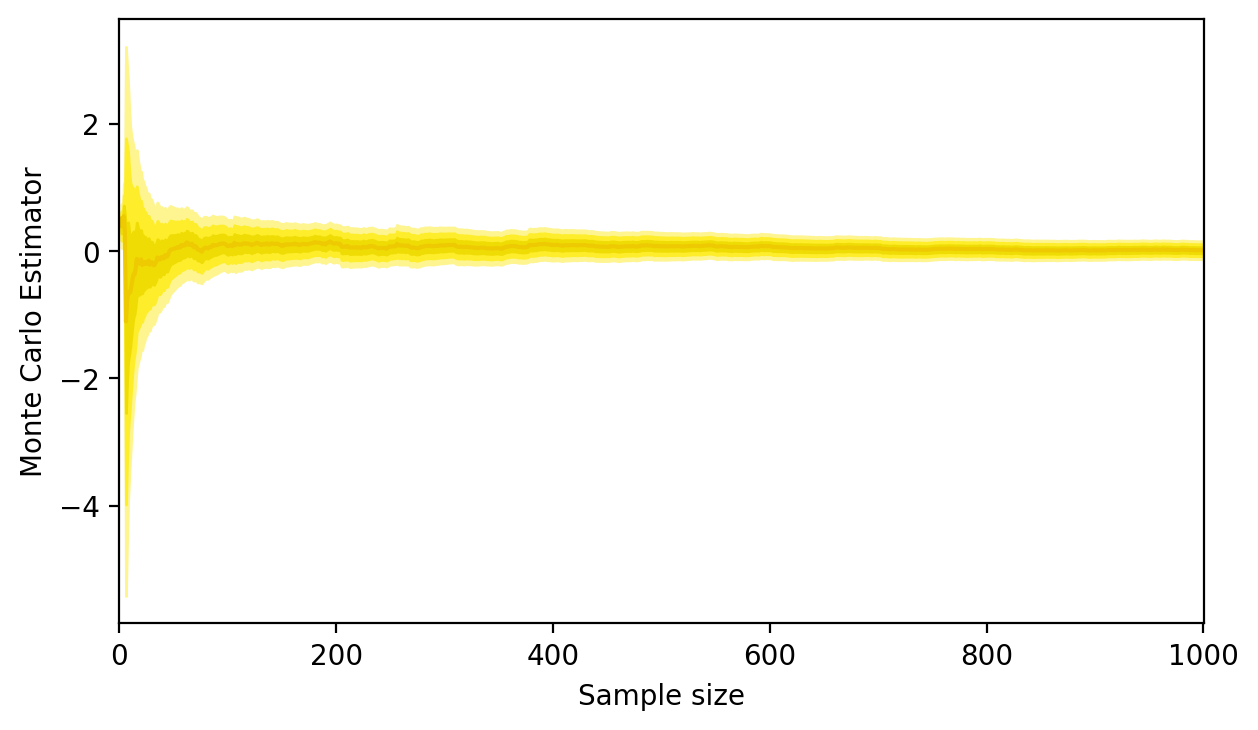

In [38]:
fig_rolling_student

In [39]:
N = 1000
R = 10000

mc_delta = np.zeros(R)

for r in range(R):
    sample = standard_t(df = 3,size = N)
    mc_delta[r] = np.mean(sample)/(np.std(sample)/np.sqrt(N))

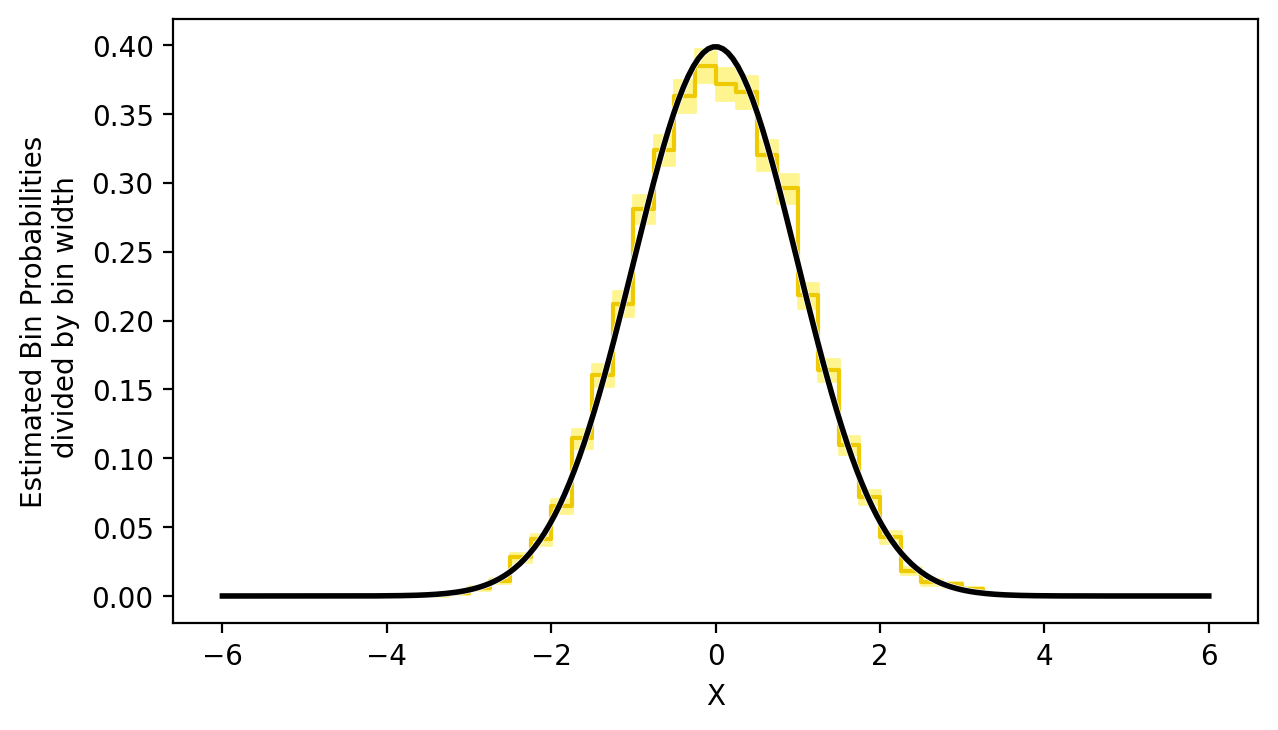

In [40]:
new_bins, probs,mc_se = mc_hist(mc_delta,np.linspace(-6,6,49))
fig_estimator_student,ax = plt.subplots(1,1,figsize = (7,4))

ax = mc_hist_plot(new_bins, probs,mc_se,scale=True,ax=ax)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='white',linewidth=2.5)
ax.plot(np.linspace(-6,6,200),stats.norm.pdf(np.linspace(-6,6,200)),color='black',linewidth=2)

## We can empirically confirm central limit theorem

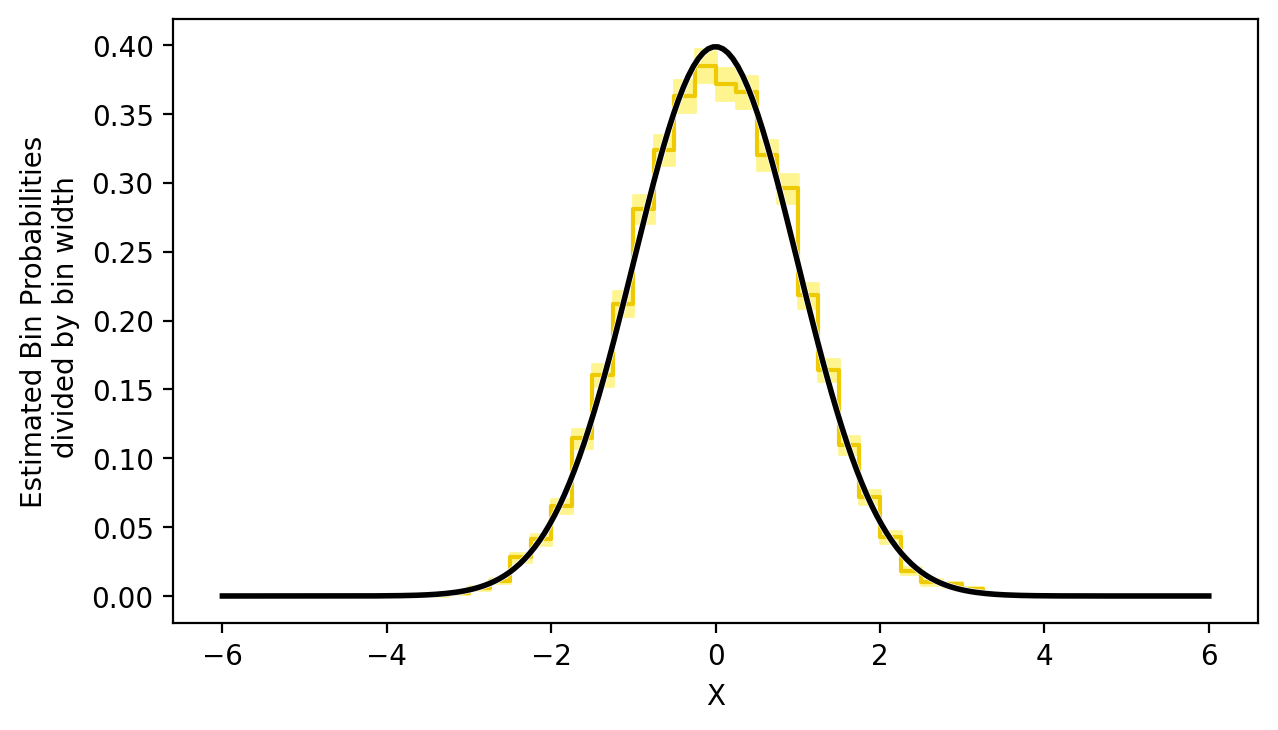

In [41]:
fig_estimator_student

## Quantifying tail behavior

Generalized Pareto distribution

$$
\pi(x) = \begin{cases}
\frac{1}{\sigma}(1 - \frac{k}{\sigma} z)^{\frac{1}{k}-1} & \text{for }k \neq 0, \\
\frac{1}{\sigma}e^{-x/\sigma} & \text{for }k = 0.
\end{cases}
$$

It is a good model for extreme values, in particular it is widely used to determine if samples come from 'heavy tailed' distribution.

## $\hat{k}$ as a test function
We use a point estimator $\hat{k}$ (by Zhang and Stephens) as a check for problems. We fit $\hat{k}$ for tail of each distribution. 

As a rule of thumb: 
- Tails with $\hat{k}>0.7$ it is really problematic
- $\hat{k} <0.25$ is a sensible threshold 

In [42]:
from math import floor
def k_hat (x):
    N = len(x)
    x = np.array(sorted(x))
    if x[0]<=0:
        raise ValueError('x must be positive')
    q = x[floor(0.25*N+0.5)-1]
    M = 20 + floor(np.sqrt(N))
    b_hat_vec = np.zeros(M)
    log_w_vec = np.zeros(M)

    for m in range(M):
        b_hat_vec[m] = 1 / x[-1] + (1 - np.sqrt(M / (m + 0.5))) / (3 * q)
        k_hat = - np.mean(np.log(1-b_hat_vec[m]*x))
        log_w_vec[m] = N*(np.log(b_hat_vec[m]/k_hat)+k_hat-1)
    max_log_w = np.max(log_w_vec)
    b_hat = np.sum(b_hat_vec*np.exp(log_w_vec-max_log_w))/np.sum(np.exp(log_w_vec-max_log_w))
    return np.mean(np.log(1-b_hat*x))

## We split distribution into tails

In [43]:
def tail_khats(x):
    x_center = np.median(x)
    if (x_center==np.min(x) or x_center==np.max(x)):
        return (0,0)
    x_left = np.abs(x[x<=x_center]-x_center)
    x_right = x[x>=x_center]-x_center

    return k_hat(x_left),k_hat(x_right)

In [44]:
tail_khats(sample_student)

index = ['Cauchy - small sample','Cauchy', 'Student-T - nu=1.5', 'Student-T - nu=3','Normal']

samples = [sample_cauchy,sample_cauchy_long,sample_student_inf_variance,sample_student,sample_normal]
left = [tail_khats(x)[0] for x in samples]
right = [tail_khats(x)[1] for x in samples]
khat_summary = pd.DataFrame({'Left Tail khat':left,'Right Tail khat':right},index=index)

In [45]:
khat_summary

Left Tail khat  Right Tail khat
Cauchy - small sample        0.849733         0.764180
Cauchy                       0.753889         0.770996
Student-T - nu=1.5           0.478854         0.470341
Student-T - nu=3             0.003987         0.060753
Normal                      -0.357888        -0.216074

## Main takeaways

- Monte Carlo sampling, as long as distribution is well posed offers valuable estimates and error quantification
- Any probability estimate has its own error
- If samples are not consistent or distribution lacks necessary moments issues can happen
- There are possible diagnostics of tail behavior that can lead to useful guidelines
- Multidimensional sampling requires more tools -> MCMC 


## Extra reading

- Much more about sampling and further examples and deeper theory can be found in [Rumble in the ensemble](https://betanalpha.github.io/assets/case_studies/sampling.html) by Michael Betancourt
- $\hat{k}$ estimator - Zhang, J. and Stephens, M. A. (2009). A new and efficient estimation method for the generalized pareto distribution. Technometrics 51 316–25.
- Mersenne Twister - Matsumoto, M. and Nishimura, T. (1998). Mersenne twister: A 623-dimensionally equidistributed uniform pseudo-random number generator. ACM Trans. Model. Comput. Simul. 8 3–30. [Also wikipedia](https://en.wikipedia.org/wiki/Mersenne_Twister)

In [46]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
# from matplotlib.colors import to_hex
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

from numpy.random import normal

# Advanced Statistical Modelling and Data Analysis



## Probabilistic computation - Markov Chain Monte Carlo

### dr hab. inż. Jerzy Baranowski, Prof. AGH

## Markov Chains

_Markov transition distribution_ is a conditional probability density function
within a given parameterization of the parameter space Q:

$$
\begin{aligned}
T :\; &Q \times Q& &\rightarrow& \; &\mathbb{R}^{+}&
\\
&(q, q')& &\mapsto& &T(q' \mid q)&.
\end{aligned}
$$



## Example - 2 dimensional space 
$$
\begin{aligned}
T(q_{1} \mid q_{0} )
&=
T(q^{1}_{1}, q^{2}_{1} \mid q^{1}_{0}, q^{2}_{0} )
\\
&=
T(q^{1}_{1} \mid q^{1}_{0}) \cdot
T(q^{2}_{1} \mid q^{2}_{0}).
\\
&=
\text{Normal}(q^{1}_{1} \mid q^{1}_{0}, \sigma) \cdot
\text{Normal}(q^{2}_{1} \mid q^{2}_{0}, \sigma).
\end{aligned}
$$

In [95]:
q0 = np.array([0,0])
n_possible = 50
sigma = 1
np.random.seed(28052021)
possible_qs = normal(loc=q0,scale=np.array([sigma, sigma]),size=(n_possible,2))

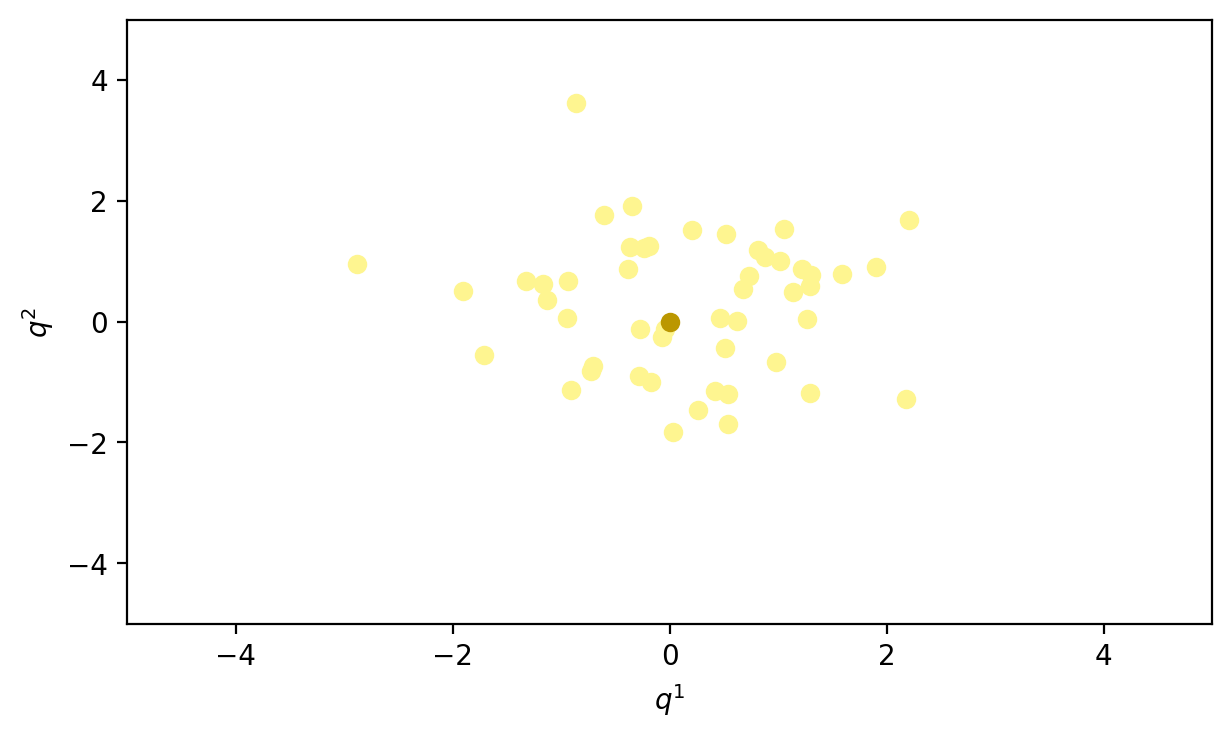

In [96]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs[:,0],possible_qs[:,1],c=light_highlight)
ax.scatter(q0[0],q0[1],c=dark_highlight)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
fig.savefig('test.eps', format='eps', dpi=600)

## Possible transitions from initial point

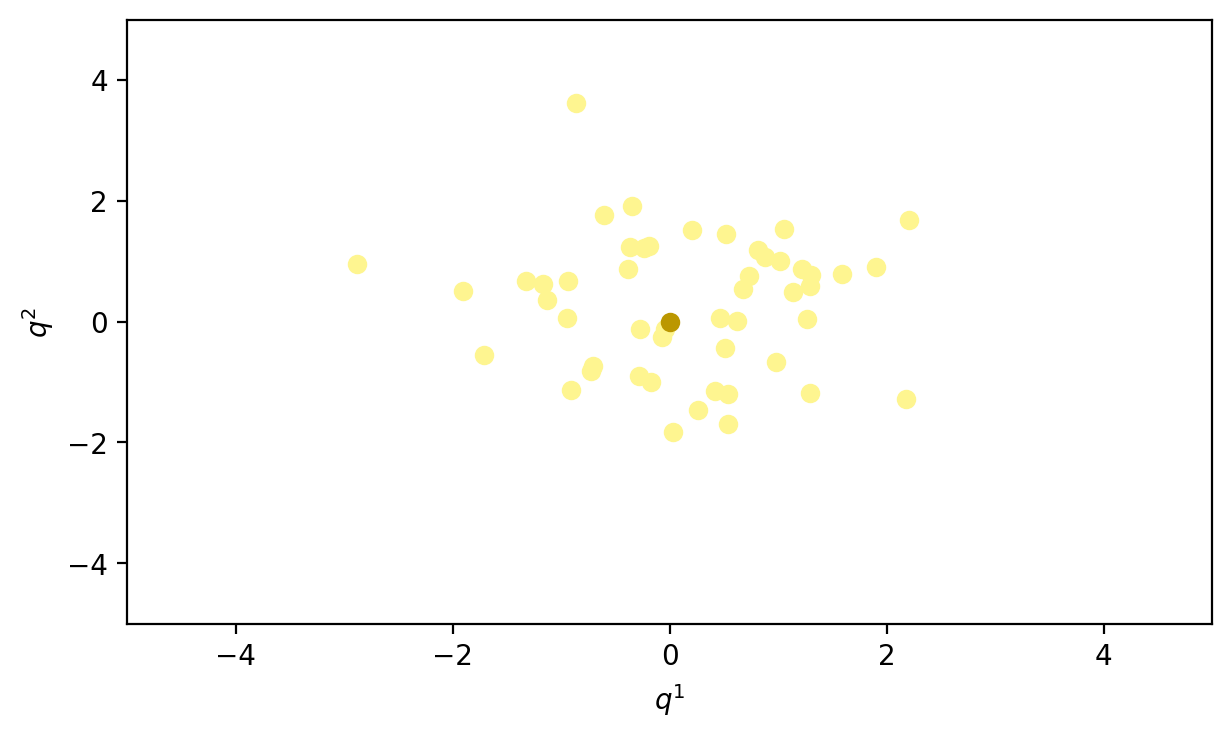

In [97]:
fig

(-5.0, 5.0)

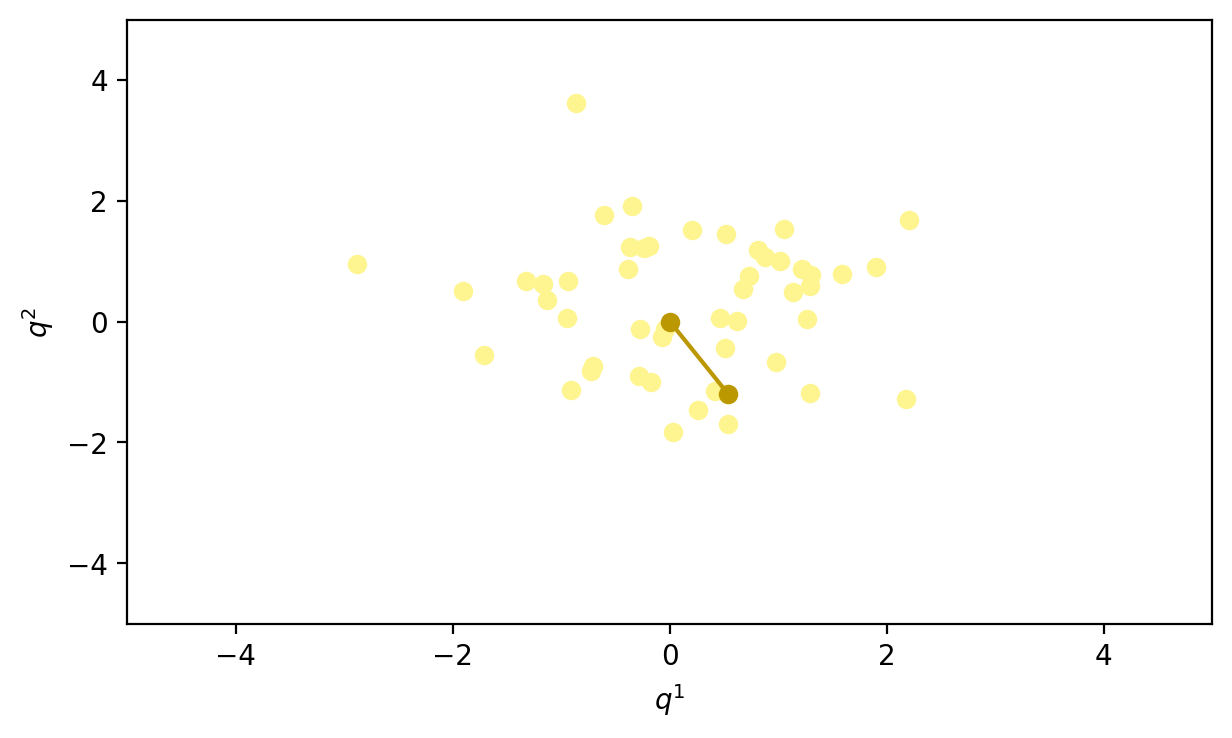

In [50]:
q_1 = possible_qs[0,:]

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs[:,0],possible_qs[:,1],c=light_highlight)
ax.plot([q0[0],q_1[0]],[q0[1],q_1[1]],c=dark_highlight)
ax.scatter([q0[0],q_1[0]],[q0[1],q_1[1]],c=dark_highlight)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))

## Realized transition from initial point

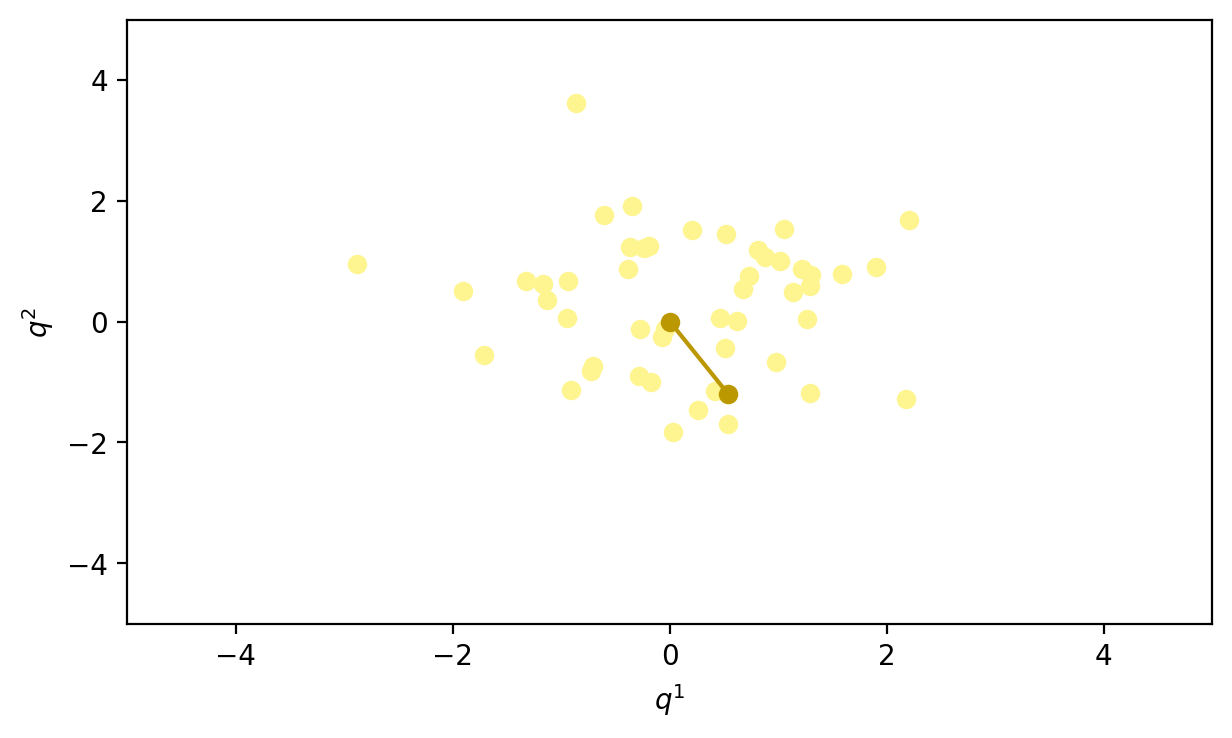

In [51]:
fig

(-5.0, 5.0)

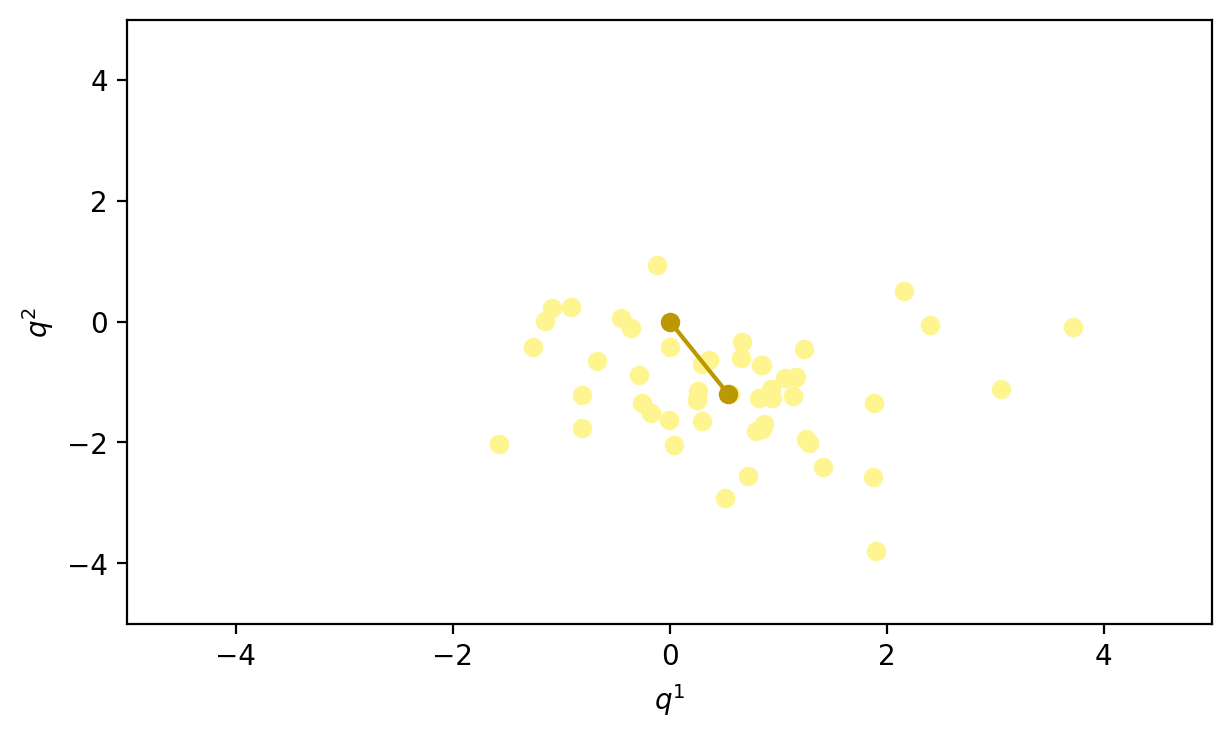

In [52]:
possible_qs = normal(loc=q_1,scale=np.array([sigma, sigma]),size=(n_possible,2))
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs[:,0],possible_qs[:,1],c=light_highlight)
ax.plot([q0[0],q_1[0]],[q0[1],q_1[1]],c=dark_highlight)
ax.scatter([q0[0],q_1[0]],[q0[1],q_1[1]],c=dark_highlight)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))

## Possible transitions from first transition

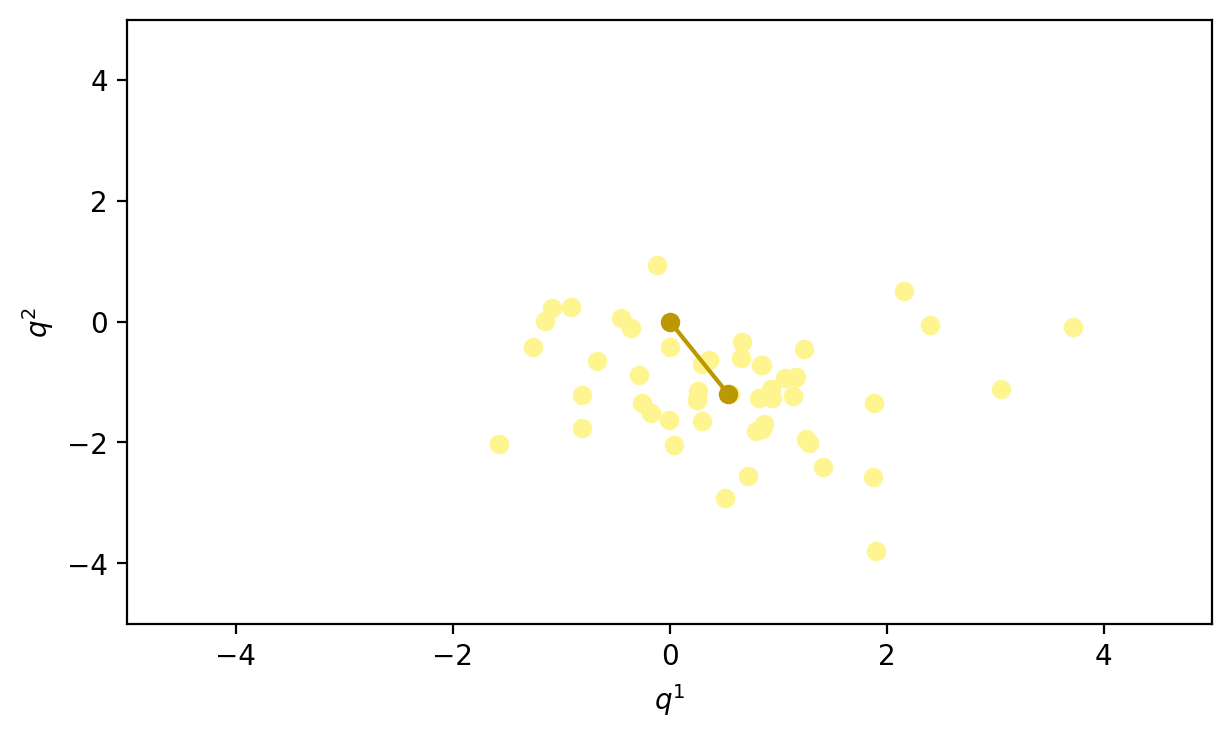

In [53]:
fig

(-5.0, 5.0)

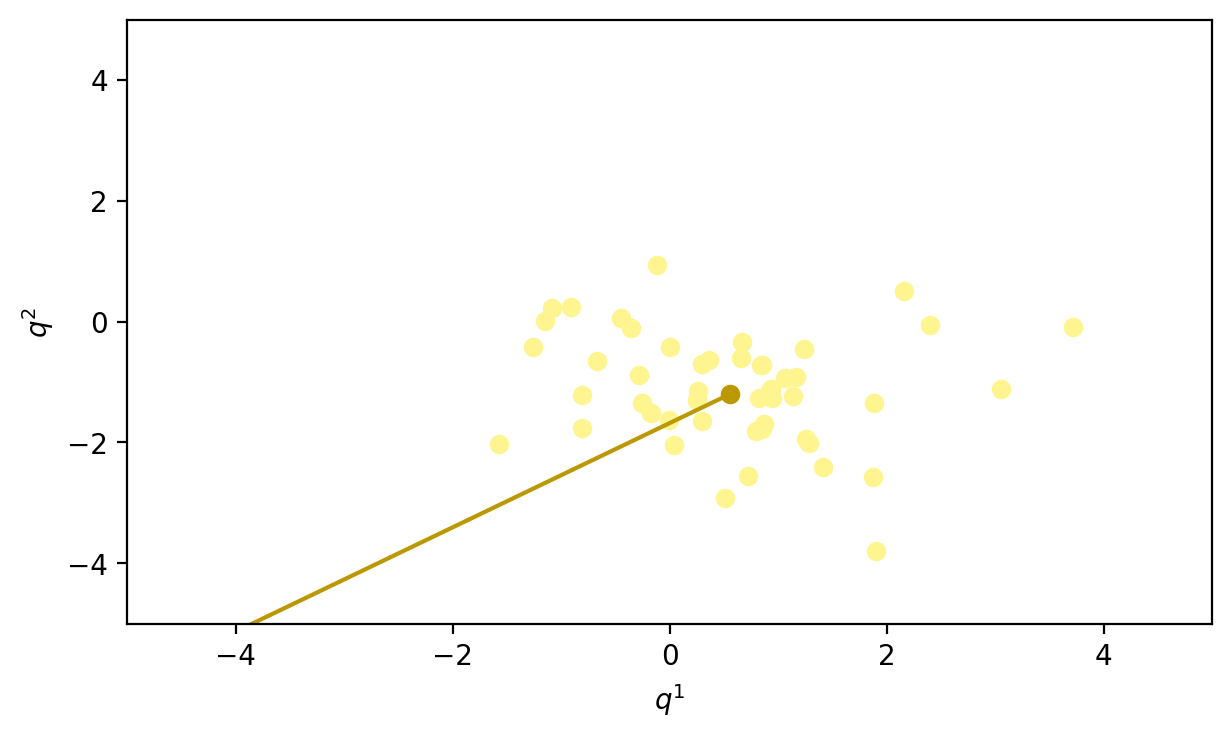

In [94]:
q_2=possible_qs[0,:]
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs[:,0],possible_qs[:,1],c=light_highlight)
ax.plot([q0[0],q_1[0],q_2[0]],[q0[1],q_1[1],q_2[1]],c=dark_highlight)
ax.scatter([q0[0],q_1[0],q_2[0]],[q0[1],q_1[1],q_2[1]],c=dark_highlight)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))

## Realized transition from first transition

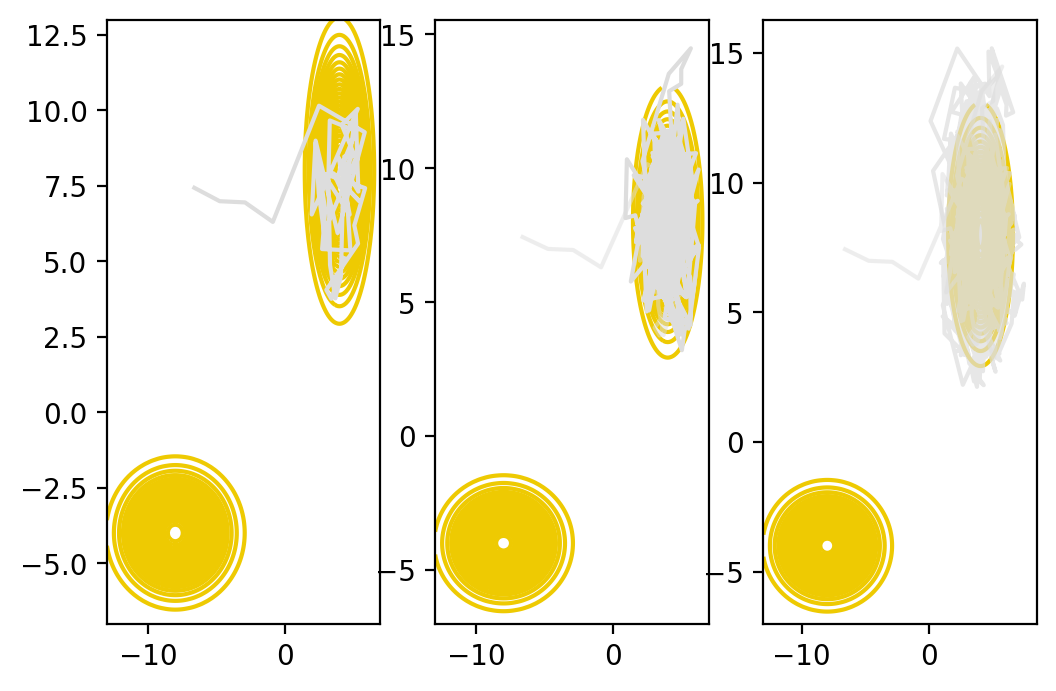

In [93]:
fig

## Markov Chain

_Iterating_ Markov transitions,
$$
\begin{aligned}
\tilde{q}_{1} &\sim T(q_{1} \mid q_{0})
\\
\tilde{q}_{2} &\sim T(q_{2} \mid \tilde{q}_{1})
\\
\tilde{q}_{3} &\sim T(q_{3} \mid \tilde{q}_{2})
\\
\ldots
\\
\tilde{q}_{N} &\sim T(q_{N} \mid \tilde{q}_{N - 1}),
\end{aligned}
$$
generates a sequence of points in the ambient space that we call a
_Markov chain_.


## Main point - stationary distribution

A probability distribution that is
preserved under Markov transitions,
$$
\pi(q) = \int \mathrm{d} q' \, \pi(q') \, T(q \mid q'),
$$
is known as the _stationary_ or _invariant_ distribution of the Markov
transition distribution.

Well-behaved Markov transition distributions admit a
unique stationary distribution, and it is within the ***stationary typical set***
that the Markov chains are most likely to wonder.

## Markov chain converges towards typical set of distribution

<img src="img/short.png" alt="drawing" width="500"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## After reaching it it explores it

<img src="img/long.png" alt="drawing" width="500"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## MCMC estimators

MCMC estimators are analogous to MC ones

$$
\hat{f}^{MCMC}_N = \frac{1}{N} \sum_{n=1}^{N}f(q_n)
$$

As long as Markov chains are _irreducible_ and _aperiodic_ they are _recurrent_, which ensures asymptotical consistency:

$$
\lim_{N\rightarrow\infty}\hat{f}^{MCMC}_N = \mathbb{E}_\pi[f]
$$

## What about finite sample behavior?

The ideal case

<img src="img/ideal/setup.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Initial convergence


<img src="img/ideal/convergence.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Initial mixing

<img src="img/ideal/initial_mixing.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Refining


<img src="img/ideal/asymptotic_mixing.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Complications with geometry

Typical set can be very irregular

<img src="img/funnel/pinch.png" alt="drawing" width="500"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Initial exploration can be ok

<img src="img/funnel/initial.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Approaching difficult shapes complicates transitions


<img src="img/funnel/freeze.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Even escaping irregularities can lead to biases

<img src="img/funnel/final.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Problems with multimodality

<img src="img/multimode/setup.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## One mode can draw the Markov chain

<img src="img/multimode/initial.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Initial exploration might look as the equlibrum

<img src="img/multimode/final.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Markov Chain Monte Carlo Central Limit Theorem

For sufficiently long Markov chains estimator behavior is approximately Gaussian
$$
\hat{f}^{\text{MCMC}}_{N} \sim \text{normal}( \mathbb{E} [f], \text{MCMC-SE}[f] ),
$$
where the _Markov chain Monte Carlo standard error_ is defined as
$$
\begin{aligned}
\text{MCMC-SE}[f]
&= \sqrt{ \frac{ \text{Var} [f] }{ \text{ESS}[f] } }
\end{aligned}
$$
$\text{ESS}[f]$ is called the
_effective sample size_.

## Effective sample size

This is the measure of how the Markov chain is autocorrelated with itself. It is given by
$$
\text{ESS}[f] = \frac{N}{1 + 2 \, \sum_{l = 1}^{\infty} \rho_{l}[f]}.
$$

where $\rho_{l}$ are given by


$$
\rho_{l}[f] =
\frac{ \mathbb{E}[ ( f (q_{n + l}) - \mu_{f} ) ( f(q_{n}) - \mu_{f}) ] }
{ \mathrm{Var}_{\pi}[f] },
$$

## Practical ESS Estimator

Finite sums are good approximators, so

$$
\widehat{\mathrm{ESS}}[f] = \frac{N}{1 + 2 \sum_{l = 1}^{L} \hat{\rho}_{l}[f] }.
$$

with 

$$
\hat{\rho}_{l}[f]
=
\frac{ \frac{1}{N} \sum_{n = 0}^{N - l}
( f (q_{n + l}) - \hat{\mu}_{f} ) ( f(q_{n}) -\hat{\mu}_{f}) }
{ \widehat{\mathrm{Var}}[f] },
$$

## ESS interpretation

For independent samples all autocorrelations will vanish and
$$
\sum_{l = 1}^{\infty} \rho_{l}[f] = 0.
$$
In this case $\text{ESS}[f] = N$ and the Markov chain Monte Carlo standard error
reduces to the Monte Carlo standard error.

Positive autocorrelations,
$$
\sum_{l = 1}^{\infty} \rho_{l}[f] > 0,
$$
suppress the effective sample size which in turn increases the Markov chain
Monte Carlo standard error.

Negative autocorrelations,
$$
\sum_{l = 1}^{\infty} \rho_{l}[f] < 0,
$$
actually _enhance_ the effective sample size relative to the total number of
iterations which then _decreases_ the Markov chain Monte Carlo standard error
below the Monte Carlo standard error

## The Estimated Central Limit Theorem

$$
\hat{f} \sim \text{normal}( \mathbb{E} [f], \widehat{\text{MCMC-SE}}[f] ),
$$
where
$$
\widehat{\text{MCMC-SE}}[f] =
\sqrt{ \frac{ \widehat{ \text{Var}} [f] }{ \widehat{\text{ESS}} [ f ] } }
$$

## Looking for stationarity


<img src="img/traces/gauss_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Freezing is bad


<img src="img/traces/funnel_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Too short for comfort


<img src="img/traces/funnel_short_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Multiple modes lead to multiple realizations


<img src="img/traces/gauss_multi_init_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Multiple chains can help with detecting multimodality

<img src="img/traces/gauss_multi_chain_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Multiple chains help finding problems


<img src="img/traces/funnel_multi_chain_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Multichain diagnostics 

***Within chain variance*** $W[f]$ the empirical average of the square of the Markov chain Monte Carlo
standard errors,
$$
\hat{W}[f] = \frac{1}{C} \sum_{c = 1}^{C} (\text{MCMC-SE}_{c}[f])^{2}
$$

***Between chain variance***, $B[f]$, the empirical variance of the
Markov chain Monte Carlo estimators themselves,
$$
\hat{B}[f] = \frac{N}{C - 1} \sum_{c = 1}^{C}
\left( \hat{f}^{\text{MCMC}}_{c, N} - \hat{\hat{f}} \right)^{2},
$$

## $\hat{R}$ - potential scale reduction factor

$$
\hat{R}[f] = \sqrt{ \frac{N - 1}{N}
+ \frac{1}{N} \frac{ \hat{B} [ f ] }{ \hat{W} [ f] } }.
$$
As the ensemble of Markov chains reach the same equilibrium $\hat{R}$ should
approach one. 





## Geweke statistic

Comparison of the Markov chain Monte Carlo estimators derived at the beginning and end of a single Markov chain

$$
G = \frac{
\hat{f}^{\text{MCMC}}_{B, N_{B}}
- \hat{f}^{\text{MCMC}}_{E, N_{E}} }
{ \sqrt{
(\text{MCMC-SE}_{B}[f])^{2} + (\text{MCMC-SE}_{E}[f])^{2}
} }.
$$

$\hat{f}^{\text{MCMC}}_{B, N_{B}}$ denotes the Markov chain Monte Carlo estimator of the function $f$ from the first $N_{B}$
points at the beginning of a Markov chain and 

$\hat{f}^{\text{MCMC}}_{E, N_{E}}$
denotes the estimator from the last $N_{E}$ points

## Split $\hat{R}$

**split potential scale reduction factor**, or split $\hat{R}[f]$, combines
the qualitative features of both diagnostics by generating an ensemble of Markov
chains and then splitting them in half before computing the $\hat{R}$ statistic.
In this way split $\hat{R}$ can capture inconsistencies both between the Markov
chains in the ensemble as well as within each Markov chain.

## Warmup

- Theoretically - after initialization
- Adaptively - use the information from chain to detect
- Heuristically - drop fixed number of iterations

## Metropolis-Hastings algorithm - generating MC with desired stationary distribution $\pi(q)$

1. Let $K(q \mid q')$ be a _proposal distribution_ - we wil generate possible transition from it
2. _Metropolis-Hastings acceptance probability_ between an initial point, $q$,
and a proposal, $q'$:
$$
a(q', q) = \min \left(1,
\frac{ K(q \mid q') \, \pi(q') }{ K(q' \mid q) \, \pi(q) } \right).
$$
3. We can then define a Metropolis transition as a mixture of jumping to the proposal with probability $a(q', q)$ and staying at the initial point with probability $1 - a(q', q)$.


Often proposal distribution is normal - for example _random walk Metropolis_

$$
K(q' \mid q, \Sigma) = \text{normal}(q' \mid q, \Sigma).
$$

In [56]:
target_lpdf = lambda q:   - 0.5 * ( (q[0] - 1)**2 + (q[1] + 1)**2 ) - 0.5 * 2 * np.log(6.283185307179586)


In [57]:
q_1=np.linspace(-2,4,600)
q_2=np.linspace(-4,2,600)
Q1,Q2 = np.meshgrid(q_1,q_2)
Z = np.zeros(Q1.shape)
for i in range(600):
    for j in range(600):
        Z[i,j]=np.exp(target_lpdf((Q1[i,j],Q2[i,j])))


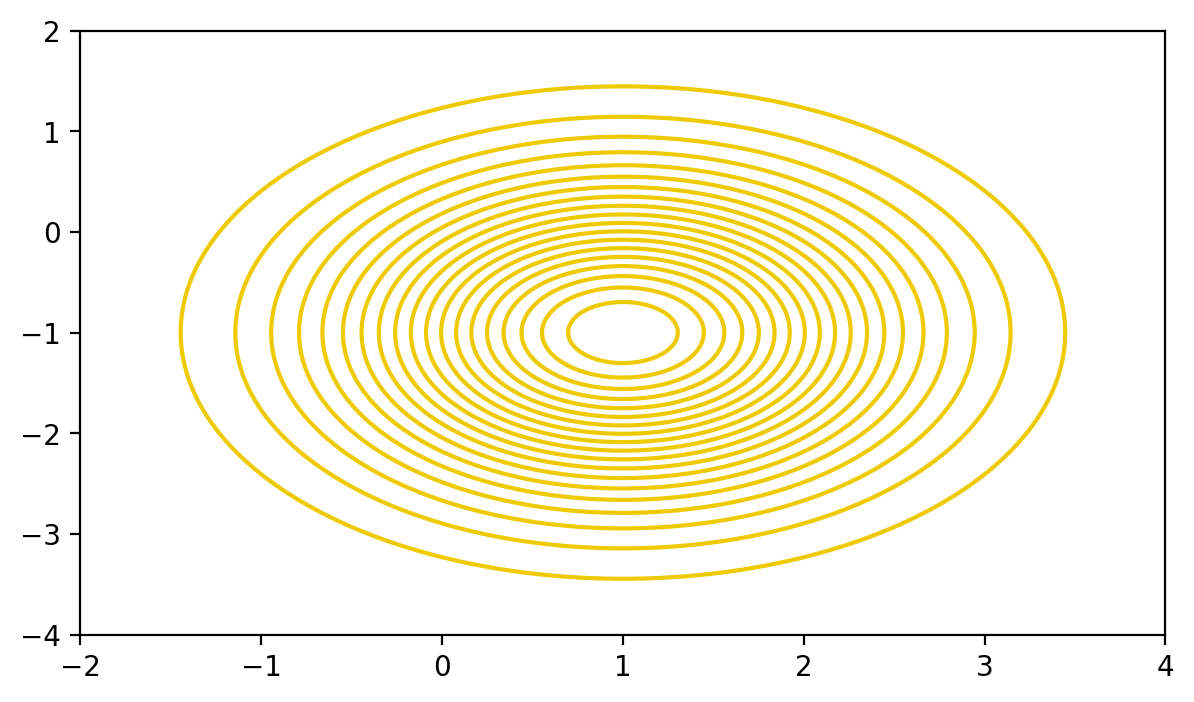

In [58]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.contour(Q1,Q2,Z,levels=25,colors=matplotlib.colors.to_hex(dark))

In [59]:
n_transitions = 5000
D = 2 
sigma = 1.4
mcmc_samples = np.zeros((n_transitions+1,D+1))

In [60]:
np.random.seed(25032021)
mcmc_samples[0, 0:D] = np.random.normal(0, 3,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf(qp) - target_lpdf(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

In [61]:
def mc_stats(mcmc_samples, warmup_iters=0, variable_names=[]):
    col_names = ['mean','standard deviation', 'mcmc_se', 'ESS', 'split_Rhat']
    df = pd.DataFrame(columns=col_names)
    m,n = mcmc_samples.shape
    if len(variable_names)==0:
        variable_names = ['var_'+str(x+1) for x in range(n-1)]
        variable_names.append('acceptance probability')
    if len(variable_names)==n-1:
        variable_names.append('acceptance probability')
    for i in range(n):
        data=np.zeros(5)
        var_i = mcmc_samples[warmup_iters+1:,i]
        data[0] = np.mean(var_i)
        data[1] = np.std(var_i)
        data[2] = az.mcse(var_i)
        data[4] = az.rhat(np.array(np.split(var_i,2)))
        data[3] = np.round(az.ess(var_i))
        df.loc[variable_names[i]] = data
    return df




In [62]:
mc_stats(mcmc_samples,warmup_iters=100)

mean  standard deviation   mcmc_se     ESS  \
var_1                   0.956629            1.004160  0.039765   631.0   
var_2                  -0.994352            0.984925  0.038213   677.0   
acceptance probability  0.423585            0.394535  0.005515  5061.0   

                        split_Rhat  
var_1                     1.001759  
var_2                     1.003114  
acceptance probability    1.000370

In [63]:
mc_series = pd.DataFrame(mcmc_samples[100:,:2],columns=['var_1','var_2'])
N=len(mc_series)
series_mcse = lambda series: az.mcse(series.values)
expan_mean_1 = mc_series.var_1.expanding().mean()
expan_std_1 = mc_series.var_1.expanding().apply(series_mcse)
expan_mean_2 = mc_series.var_2.expanding().mean()
expan_std_2 = mc_series.var_2.expanding().apply(series_mcse)



arviz - WARNING - Shape validation failed: input_shape: (1, 1), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 2), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 3), minimum_shape: (chains=1, draws=4)


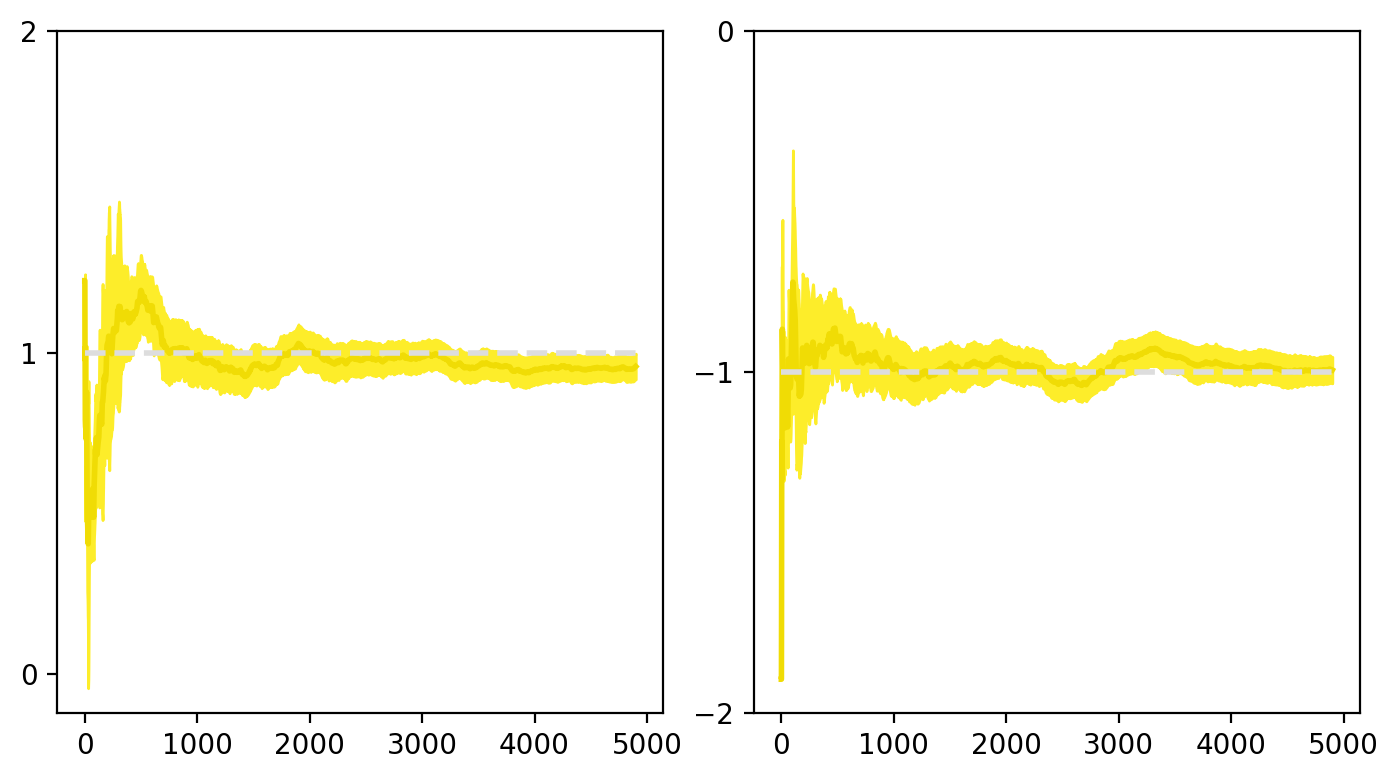

In [64]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(expan_mean_1,color=mid_highlight,linewidth=2)
ax1.plot([0,N],[1,1],color=light_grey,linestyle = '--',linewidth=2)

ax1.fill_between([*range(N)],expan_mean_1-expan_std_1,expan_mean_1+expan_std_1,color=mid)

ax2.plot(expan_mean_2,color=mid_highlight,linewidth=2)
ax2.fill_between([*range(N)],expan_mean_2-expan_std_2,expan_mean_2+expan_std_2,color=mid)
ax2.plot([0,N],[-1,-1],color=light_grey,linestyle = '--',linewidth=2)

ax1.set_yticks([0,1,2])
ax2.set_yticks([-2,-1,0])

plt.tight_layout()

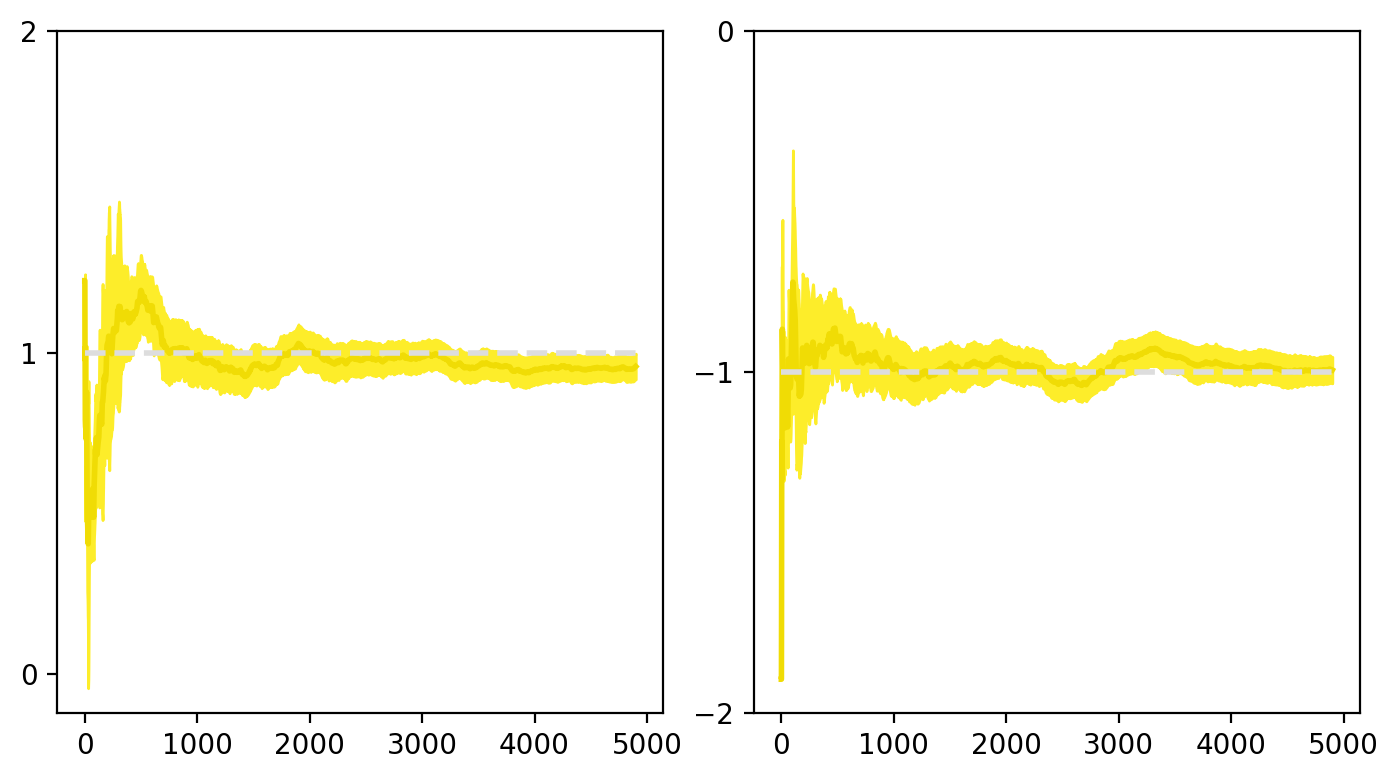

In [65]:
fig

In [66]:
res = np.array(np.split(mcmc_samples[101:,1],2))

In [67]:
az.rhat(res)

1.0031135258368309

In [68]:
np.mean(mcmc_samples[101:,0])

0.9566294769584612

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

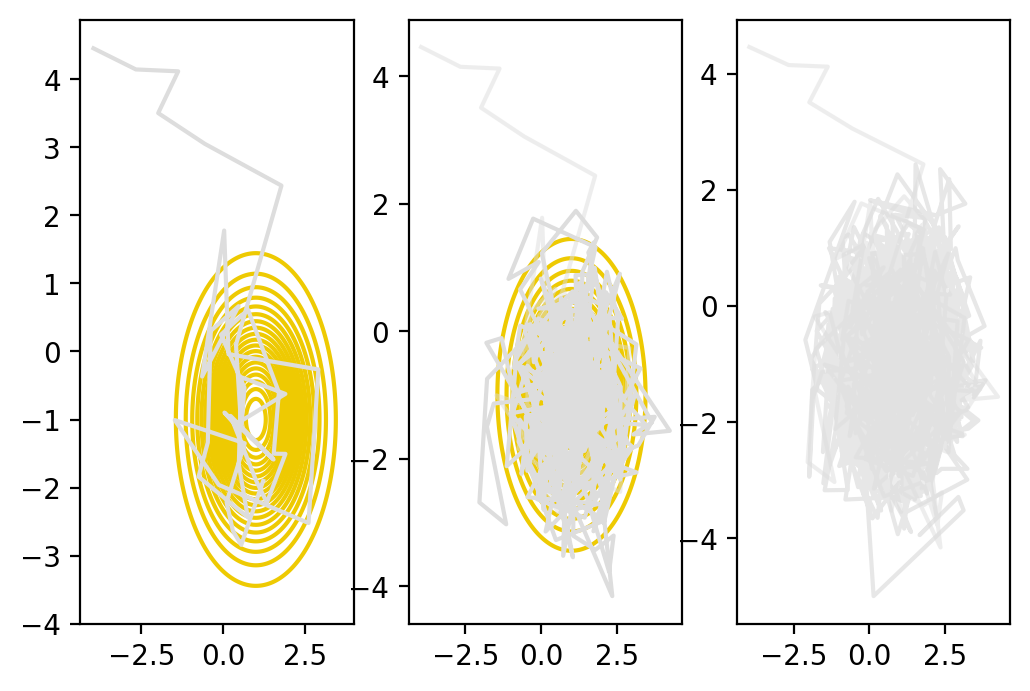

In [69]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.contour(Q1,Q2,Z,levels=25,colors=dark)
ax1.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],color=light_grey)
ax2.contour(Q1,Q2,Z,levels=25,colors=dark)
ax2.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],alpha=0.5,color=light_grey)
ax2.plot(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],alpha=1,color=light_grey)
ax3.plot(mcmc_samples[:1001,0],mcmc_samples[:1001,1],alpha=0.5,color=light_grey)
ax3.plot(mcmc_samples[1001:,0],mcmc_samples[1001:,1],alpha=.7,color=light_grey)
plt.tight_layout

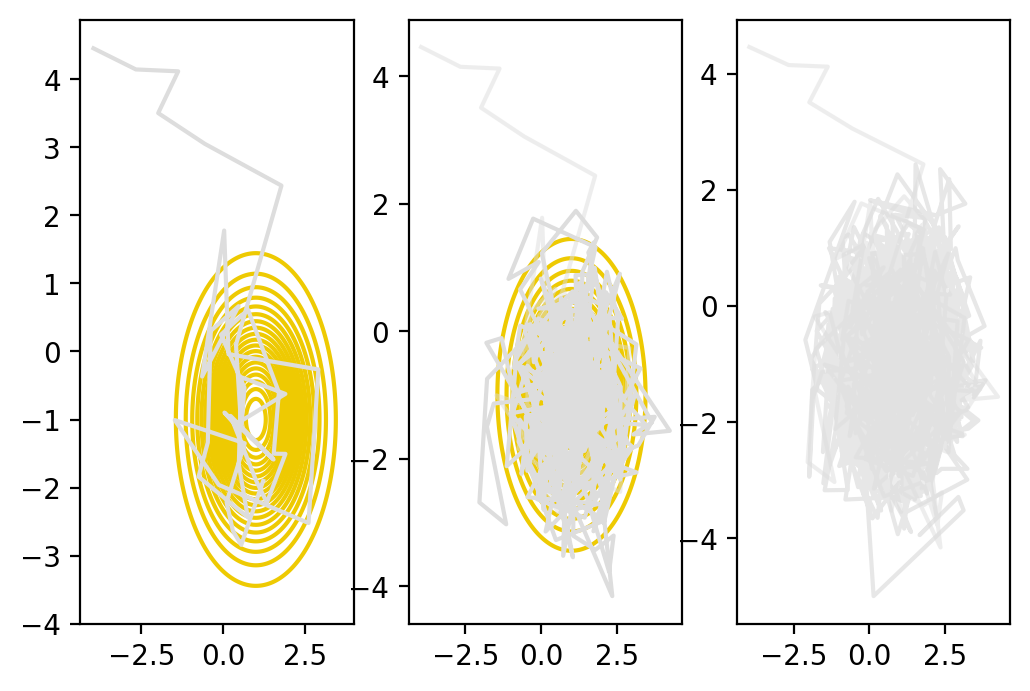

In [70]:
fig

<AxesSubplot:>

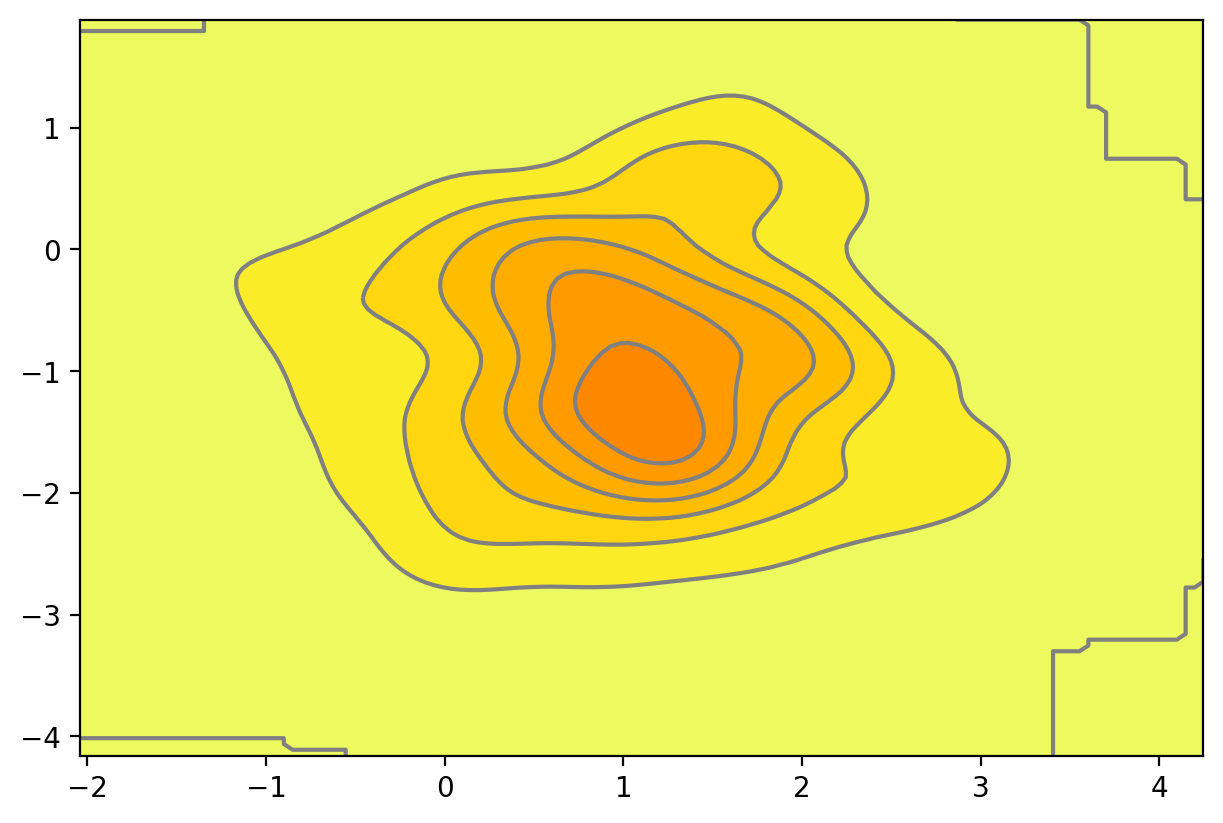

In [71]:
az.plot_dist(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],contourf_kwargs={'cmap':plt.cm.Wistia})

In [104]:
def target_lpdf2(q):
    D = len(q)
    lpdf = - 0.5 * q[0]**2 - 0.5 * np.log(6.283185307179586)
    lpdf = lpdf - 0.5 * (q[1] / 5)**2 - 0.5 * np.log(6.283185307179586 * 25)
    for d in range(2,D):
        lpdf = lpdf - 0.5 * ((q[d] - q[0]) / np.exp(q[1]))**2
        lpdf = lpdf - 0.5 * np.log(6.283185307179586) - q[1]
    return lpdf

In [105]:
q_2=np.linspace(-10,2,1000)
q_3=np.linspace(-11,11,1000)
Q2,Q3 = np.meshgrid(q_2,q_3)
Z = np.zeros(Q2.shape)
for i in range(1000):
    for j in range(1000):
        q=[0, q_2[j],q_3[i], 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Z[i,j]=np.exp(target_lpdf2(q))

Text(0, 0.5, '$q_3$')

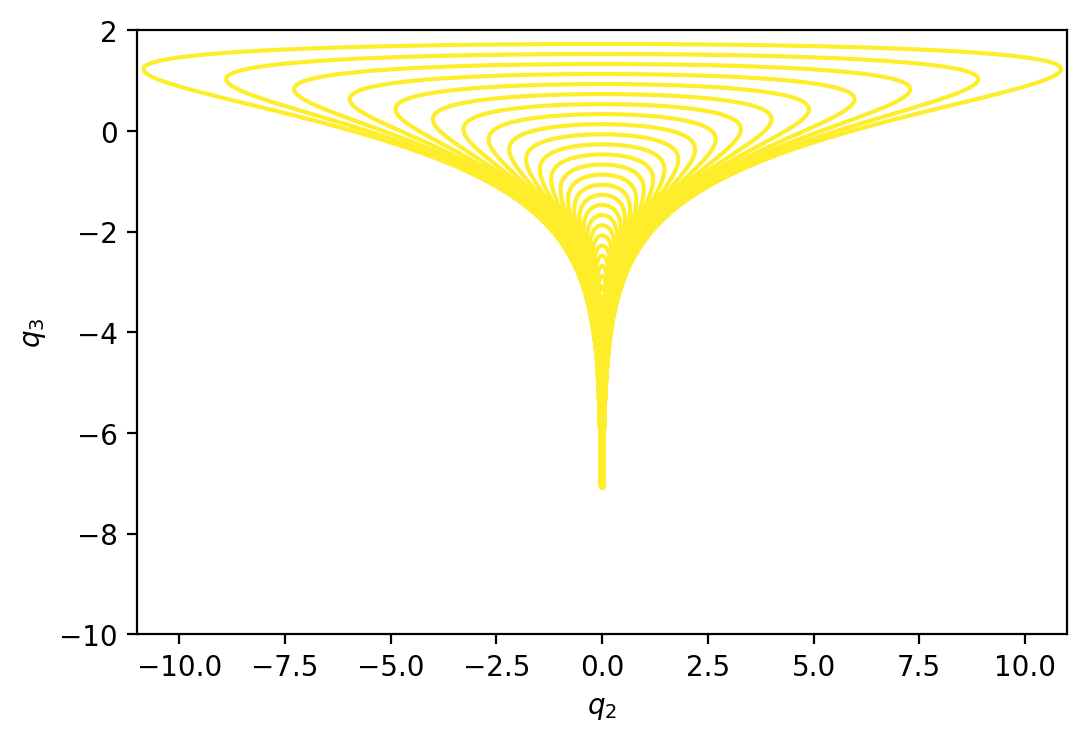

In [107]:
fig,ax = plt.subplots(1,1)
ax.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=mid)
ax.set_xlabel(r'$q_2$')
ax.set_ylabel(r'$q_3$')

## Density contours

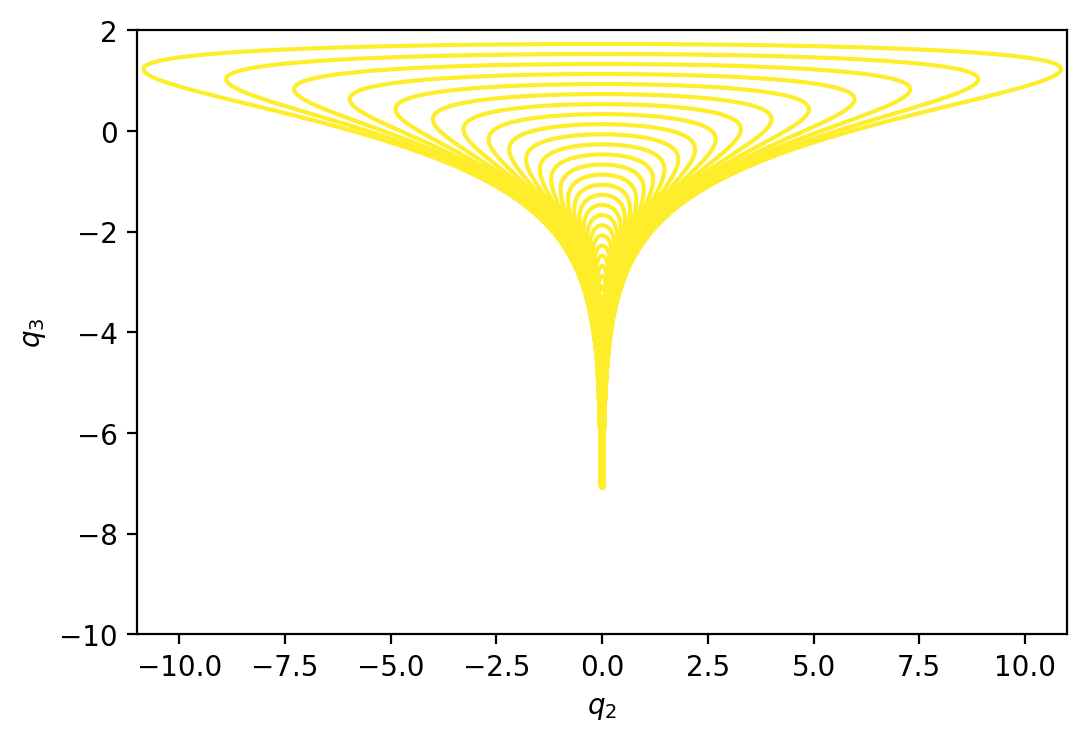

In [108]:
fig

In [75]:
np.random.seed(25032021)
n_transitions = 5000
sigma = 0.5
D = 12
mcmc_samples = np.zeros((n_transitions+1,D+1))
mcmc_samples[0, 0:D] = np.random.normal(0, 3,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf2(qp) - target_lpdf2(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

<AxesSubplot:>

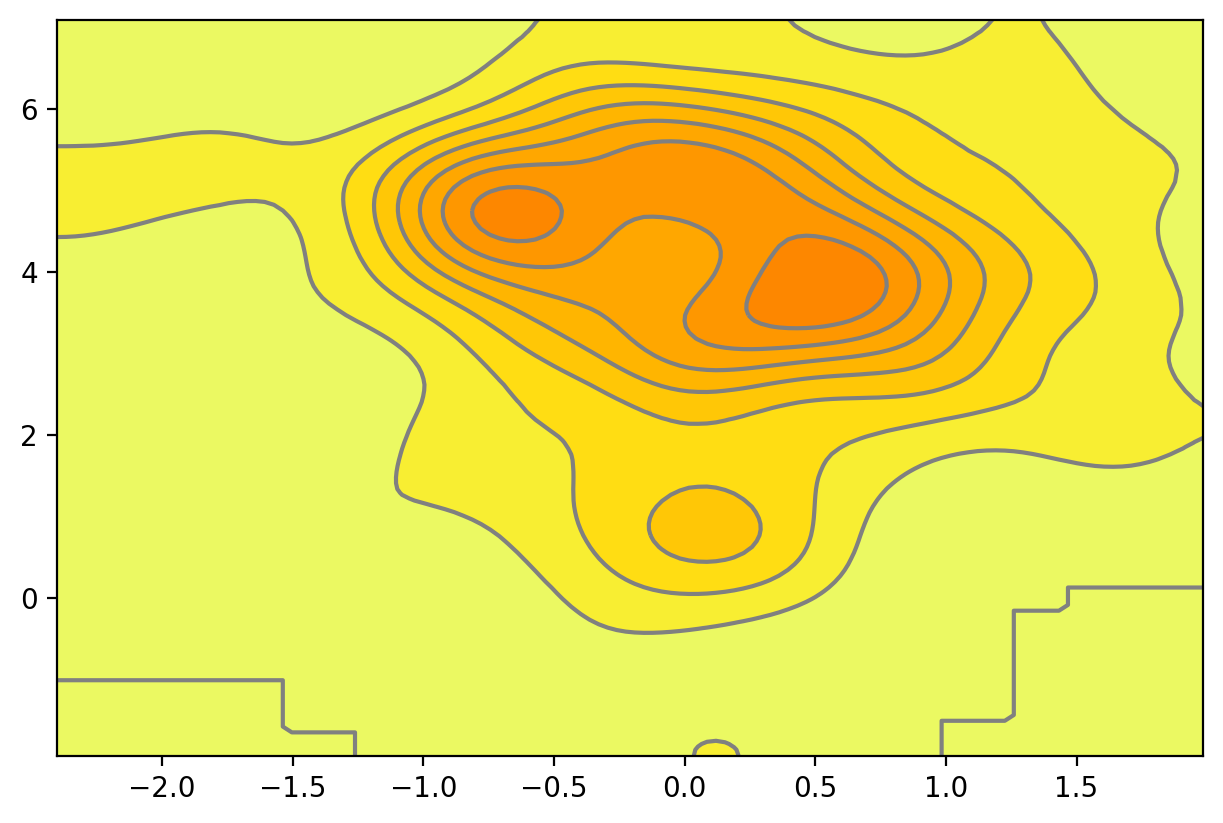

In [76]:
az.plot_dist(mcmc_samples[101:1001,0],mcmc_samples[101:1001,2],contourf_kwargs={'cmap':plt.cm.Wistia})

In [77]:
mc_stats(mcmc_samples[:,[0,1,-1]],warmup_iters=100,variable_names=["mu", "log tau"])

mean  standard deviation   mcmc_se    ESS  \
mu                      0.312808            0.817080  0.100772   67.0   
log tau                 1.059258            0.534453  0.316767    3.0   
acceptance probability  0.352628            0.383232  0.015018  434.0   

                        split_Rhat  
mu                        1.054961  
log tau                   1.456163  
acceptance probability    1.012255

In [109]:
mc_series = pd.DataFrame(mcmc_samples[100:,:2],columns=['var_1','var_2'])
N=len(mc_series)
series_mcse = lambda series: az.mcse(series.values)
expan_mean_1 = mc_series.var_1.expanding().mean()
expan_std_1 = mc_series.var_1.expanding().apply(series_mcse)
expan_mean_2 = mc_series.var_2.expanding().mean()
expan_std_2 = mc_series.var_2.expanding().apply(series_mcse)

KeyboardInterrupt: 

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(expan_mean_1,color=dark,linewidth=2)
ax1.plot([0,N],[0,0],color=light_grey,linestyle = '--',linewidth=2)

ax1.fill_between([*range(N)],expan_mean_1-expan_std_1,expan_mean_1+expan_std_1,color=light)

ax2.plot(expan_mean_2,color=dark,linewidth=2)O
ax2.fill_between([*range(N)],expan_mean_2-expan_std_2,expan_mean_2+expan_std_2,color=light)
ax2.plot([0,N],[0,0],color=light_grey,linestyle = '--',linewidth=2)

ax1.set_yticks([0,1,2])
ax2.set_yticks([-2,-1,0])

plt.tight_layout()

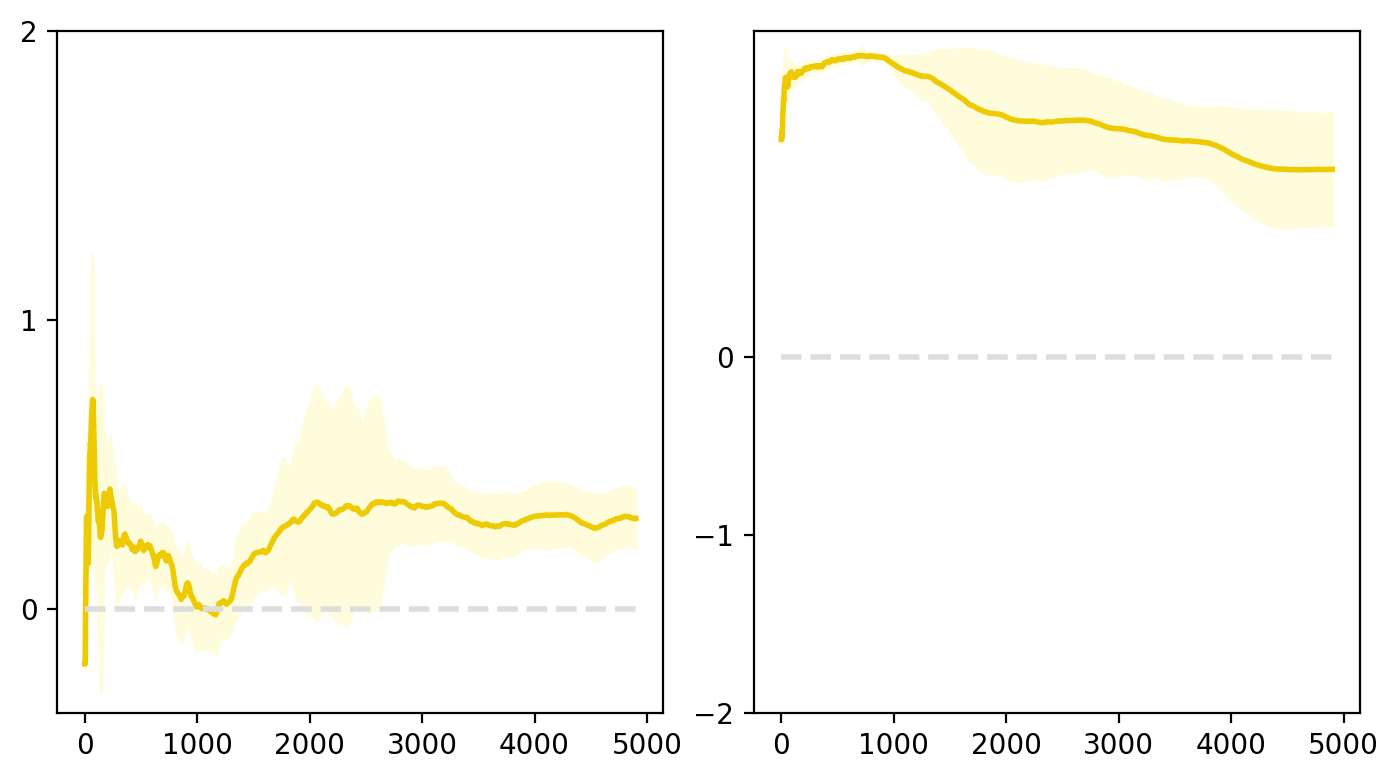

In [81]:
fig

In [98]:
np.random.seed(25032021)
n_transitions = int(1e5)
sigma = 0.5
D = 12
mcmc_samples = np.zeros((n_transitions+1,D+1))
mcmc_samples[0, 0:D] = np.random.normal(0, 3,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf2(qp) - target_lpdf2(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

In [99]:
mc_stats(mcmc_samples,warmup_iters=100)

mean  standard deviation   mcmc_se    ESS  \
var_1                  -0.017098            0.998269  0.128760   60.0   
var_2                   0.170759            0.930362  0.160952   36.0   
var_3                   0.199463            2.282232  0.200693  123.0   
var_4                   0.014156            2.387506  0.197773  127.0   
var_5                  -0.163802            2.397738  0.202534  132.0   
var_6                  -0.047085            2.366912  0.160519  201.0   
var_7                   0.317387            2.598201  0.271139   93.0   
var_8                  -0.202578            2.710389  0.248519  102.0   
var_9                  -0.146753            2.758791  0.345525   66.0   
var_10                 -0.067363            2.220370  0.186956  127.0   
var_11                 -0.020255            2.416309  0.200276  135.0   
var_12                 -0.025320            2.587189  0.238822  119.0   
acceptance probability  0.217402            0.342380  0.024950   99.0   

                        split_Rhat  
var_1                     1.046512  
var_2                     1.044230  
var_3                     1.043242  
var_4                     1.025883  
var_5                     1.018624  
var_6                     1.023556  
var_7                     1.028625  
var_8                     1.031154  
var_9                     1.044462  
var_10                    1.043958  
var_11                    1.026993  
var_12                    1.032439  
acceptance probability    1.015467

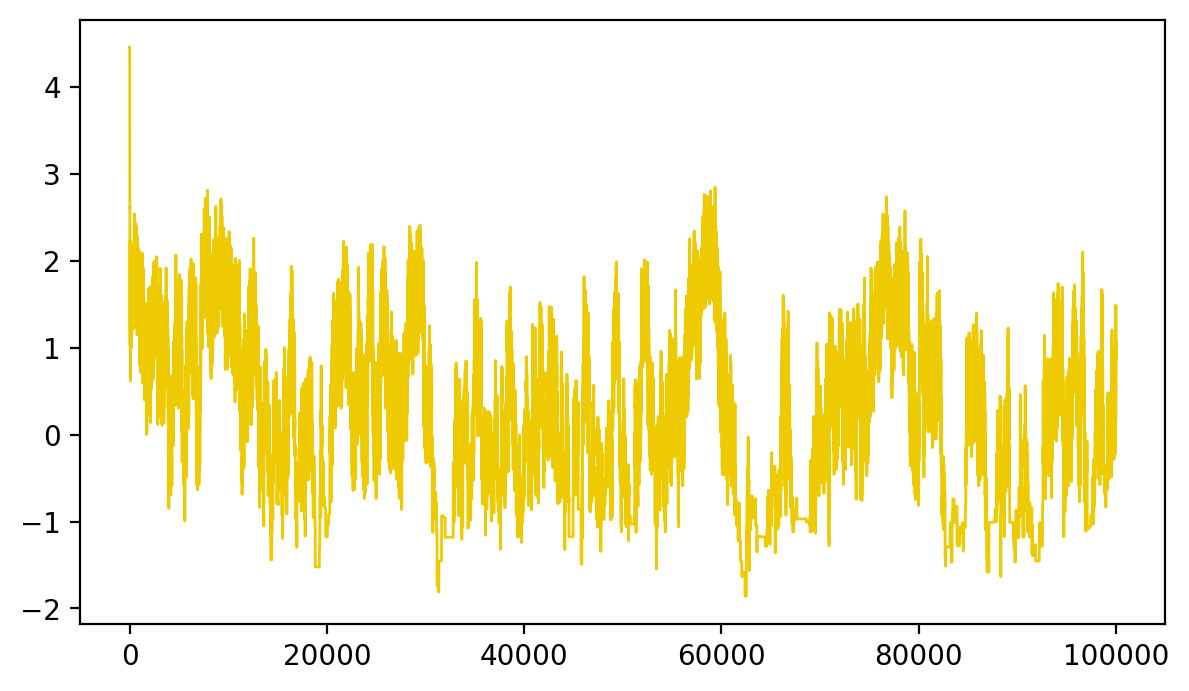

In [100]:
fig, ax1 = plt.subplots(1,1,figsize = (7,4))

ax1.plot(mcmc_samples[:,1],color=dark,linewidth=1)

## Chain samples

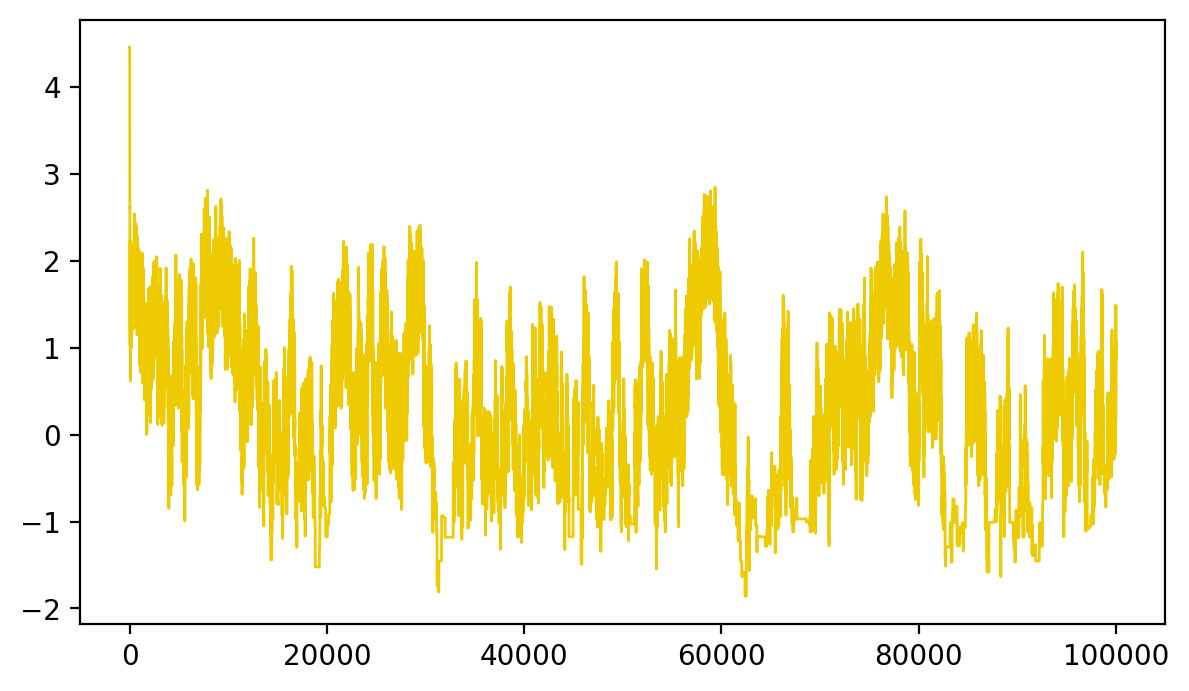

In [101]:
fig

In [110]:
D = 2

def target_lpdf_c1(q):
  mu1 = 4
  sigma1 = 1

  mu2 = 8
  sigma2 = 2

  lpdf = -0.5 * ( ((q[0] - mu1) / sigma1)**2 + ((q[1] - mu2) / sigma2)**2 )
  lpdf = lpdf - 0.5 * np.log(6.283185307179586) - np.log(sigma1) - np.log(sigma2)
  return lpdf 

def target_lpdf_c2(q):
  mu1 = -8
  sigma1 = 2

  mu2 = -4
  sigma2 = 1

  lpdf = -0.5 * ( ((q[0] - mu1) / sigma1)**2 + ((q[1] - mu2) / sigma2)**2 )
  lpdf = lpdf - 0.5 * np.log(6.283185307179586) - np.log(sigma1) - np.log(sigma2)
  return lpdf



def target_lpdf3(x):
  lpdf1 = np.log(0.5) + target_lpdf_c1(x) 
  lpdf2 = np.log(0.5) + target_lpdf_c2(x)
  if lpdf1 > lpdf2:
      lpdf = lpdf1 + np.log(1 + np.exp(lpdf2 - lpdf1))
  else:
      lpdf = lpdf2 + np.log(1 + np.exp(lpdf1 - lpdf2))
  return lpdf


In [111]:
q_1=np.linspace(-13,7,200)
q_2=np.linspace(-7,13,200)
Q1,Q2 = np.meshgrid(q_1,q_2)
Z = np.zeros(Q1.shape)
for i in range(200):
    for j in range(200):
        Z[i,j]=np.exp(target_lpdf3((Q1[i,j],Q2[i,j])))

Text(0, 0.5, '$q_2$')

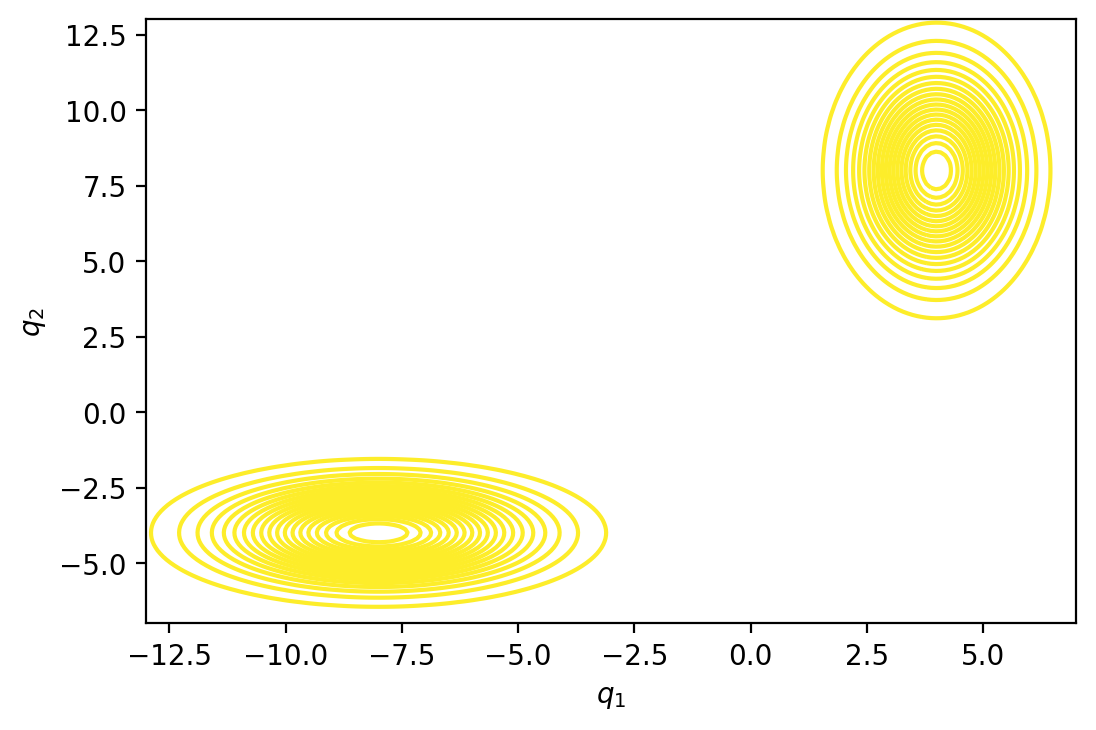

In [114]:
fig,ax = plt.subplots(1,1)
ax.contour(Q1,Q2,Z,levels=20,colors=mid)
ax.set_xlabel(r'$q_1$')
ax.set_ylabel(r'$q_2$')

## Density countours

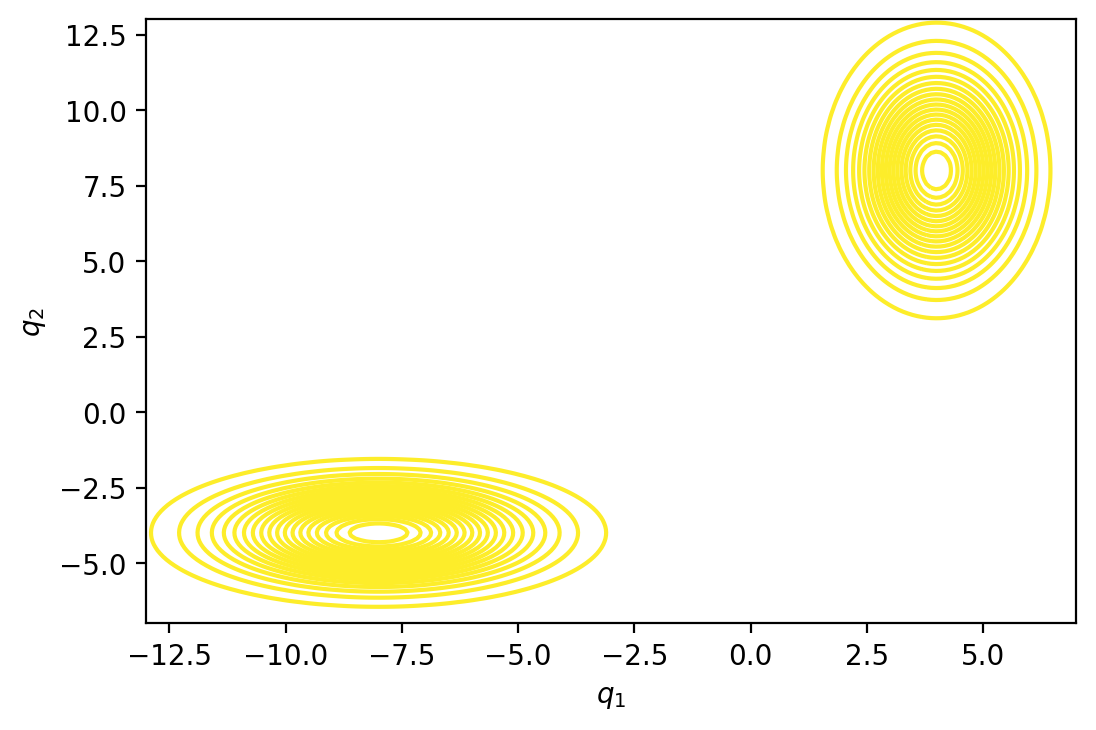

In [115]:
fig

In [87]:
np.random.seed(25032021)
n_transitions = 5000
sigma = 2
D = 2
mcmc_samples = np.zeros((n_transitions+1,D+1))
mcmc_samples[0, 0:D] = np.random.normal(0, 5,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf3(qp) - target_lpdf3(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

In [88]:
mc_stats(mcmc_samples[:,[0,1,-1]],warmup_iters=100,variable_names=["mu", "log tau"])

mean  standard deviation   mcmc_se     ESS  \
mu                      3.940946            1.006392  0.035944   788.0   
log tau                 7.995697            2.040972  0.106708   377.0   
acceptance probability  0.401185            0.396552  0.005485  5253.0   

                        split_Rhat  
mu                        1.002237  
log tau                   1.006069  
acceptance probability    0.999711

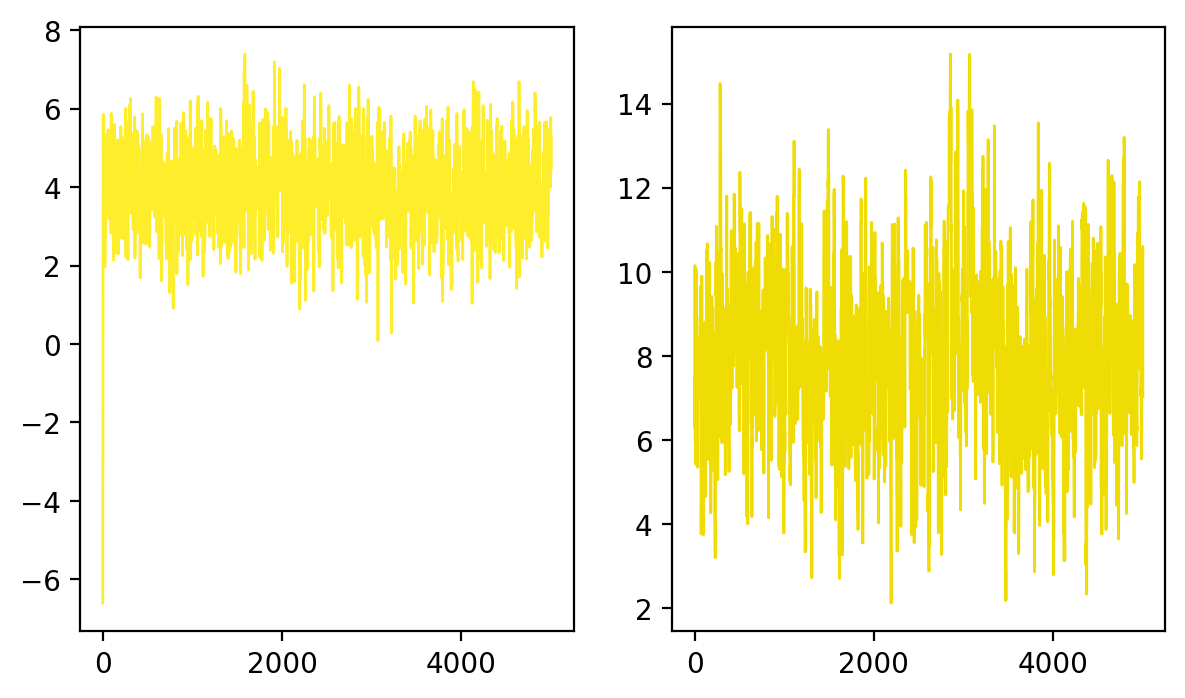

In [89]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))
ax1.plot(mcmc_samples[:,0],color=mid,linewidth=1)
ax2.plot(mcmc_samples[:,1],color=mid_highlight,linewidth=1)
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

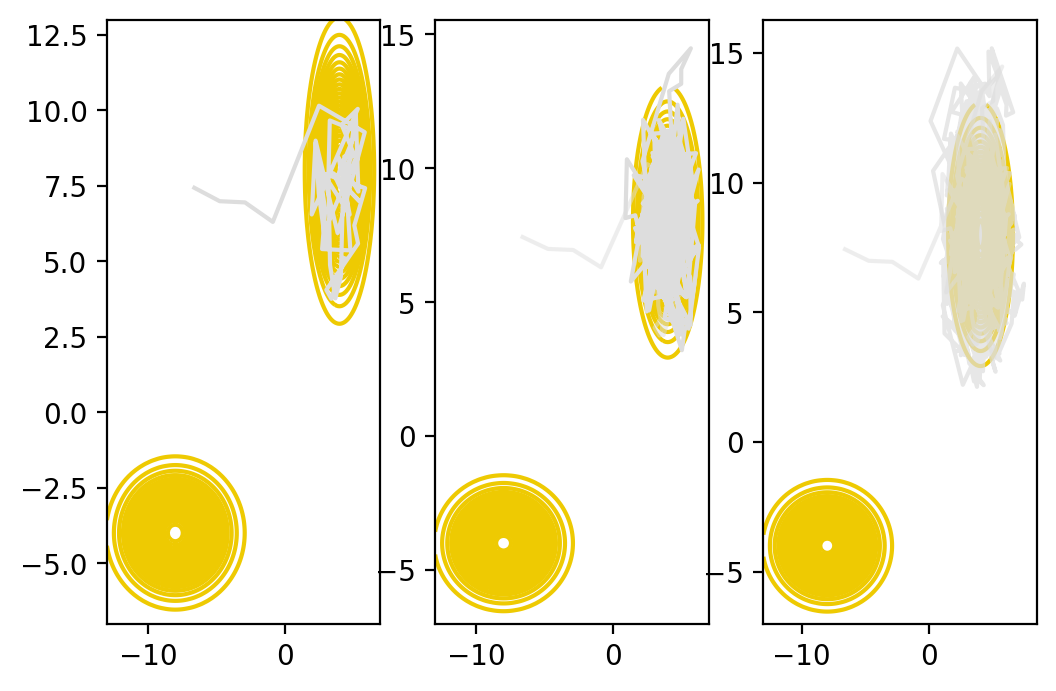

In [90]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.contour(Q1,Q2,Z,levels=25,colors=dark)
ax1.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],color=light_grey)
ax2.contour(Q1,Q2,Z,levels=25,colors=dark)
ax2.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],alpha=0.5,color=light_grey)
ax2.plot(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],alpha=1,color=light_grey)
ax3.contour(Q1,Q2,Z,levels=25,colors=dark)

ax3.plot(mcmc_samples[:1001,0],mcmc_samples[:1001,1],alpha=0.5,color=light_grey)
ax3.plot(mcmc_samples[1001:,0],mcmc_samples[1001:,1],alpha=.7,color=light_grey)
plt.tight_layout

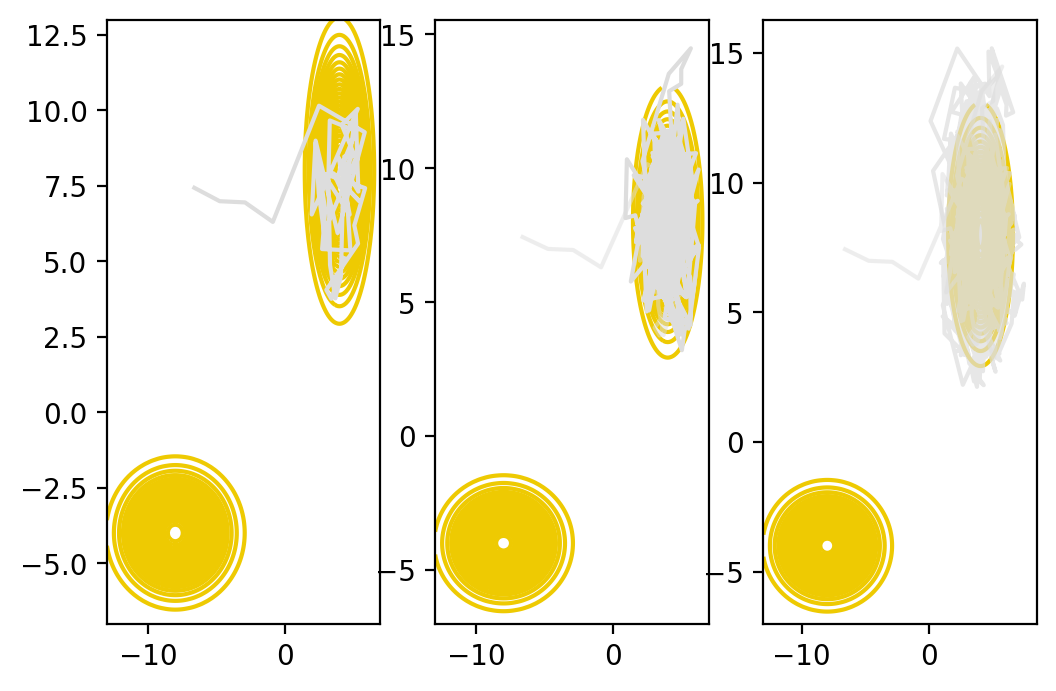

In [91]:
fig

In [116]:
np.random.seed(25032021)
n_transitions = 200000
sigma = 2
D = 2
mcmc_samples = np.zeros((n_transitions+1,D+1))
mcmc_samples[0, 0:D] = np.random.normal(0, 5,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf3(qp) - target_lpdf3(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

In [117]:
mc_stats(mcmc_samples[:,[0,1,-1]],warmup_iters=100,variable_names=["mu", "log tau"])

mean  standard deviation   mcmc_se       ESS  \
mu                     -2.120862            6.186773  6.007144       1.0   
log tau                 1.866986            6.201349  6.023171       1.0   
acceptance probability  0.402297            0.395430  0.000865  205525.0   

                        split_Rhat  
mu                        1.756584  
log tau                   1.753685  
acceptance probability    1.000006

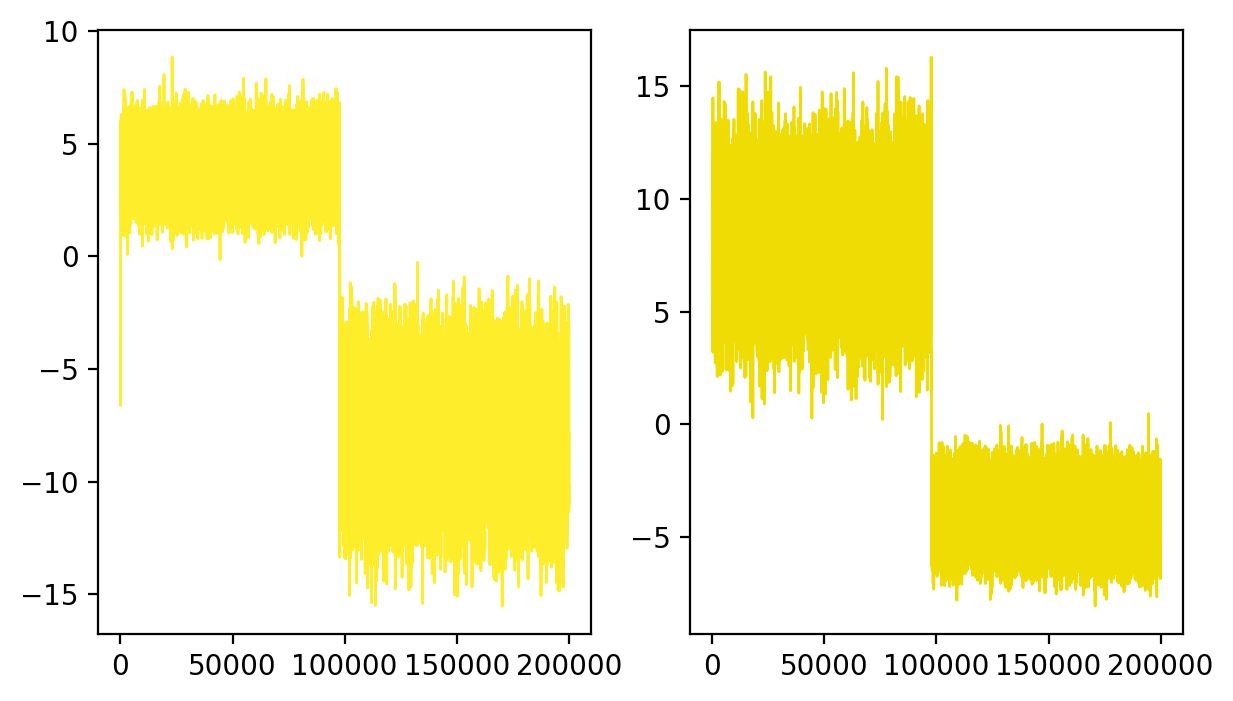

In [118]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(mcmc_samples[:,0],color=mid,linewidth=1)
ax2.plot(mcmc_samples[:,1],color=mid_highlight,linewidth=1)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

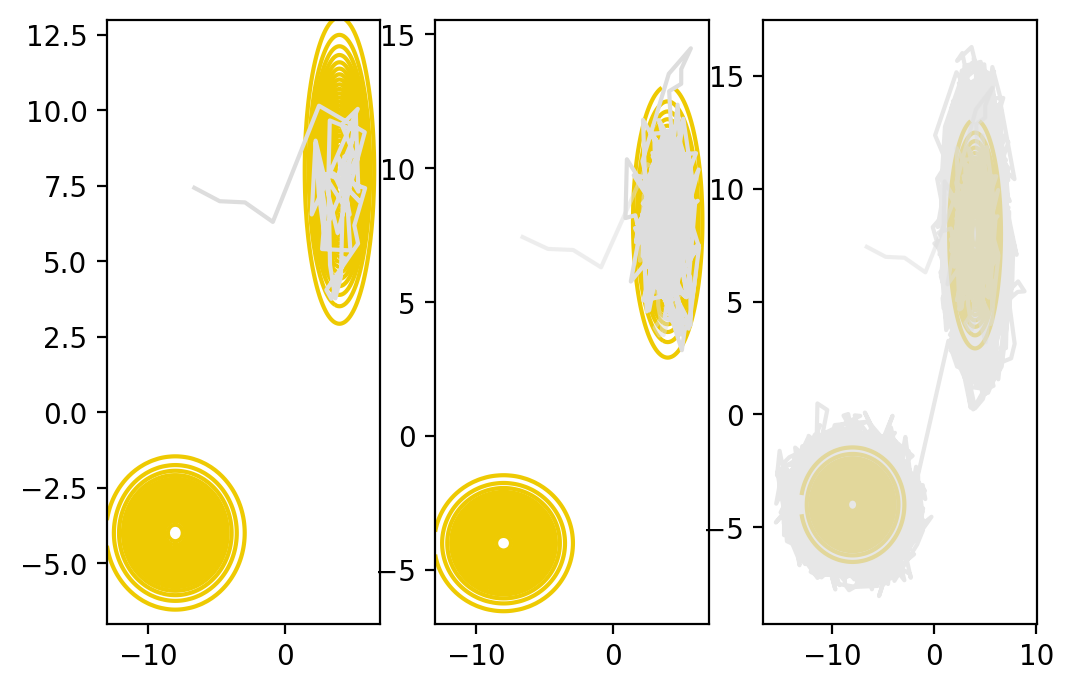

In [119]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.contour(Q1,Q2,Z,levels=25,colors=dark)
ax1.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],color=light_grey)
ax2.contour(Q1,Q2,Z,levels=25,colors=dark)
ax2.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],alpha=0.5,color=light_grey)
ax2.plot(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],alpha=1,color=light_grey)
ax3.contour(Q1,Q2,Z,levels=25,colors=dark)

ax3.plot(mcmc_samples[:1001,0],mcmc_samples[:1001,1],alpha=0.5,color=light_grey)
ax3.plot(mcmc_samples[1001:,0],mcmc_samples[1001:,1],alpha=.7,color=light_grey)
plt.tight_layout

In [ ]:
fig